In [1]:
import scipy         
import datetime
from scipy.linalg import expm
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit


In [2]:
L = 4 #system size
M = 0.1 #fermion mass
N=4 #number of layers
l=1 #spin length
m_epsilon = 0
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [3]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
      0.         |2 2 2 2>           80  
      1.         |2 2 2 1>           79  
      2.         |2 2 2 0>           78  
      3.         |2 2 1 2>           77  
      4.         |2 2 1 1>           76  
      5.         |2 2 1 0>           75  
      6.         |2 2 0 2>           74  
      7.         |2 2 0 1>           73  
      8.         |2 2 0 0>           72  
      9.         |2 1 2 2>           71  
     10.         |2 1 2 1>           70  
     11.         |2 1 2 0>           69  
     12.         |2 1 1 2>           68  
     13.         |2 1 1 1>           67  
     14.         |2 1 1 0>           66  
     15.         |2 1 0 2>           65  
     16.         |2 1 0 1>           64  
     17.         |2 1 0 0>           63  
     18.         |2 0 2 2>           62  
     19.         |2 0 2 1>           61  
     20.         |2 0 2 0>           60  
     21.         |2 0 1 2>           59  
     22

In [4]:
#initialisation of the Gauss laws
LL = 3 #number of sites-1
liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []


for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    
    
gauss_law_map.append([
    ["z",liste[0]],
    ["z",liste[3]],
])

gauss_law_map.append([
    ["z",liste[1]],
    ["z",liste_m[0]],
    ["I",liste[1]],
])

gauss_law_map.append([
    ["z",liste_m[2]],
    ["z",liste_m[1]],
])

gauss_law_map.append([
    ["z",liste_m[3]],
    ["z",liste[2]],
    ["I",liste[3]],
])

for i in range(LL+1):
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(LL+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [5]:
B = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(4*l+1)
b[2*l+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(4*3+1)
for i in range(4*l+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0. 0. 0. 1. 0.]


In [6]:
C = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(4*l+1)
c[2*l] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(4*3+1)
for i in range(4*l+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.    0.    0.    0.    0.    0.
  0.  ]
[0. 0. 1. 0. 0.]


In [7]:
#projectors on g=1 for every site
Proj = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(LL+1)]
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [8]:
A = np.zeros((2*l+1,2*l+1))
for i in range(2*l+1):
    for j in range(2*l+1):
        A[i][j] = (-l+i)**j
a = np.zeros(2*l+1)
for i in range(2*l+1):
    a[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,a)
x = np.zeros(2*3+1)
for i in range(2*l+1):
    x[i] = solution[i]
print(x)

[ 1.  0. -2.  0.  0.  0.  0.]


In [9]:
D = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        D[i][j] = (-2*l+i)**j
d = np.zeros(4*l+1)
d[2*l] = 1.
solution = scipy.linalg.solve(D,d)
dd = np.zeros(4*3+1)
for i in range(4*l+1):
    dd[i] = solution[i]
print(dd)
print(d)

[ 1.    0.   -1.25 -0.    0.25  0.    0.    0.    0.    0.    0.    0.
  0.  ]
[0. 0. 1. 0. 0.]


In [10]:
E = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        E[i][j] = (-2*l+i+1)**j
e = np.zeros(4*l+1)
e[2*l-1] = 1.
solution = scipy.linalg.solve(E,e)
ee = np.zeros(4*3+1)
for i in range(4*l+1):
    ee[i] = solution[i]
print(ee)
print(e)

[ 1.         -0.83333333 -0.83333333  0.83333333 -0.16666667  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0. 1. 0. 0. 0.]


In [11]:
#projectors on g=0 for every site
Proj_0 = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(LL+1)]
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj_0[2*i] += dd[j]*gauss_law_matrix[2*i]**j
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj_0[2*i+1] += ee[j]*gauss_law_matrix[2*i+1]**j

In [32]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []
quartic_term = []
quintic_term = []
sextic_term = []

interaction_p = []
interaction_m = []

phase = []
phase_ham = []

link_p = []
link_p_ham = []

link_m = []
link_m_ham = []

for i in range(L):
    const_term.append([[x[0],i]])
    linear_term.append([[x[1],i]])
    quadratic_term.append([[x[2],i,i]])
    cubic_term.append([[x[3],i,i,i]])
    quartic_term.append([[x[4],i,i,i,i]])
    quintic_term.append([[x[5],i,i,i,i,i]])
    sextic_term.append([[x[6],i,i,i,i,i,i]])


    phase.append([
        ["I", const_term[i]],
        ["z", linear_term[i]],
        ["zz", quadratic_term[i]],
        ["zzz", cubic_term[i]],
        ["zzzz", quartic_term[i]],
        ["zzzzz", quintic_term[i]],
        ["zzzzzz", sextic_term[i]],

    ])
    
    link_p.append([
    ["+",[[1./np.sqrt(l*(l+1)),i]]]  
    ])      
    
    link_m.append([
    ["-",[[1./np.sqrt(l*(l+1)),i]]]           
        
    ])
    
    phase_ham.append(hamiltonian(phase[i],dynamic_list=[],basis=basis,**no_checks))
    link_p_ham.append(hamiltonian(link_p[i],dynamic_list=[],basis=basis,**no_checks))
    link_m_ham.append(hamiltonian(link_m[i],dynamic_list=[],basis=basis,**no_checks))


    


kin_energy = [[0.5,i,i] for i in range(L)]

mass_term = []
mass_term.append([2*(-1)**0*M,0])
mass_term.append([2*(-1)**1*M,1])
mass_term.append([2*(-1)**1*M,2])
mass_term.append([2*(-1)**0*M,3])


kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]

interaction = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(L)]

interaction[0] = -0.5*(Proj[0]@phase_ham[0].tocsc()@link_p_ham[0].tocsc()@Proj[1]+Proj[1]@link_m_ham[0].tocsc()@phase_ham[0].tocsc()@Proj[0])
interaction[1] = 0.5*(Proj[1]@phase_ham[1].tocsc()@link_p_ham[1].tocsc()@Proj[2]+Proj[2]@link_m_ham[1].tocsc()@phase_ham[1].tocsc()@Proj[1])
interaction[2] = 0.5*(Proj[3]@phase_ham[1].tocsc()@phase_ham[2].tocsc()@link_p_ham[2].tocsc()@Proj[2]+Proj[2]@link_m_ham[2].tocsc()@phase_ham[2].tocsc()@phase_ham[1].tocsc()@Proj[3])
interaction[3] = -0.5*(Proj[0]@phase_ham[0].tocsc()@phase_ham[3].tocsc()@link_p_ham[3].tocsc()@Proj[3]+Proj[3]@link_m_ham[3].tocsc()@phase_ham[3].tocsc()@phase_ham[0].tocsc()@Proj[0])

plaquette = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(2)]

plaquette[0] = 0.5*(Proj_0[3]@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@link_p_ham[0].tocsc()@link_p_ham[1].tocsc()@link_m_ham[2].tocsc()@link_m_ham[3].tocsc()@Proj_0[3]+Proj_0[3]@link_p_ham[2].tocsc()@link_p_ham[3].tocsc()@link_m_ham[0].tocsc()@link_m_ham[1].tocsc()@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@Proj_0[3])

plaquette[1] = -0.5*(Proj[3]@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@link_p_ham[0].tocsc()@link_p_ham[1].tocsc()@link_m_ham[2].tocsc()@link_m_ham[3].tocsc()@Proj[3]+Proj[3]@link_p_ham[2].tocsc()@link_p_ham[3].tocsc()@link_m_ham[0].tocsc()@link_m_ham[1].tocsc()@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@Proj[3])

h_plaq = 0

for i in range(2):
    h_plaq += plaquette[i]

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_plaq + h_int #Spin-1 Hamiltonian without the local contstaints

#for i in range(LL+1):
#    full_ham_matrix = (Proj_0[i]+Proj[i])@full_ham_matrix@(Proj_0[i]+Proj[i])

G=0
for i in range(LL+1):
    G += 0.1*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= full_ham_matrix + constraint_full_matrix #Spin-1 Hamiltonian with the local contstaints as a penalty term


In [33]:
print(np.allclose(full_ham_matrix.toarray(), full_ham_matrix.toarray().T.conj(), rtol=1e-8, atol=1e-8))

True


In [34]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(full_ham_matrix,k = 3,which = "SA")
string = ""
print(eigenval[eigenval<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvec[:,0][i])>=1e-5:
        string+=str(eigenvec[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"

[-0.92917693 -0.31306811 -0.1043844 ]


In [35]:
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")


In [36]:
#Gauge invariant part of the spectrum
string = ""
print(eigenvalues[eigenvalues<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])>=1e-4:
        string+=str(eigenvectors[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)


[-0.92917693 -0.31306811  0.49289322]
(-0.00608513978886662+0.0687621491949182j)|2 2 0 1>
(0.013750677436505628-0.15538281226507367j)|2 2 0 0>
(-0.024896033564581244+0.28132546395425734j)|2 1 1 1>
(0.006648892672328394-0.07513256322428462j)|2 1 0 1>
(0.006085139788866612-0.06876214919491819j)|2 1 0 0>
(-0.024896033564581133+0.2813254639542572j)|1 1 1 2>
(0.06838605473083599-0.7727632004209706j)|1 1 1 1>
(-0.024896033564581317+0.2813254639542574j)|1 1 0 1>
(0.006085139788866681-0.06876214919491827j)|1 0 2 2>
(0.006648892672328154-0.0751325632242845j)|1 0 1 2>
(-0.02489603356458114+0.2813254639542574j)|1 0 1 1>
(0.013750677436505737-0.15538281226507378j)|0 0 2 2>
(-0.006085139788866705+0.06876214919491827j)|0 0 1 2>



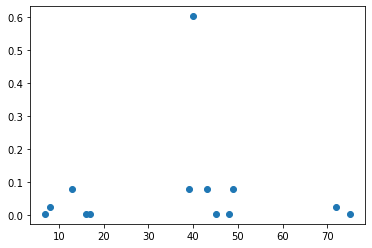

In [37]:
yy = []
xx = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])**2>=1e-4:
        yy.append(np.abs(eigenvectors[:,0][i])**2) 
        xx.append(i)
plt.plot(xx,yy, "o")

In [53]:
def rot_sigma(k,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
        
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-0][2*l-1] = 0.5
    sigma[2*l-1][2*l-0] = 0.5
    sigma = sparse.csc_matrix(sigma)
    
    sigma_1 = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_1[2*l-1][2*l-2] = 0.5
    sigma_1[2*l-2][2*l-1] = 0.5
    sigma_1 = sparse.csc_matrix(sigma_1)
    
    rot_matrix = expm(-1j*theta*(sigma+sigma_1))
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod

def rot_sigma_z(k,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-0][2*l-0] = -1.
    sigma[2*l-2][2*l-2] = 1.
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod

def rot_sigma_z2(k,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-0][2*l-0] = 1.
    sigma[2*l-2][2*l-2] = 1.
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


In [54]:
def ms_hamiltonian(i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    sigma_big = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for k in range(L):
        if k == 0:
            tensprod = sigma
            for m in range(L-1):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        else:
            tensprod = sparse.identity(2*l+1)
            for i in range(1,k):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = scipy.sparse.kron(tensprod,sigma)
            for i in range(k+1,L):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        sigma_big[k] = tensprod
    summe = 1.*(sigma_big[0]+sigma_big[1])@(sigma_big[0]+sigma_big[1]) - 1.*(sigma_big[2]+sigma_big[3])@(sigma_big[2]+sigma_big[3])
    return summe
                
matrix_part = ms_hamiltonian(1,2,0)
ms_ham_eigenval, ms_ham_eigenvec = scipy.linalg.eigh(matrix_part)



def ms_gate_global(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec@exponential@ms_ham_eigenvec.T.conj()


In [ ]:
def func(x):
    if x>=0.9:
        return 10*(0.9-x)
    if x<0.9:
        return 0

In [55]:
#initial state
string_0 = "1111"
#for i in range(L):
#    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string_0)

psi_0[i_0] = 1.


In [59]:
import optuna
n_iter = 3500
theta = np.zeros(5*N)

#cost function definition
def cost_function_sigma(trial):
    psi_var = psi_0
    for i in range(N):
        for j in range(5):
            theta[5*i+j] = trial.suggest_float("5*"+str(i)+"+"+str(j), -2*np.pi, 2*np.pi)

        
            
    for i in range(N):
        psi_var = ms_gate_global(theta[5*i+0])@psi_var
        psi_var = rot_sigma_z(0,theta[5*i+2])@rot_sigma(0,theta[5*i+1])@psi_var
        psi_var = rot_sigma_z(3,theta[5*i+2])@rot_sigma(3,theta[5*i+1])@psi_var
        psi_var = rot_sigma_z(1,theta[5*i+3])@rot_sigma(1,theta[5*i+4])@psi_var
        psi_var = rot_sigma_z(2,theta[5*i+3])@rot_sigma(2,theta[5*i+4])@psi_var
        
    cost = np.conj(psi_var)@constrained_full_ham_matrix@psi_var + func(np.abs(np.dot(np.conj(psi_var),eigenvectors[:,0]))**2)
    return np.real(cost)

sampler = optuna.samplers.CmaEsSampler()
study = optuna.create_study(sampler=sampler)
study.optimize(cost_function_sigma, n_trials=n_iter)

[I 2022-05-11 14:31:01,510] A new study created in memory with name: no-name-73c9e6f1-19cd-4727-a8a0-53b48828cd31
/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:31:01,686] Trial 0 finished with value: 3.0256796694168036 and parameters: {'5*0+0': 9.247412860949286, '5*0+1': 1.068710568881773, '5*0+2': 0.059740929210764904, '5*0+3': 5.655182152474385, '5*0+4': -5.383828626059543, '5*1+0': -10.322667333928635, '5*1+1': -10.066297073703048, '5*1+2': -10.840145157758357, '5*1+3': 2.7170139331672054, '5*1+4': 7.546377378716446, '5*2+0': -7.593180560383735, '5*2+1': 4.331115556534563, '5*2+2': -10.819727772232755, '5*2+3': 12.508965538918797, '5*2+4': 7.586026511680231, '5*3+0': 7.035607613930253, '5*3+1': 5.634786692543312, '5*3+2': 0.5931793423467298, '5*3+3': 1.8078712092040927, '5*3+4':

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:31:02,955] Trial 9 finished with value: 2.9272750114020063 and parameters: {'5*0+0': -2.018523041515464, '5*0+1': 5.085369030710535, '5*0+2': 3.8368048489984465, '5*0+3': -6.75849072132587, '5*0+4': 0.6827449804480182, '5*1+0': 0.9411160519216414, '5*1+1': -2.0064078414740396, '5*1+2': -1.3907649681958785, '5*1+3': -0.05894152552118873, '5*1+4': 3.047382111144943, '5*2+0': 0.5736602200577768, '5*2+1': -1.2950113977519484, '5*2+2': -7.1052646914760444, '5*2+3': -4.258831129867696, '5*2+4': -3.3850463505675887, '5*3+0': -3.4797953535498314, '5*3+1': -5.375768787833846, '5*3+2': 3.4272891869303574, '5*3+3': 4.056877710192582, '5*3+4': -5.065879605461193}. Best is trial 6 with value: 2.740581401238354.
/home/ppopov/anaconda3/lib/python3.8/si

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:31:04,244] Trial 18 finished with value: 3.4955841670231926 and parameters: {'5*0+0': -1.650550911624305, '5*0+1': 3.2408471735217774, '5*0+2': -3.7273990668290473, '5*0+3': -4.119006321619564, '5*0+4': 3.0055010725368514, '5*1+0': -4.256718199323204, '5*1+1': -0.43992674913693586, '5*1+2': -3.106173299031012, '5*1+3': 0.7899503235335268, '5*1+4': 6.662448136838346, '5*2+0': -2.3966093491632368, '5*2+1': 1.0760976217206755, '5*2+2': -6.046727296665856, '5*2+3': 6.470732120879212, '5*2+4': -1.3857118827941057, '5*3+0': 2.2229078819703223, '5*3+1': -3.1977822335636397, '5*3+2': 3.61632812534686, '5*3+3': -9.675674115650795, '5*3+4': -6.839334742175267}. Best is trial 17 with value: 2.7165346893195847.
/home/ppopov/anaconda3/lib/python3.8/s

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:31:05,530] Trial 27 finished with value: 4.827790109285219 and parameters: {'5*0+0': 0.9417781489482301, '5*0+1': 2.46346115019439, '5*0+2': 2.5532986179449084, '5*0+3': -3.0241766141534505, '5*0+4': 1.2156877986786552, '5*1+0': -4.059006920894984, '5*1+1': -4.6865962307699744, '5*1+2': 2.708644990219935, '5*1+3': 7.388293243121252, '5*1+4': -2.1564061883767436, '5*2+0': -0.22865653297161076, '5*2+1': 2.234308011992443, '5*2+2': -6.377883905906925, '5*2+3': 3.7598226000514305, '5*2+4': -6.427596623693166, '5*3+0': 0.322752714579869, '5*3+1': -5.327098826351023, '5*3+2': -1.803121684237328, '5*3+3': -4.238416333025853, '5*3+4': -0.17319362285152096}. Best is trial 21 with value: 2.151023271862461.
/home/ppopov/anaconda3/lib/python3.8/site

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:31:06,955] Trial 36 finished with value: 4.5664228907779325 and parameters: {'5*0+0': 7.103477190531533, '5*0+1': 2.152812365132541, '5*0+2': 0.2513804380624145, '5*0+3': -4.318286440590233, '5*0+4': 3.8521092370995325, '5*1+0': -5.407905463228413, '5*1+1': 0.08224222766780409, '5*1+2': 7.791701372596219, '5*1+3': 1.420818687991531, '5*1+4': -0.007583326977711913, '5*2+0': 7.791909884042381, '5*2+1': 1.871159130936883, '5*2+2': -3.0456832624715333, '5*2+3': -4.113727209576899, '5*2+4': -4.953403111247897, '5*3+0': -6.611656054456526, '5*3+1': 3.460579309193549, '5*3+2': 4.71849156341995, '5*3+3': 3.992007858928064, '5*3+4': -5.918786358256608}. Best is trial 21 with value: 2.151023271862461.
/home/ppopov/anaconda3/lib/python3.8/site-pack

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:31:08,287] Trial 45 finished with value: 3.4624327684564316 and parameters: {'5*0+0': -3.068988815667044, '5*0+1': -6.916071638159262, '5*0+2': 2.8955835457928494, '5*0+3': -4.1749885006513425, '5*0+4': -3.942605162810441, '5*1+0': -2.043901653706696, '5*1+1': 6.967530136114325, '5*1+2': 2.9487295645321336, '5*1+3': 1.880287518350851, '5*1+4': 0.6797864555003144, '5*2+0': 7.469717248733589, '5*2+1': 2.2501648327684167, '5*2+2': -3.987834287633577, '5*2+3': 3.366977208033947, '5*2+4': 1.4723759306657873, '5*3+0': 5.255106721284609, '5*3+1': -3.275034708704433, '5*3+2': 11.16956825350317, '5*3+3': 5.325735692298292, '5*3+4': 0.03428608176846293}. Best is trial 21 with value: 2.151023271862461.
[I 2022-05-11 14:31:08,414] Trial 46 finished 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:31:09,517] Trial 54 finished with value: 3.1796353682525 and parameters: {'5*0+0': -0.43117838157745614, '5*0+1': -0.4499767126194929, '5*0+2': -1.9300018189294201, '5*0+3': -5.753360242789118, '5*0+4': 2.061324375956106, '5*1+0': -0.2791225242756079, '5*1+1': 4.913701752119372, '5*1+2': -0.5230497851466118, '5*1+3': 3.0695423326009994, '5*1+4': 1.6624481958148825, '5*2+0': -1.3528564606666433, '5*2+1': -3.3530395114822573, '5*2+2': -4.210466731399631, '5*2+3': -2.25416261334834, '5*2+4': 6.559506451315859, '5*3+0': 0.7113483051293594, '5*3+1': -6.610291395433162, '5*3+2': 9.779384933263753, '5*3+3': 1.5229696165528714, '5*3+4': -9.191230194387863}. Best is trial 49 with value: 1.9060434804227082.
/home/ppopov/anaconda3/lib/python3.8/sit

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:31:10,761] Trial 63 finished with value: 3.1359041579018476 and parameters: {'5*0+0': -1.2166623576053224, '5*0+1': 0.42944267433010985, '5*0+2': 1.8575924285477612, '5*0+3': -3.0831938214669985, '5*0+4': -2.8375953802853333, '5*1+0': 0.2694576188417237, '5*1+1': 5.070085070425532, '5*1+2': 2.7747139486909407, '5*1+3': -0.33614038875307417, '5*1+4': -4.2644485210557015, '5*2+0': -5.778777724713025, '5*2+1': 3.169518798036102, '5*2+2': -8.854371167830802, '5*2+3': -0.011166247995146539, '5*2+4': 1.5485411497247394, '5*3+0': -5.512249191943912, '5*3+1': -6.8029757456531135, '5*3+2': 4.975462591898303, '5*3+3': 1.7710761351894122, '5*3+4': -3.153339261216035}. Best is trial 49 with value: 1.9060434804227082.
/home/ppopov/anaconda3/lib/pytho

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:31:12,132] Trial 72 finished with value: 3.454466189848268 and parameters: {'5*0+0': -0.11061110415828262, '5*0+1': 6.7592817878824505, '5*0+2': 0.6326057659743805, '5*0+3': -1.415822620548278, '5*0+4': -0.00922095944379997, '5*1+0': -0.7094182301837777, '5*1+1': 5.855240546397953, '5*1+2': -9.012271270312027, '5*1+3': 2.789047702055843, '5*1+4': 3.857679798309705, '5*2+0': 5.778912077223207, '5*2+1': -1.4652599758276288, '5*2+2': -6.748833596870671, '5*2+3': -0.6911388622097623, '5*2+4': 7.092672550649391, '5*3+0': -1.726389629713855, '5*3+1': -1.3114879585498809, '5*3+2': 8.085923429242406, '5*3+3': -3.5501790273556715, '5*3+4': -2.6347698951633847}. Best is trial 49 with value: 1.9060434804227082.
/home/ppopov/anaconda3/lib/python3.8/

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:31:13,404] Trial 81 finished with value: 4.504138703183324 and parameters: {'5*0+0': -0.9531576867371379, '5*0+1': 10.07942176063235, '5*0+2': -0.8853103501756936, '5*0+3': -5.832282227371486, '5*0+4': -3.782828112520866, '5*1+0': -3.4637267516152193, '5*1+1': 4.678902614496975, '5*1+2': -6.303272971897089, '5*1+3': -5.075303854547987, '5*1+4': -4.524355399770745, '5*2+0': -1.3611281223914387, '5*2+1': 8.216113596468745, '5*2+2': -2.511654699000028, '5*2+3': 2.613379544396338, '5*2+4': -0.27193240510937744, '5*3+0': -1.7308154189378586, '5*3+1': -1.2895636554985141, '5*3+2': 5.403498611229373, '5*3+3': -6.317624895958115, '5*3+4': -0.6269784113285533}. Best is trial 49 with value: 1.9060434804227082.
/home/ppopov/anaconda3/lib/python3.8/

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:31:14,724] Trial 90 finished with value: 4.405378054481503 and parameters: {'5*0+0': -2.4646443718198787, '5*0+1': 4.078808001835233, '5*0+2': 8.794210086160874, '5*0+3': -7.787429135476738, '5*0+4': -3.9183003271108583, '5*1+0': 1.4170752920143803, '5*1+1': 10.036064700969018, '5*1+2': -8.274788793037896, '5*1+3': -2.841336478349029, '5*1+4': -3.010862275454839, '5*2+0': 1.0411959091067142, '5*2+1': -1.4445359517089038, '5*2+2': -1.5950181094783087, '5*2+3': -4.6148241672799015, '5*2+4': -4.537500407382076, '5*3+0': -4.041703594220458, '5*3+1': 2.2972537623147002, '5*3+2': -2.4352647437827786, '5*3+3': 1.3271977140719402, '5*3+4': 3.862950140434757}. Best is trial 49 with value: 1.9060434804227082.
/home/ppopov/anaconda3/lib/python3.8/s

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:31:16,019] Trial 99 finished with value: 2.380541203095203 and parameters: {'5*0+0': -11.182596469333383, '5*0+1': 6.065694174201769, '5*0+2': 4.1083951447544935, '5*0+3': -7.807930945877041, '5*0+4': 1.4574244501395244, '5*1+0': -4.786655598624676, '5*1+1': 6.564172052320604, '5*1+2': -4.972116124208884, '5*1+3': 0.3913260382217192, '5*1+4': -0.5319062807617243, '5*2+0': 5.187356638595778, '5*2+1': -0.0696434142283271, '5*2+2': -11.29805059741929, '5*2+3': -1.614882400897402, '5*2+4': -0.36625921617937074, '5*3+0': 5.195521534355729, '5*3+1': -0.8372773026529778, '5*3+2': 3.3315055762180252, '5*3+3': -2.9418854747221332, '5*3+4': 4.170315407006935}. Best is trial 49 with value: 1.9060434804227082.
/home/ppopov/anaconda3/lib/python3.8/si

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:31:17,491] Trial 108 finished with value: 2.483529239577129 and parameters: {'5*0+0': -5.102548792629068, '5*0+1': 6.31154245574659, '5*0+2': 3.1881741124354694, '5*0+3': -8.297990534725963, '5*0+4': 7.505691848370187, '5*1+0': -2.6764539712531894, '5*1+1': 8.533369597248802, '5*1+2': -7.347981168182826, '5*1+3': -1.128846489782469, '5*1+4': -4.08759842233421, '5*2+0': 2.369757003663561, '5*2+1': -0.025072450740720065, '5*2+2': -1.7888852437814662, '5*2+3': 1.7802728057400845, '5*2+4': 1.3782598248307938, '5*3+0': 2.9230705674252793, '5*3+1': -7.1387243761252845, '5*3+2': 4.953104184670121, '5*3+3': -3.4896455061015286, '5*3+4': 3.9410644071864787}. Best is trial 49 with value: 1.9060434804227082.
/home/ppopov/anaconda3/lib/python3.8/sit

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:31:18,866] Trial 117 finished with value: 2.9583949609568414 and parameters: {'5*0+0': -9.177998198924033, '5*0+1': 8.06775595951939, '5*0+2': 2.2987309701814427, '5*0+3': -0.345761986877128, '5*0+4': 8.230781078067931, '5*1+0': 2.091932861348682, '5*1+1': 11.752062278049937, '5*1+2': -5.125966957324657, '5*1+3': -2.9517046196786136, '5*1+4': -6.104604328184875, '5*2+0': 2.0517557628978755, '5*2+1': 2.2593213473224396, '5*2+2': 1.8420788757137263, '5*2+3': 0.07723991018451881, '5*2+4': -3.857495741485858, '5*3+0': 4.562747298601879, '5*3+1': -1.7185617390387729, '5*3+2': 8.440675074186649, '5*3+3': -6.548219434206015, '5*3+4': -2.142997014874093}. Best is trial 49 with value: 1.9060434804227082.
/home/ppopov/anaconda3/lib/python3.8/site-

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:31:20,159] Trial 126 finished with value: 3.6329674478820837 and parameters: {'5*0+0': -5.244140249459212, '5*0+1': 4.485730055736681, '5*0+2': -2.6421887175174037, '5*0+3': -7.3367156972759915, '5*0+4': 12.232654206580124, '5*1+0': -5.996670906426759, '5*1+1': 7.476100071638829, '5*1+2': -8.538306372121216, '5*1+3': 8.153753542744262, '5*1+4': -11.351023962147014, '5*2+0': 2.7340745914036146, '5*2+1': 0.6618578228202101, '5*2+2': -4.832348769191443, '5*2+3': 1.0613025357627426, '5*2+4': -2.8505497669977604, '5*3+0': -0.7422536662825433, '5*3+1': -1.064095875275369, '5*3+2': 0.3766762831076439, '5*3+3': 1.8654433945789752, '5*3+4': 0.5828148411254404}. Best is trial 49 with value: 1.9060434804227082.
/home/ppopov/anaconda3/lib/python3.8/

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:31:21,664] Trial 135 finished with value: 2.664804325273249 and parameters: {'5*0+0': -7.0639354867279085, '5*0+1': 8.446173287792925, '5*0+2': 4.815833430130111, '5*0+3': -7.425050084067985, '5*0+4': 1.7804175740889043, '5*1+0': -2.0724537467629407, '5*1+1': 9.98926398935641, '5*1+2': -5.1298788957394965, '5*1+3': 3.2593689764474147, '5*1+4': -4.741086114585455, '5*2+0': -1.1940400939127902, '5*2+1': 0.642623317782587, '5*2+2': 0.39374824296123645, '5*2+3': 1.2122975523916775, '5*2+4': 2.047677518068555, '5*3+0': -0.8044813563784627, '5*3+1': -5.688163217988123, '5*3+2': 4.459815258425607, '5*3+3': -2.3497786459680343, '5*3+4': -0.9235927684483891}. Best is trial 49 with value: 1.9060434804227082.
/home/ppopov/anaconda3/lib/python3.8/si

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:31:23,523] Trial 144 finished with value: 3.243755678345846 and parameters: {'5*0+0': -5.693557414082363, '5*0+1': 3.2575167951028154, '5*0+2': 8.779039692959579, '5*0+3': -5.760622465608977, '5*0+4': 7.859631034429525, '5*1+0': -2.3807100685291633, '5*1+1': 8.655671079531546, '5*1+2': -6.542418310971692, '5*1+3': 5.646897779483596, '5*1+4': -6.274975758667455, '5*2+0': -1.4024124604969046, '5*2+1': 3.5135372672933385, '5*2+2': -1.2692647198376765, '5*2+3': -0.1140996334940999, '5*2+4': 3.211189744441539, '5*3+0': -4.368177131248615, '5*3+1': -6.811719716034048, '5*3+2': 0.5568576139336314, '5*3+3': 0.8483137061265058, '5*3+4': 8.853624305334947}. Best is trial 49 with value: 1.9060434804227082.
/home/ppopov/anaconda3/lib/python3.8/site-

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:31:25,297] Trial 153 finished with value: 2.878319732048485 and parameters: {'5*0+0': -9.464844254456375, '5*0+1': 11.440894692118249, '5*0+2': 2.4021244048601824, '5*0+3': -6.481736338455222, '5*0+4': -1.4050243789176298, '5*1+0': -10.88364735329538, '5*1+1': 10.70476863978044, '5*1+2': -1.939646652680501, '5*1+3': 5.209094070908059, '5*1+4': -9.100629735019336, '5*2+0': 0.45061366684785586, '5*2+1': 0.7885523740614621, '5*2+2': -3.8861061802540617, '5*2+3': -0.9678366535163758, '5*2+4': -0.8981431383157621, '5*3+0': -0.09985786370821192, '5*3+1': 0.0005475553049671955, '5*3+2': 6.985412968680703, '5*3+3': -1.3030716964867728, '5*3+4': -3.017198427427253}. Best is trial 49 with value: 1.9060434804227082.
/home/ppopov/anaconda3/lib/pytho

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:31:27,204] Trial 162 finished with value: 2.667715726740587 and parameters: {'5*0+0': -6.23604118476524, '5*0+1': 5.587059666718802, '5*0+2': 1.9815580941675595, '5*0+3': -10.052682931119799, '5*0+4': 3.852420329536927, '5*1+0': -3.723395929089587, '5*1+1': 12.178821206843828, '5*1+2': -6.397666353669423, '5*1+3': 7.96717306780219, '5*1+4': -8.569396925798399, '5*2+0': -2.5444262793036905, '5*2+1': -1.6054962775990516, '5*2+2': -2.5257934434948615, '5*2+3': -4.960630286447166, '5*2+4': 0.8040894062628209, '5*3+0': -4.6799050204797314, '5*3+1': 3.953780282451209, '5*3+2': 4.422872154013004, '5*3+3': 2.638860218676948, '5*3+4': 2.604306109741434}. Best is trial 49 with value: 1.9060434804227082.
/home/ppopov/anaconda3/lib/python3.8/site-pa

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:31:28,919] Trial 171 finished with value: 3.2068694494142402 and parameters: {'5*0+0': -6.476839317806218, '5*0+1': 10.092370613384276, '5*0+2': 1.11516389637723, '5*0+3': -4.3681216415503314, '5*0+4': 6.090856279411005, '5*1+0': -0.2549077349725355, '5*1+1': 8.590653854392068, '5*1+2': -7.089287098980782, '5*1+3': 0.9699039680774435, '5*1+4': 1.1204138201159521, '5*2+0': 1.044078113431145, '5*2+1': -3.7466649576961126, '5*2+2': -1.7571501729375893, '5*2+3': 0.15215048418347887, '5*2+4': 0.506186037374857, '5*3+0': 2.1785613110278508, '5*3+1': 2.64711946023976, '5*3+2': -0.6590096732883475, '5*3+3': -3.016605997300259, '5*3+4': 6.808316737056305}. Best is trial 49 with value: 1.9060434804227082.
/home/ppopov/anaconda3/lib/python3.8/site-

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:31:30,698] Trial 180 finished with value: 4.200908136015581 and parameters: {'5*0+0': -6.575693801500136, '5*0+1': 7.212944924646619, '5*0+2': 1.8185674098264037, '5*0+3': -5.051900351004387, '5*0+4': -0.02527676442022586, '5*1+0': -2.9119271160465896, '5*1+1': 8.316166203215055, '5*1+2': -5.131729823160908, '5*1+3': 11.48930579992249, '5*1+4': -3.1554086320841526, '5*2+0': -6.915072805871897, '5*2+1': -0.6758407341642685, '5*2+2': -5.043431113593776, '5*2+3': -1.2703088988822726, '5*2+4': 1.0758533781041328, '5*3+0': -4.501167763401821, '5*3+1': -0.8776878912314582, '5*3+2': 0.8992816693489432, '5*3+3': 2.677408741171324, '5*3+4': -3.794445213787456}. Best is trial 49 with value: 1.9060434804227082.
/home/ppopov/anaconda3/lib/python3.8/

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:31:32,378] Trial 189 finished with value: 2.4872017290534667 and parameters: {'5*0+0': -10.20133789182636, '5*0+1': 5.643055250927393, '5*0+2': 0.1589454191613473, '5*0+3': -7.677132599527541, '5*0+4': 8.206434341590846, '5*1+0': -0.835284506988941, '5*1+1': 4.922588560803682, '5*1+2': -0.540718008693077, '5*1+3': 10.81458868571908, '5*1+4': -3.1467303896656724, '5*2+0': 0.6468697420828091, '5*2+1': 1.6318891254706867, '5*2+2': 0.5506993326132403, '5*2+3': -5.656959757433043, '5*2+4': 5.7210523879923025, '5*3+0': 1.525178212101191, '5*3+1': -1.7805993672409417, '5*3+2': -0.9475555384532577, '5*3+3': 5.140448619734627, '5*3+4': 4.950433629144785}. Best is trial 185 with value: 1.8073901260014489.
/home/ppopov/anaconda3/lib/python3.8/site-

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:31:34,161] Trial 198 finished with value: 3.476300181685497 and parameters: {'5*0+0': -6.000206912491011, '5*0+1': 10.557265169796269, '5*0+2': 1.0677797935723805, '5*0+3': -1.8802771862868153, '5*0+4': 2.6917906387565114, '5*1+0': -2.19916138228787, '5*1+1': 6.773376853965941, '5*1+2': -1.9098932554467916, '5*1+3': 4.7597698708663705, '5*1+4': -7.294175637798745, '5*2+0': -0.7891728306854362, '5*2+1': -1.6933205187909919, '5*2+2': -4.282596329216509, '5*2+3': -2.5851265933030403, '5*2+4': 0.18156316473929168, '5*3+0': 3.0929107754486855, '5*3+1': 2.4781239752026107, '5*3+2': -3.2077626150851932, '5*3+3': 3.011882441044241, '5*3+4': 3.7469561894157604}. Best is trial 185 with value: 1.8073901260014489.
/home/ppopov/anaconda3/lib/python3.

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:31:36,031] Trial 207 finished with value: 5.55721532991526 and parameters: {'5*0+0': -3.6345579695537005, '5*0+1': 8.631045473070726, '5*0+2': -0.1981351227362611, '5*0+3': -7.019822308218318, '5*0+4': 5.033108455189676, '5*1+0': 3.1962240022594046, '5*1+1': 7.822751339487684, '5*1+2': -3.5995374178780453, '5*1+3': 2.79905384898619, '5*1+4': -1.8682035411767368, '5*2+0': -1.912238639858707, '5*2+1': -4.08142354470862, '5*2+2': 2.940091573710303, '5*2+3': -3.470005662304393, '5*2+4': -2.0086467531989913, '5*3+0': 3.095281416408363, '5*3+1': 0.29095478424054355, '5*3+2': 0.17146014157690503, '5*3+3': 4.549730743150354, '5*3+4': 4.662902224608561}. Best is trial 185 with value: 1.8073901260014489.
/home/ppopov/anaconda3/lib/python3.8/site-p

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:31:37,747] Trial 216 finished with value: 2.868486146383363 and parameters: {'5*0+0': -10.744350918167227, '5*0+1': 10.273560790273045, '5*0+2': 0.35666072077946487, '5*0+3': -8.09953388055851, '5*0+4': 4.133908931664467, '5*1+0': -0.529574959489804, '5*1+1': 3.555479984262404, '5*1+2': -5.609183133126675, '5*1+3': 3.263017835078368, '5*1+4': 0.08649207449738772, '5*2+0': 0.8116560058998119, '5*2+1': -3.572651683019098, '5*2+2': -1.6375329019613494, '5*2+3': -6.401977911864096, '5*2+4': -2.268385442781698, '5*3+0': 3.254659535088871, '5*3+1': -0.49247590099231964, '5*3+2': -2.917914141249994, '5*3+3': -2.1860297787200382, '5*3+4': 4.123556830945233}. Best is trial 185 with value: 1.8073901260014489.
/home/ppopov/anaconda3/lib/python3.8/s

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:31:39,421] Trial 225 finished with value: 2.7605192557464973 and parameters: {'5*0+0': -11.9173621193807, '5*0+1': 7.8550859003059275, '5*0+2': 4.063307925717725, '5*0+3': -9.099623250000135, '5*0+4': 5.97818110487129, '5*1+0': -1.4640979125749436, '5*1+1': 6.163087416240062, '5*1+2': -6.140177086829819, '5*1+3': 6.525304246252204, '5*1+4': 0.7512089030926409, '5*2+0': -3.8705233481651624, '5*2+1': -9.285114276594037, '5*2+2': -0.8827035780483818, '5*2+3': -1.3681248465212406, '5*2+4': 2.3490613849306214, '5*3+0': 5.642300825636106, '5*3+1': 4.843195216773189, '5*3+2': 1.07040392400052, '5*3+3': 1.5378760357270673, '5*3+4': 2.5491551980843172}. Best is trial 185 with value: 1.8073901260014489.
/home/ppopov/anaconda3/lib/python3.8/site-pa

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:31:41,037] Trial 234 finished with value: 5.843827507380285 and parameters: {'5*0+0': -7.17141829081144, '5*0+1': 7.141391226020116, '5*0+2': 0.925160309744772, '5*0+3': -6.487681497302972, '5*0+4': 1.836254033325866, '5*1+0': 0.894155025112213, '5*1+1': 3.6260820680001298, '5*1+2': -3.674081146133566, '5*1+3': 0.8623476866143269, '5*1+4': 5.987393727033449, '5*2+0': -5.728590889228672, '5*2+1': -4.628701649814811, '5*2+2': -4.514015753341109, '5*2+3': -4.667139564788356, '5*2+4': 0.5570880039676238, '5*3+0': 8.524198478317889, '5*3+1': 7.372313867085065, '5*3+2': -2.0691777280623493, '5*3+3': 4.289005418879084, '5*3+4': 1.866187206929105}. Best is trial 185 with value: 1.8073901260014489.
/home/ppopov/anaconda3/lib/python3.8/site-packag

[I 2022-05-11 14:31:42,759] Trial 243 finished with value: 2.510722093504535 and parameters: {'5*0+0': -5.260506230118913, '5*0+1': 0.10502064002792544, '5*0+2': 1.7179244698858906, '5*0+3': -3.4868096787870133, '5*0+4': 1.654602404972025, '5*1+0': -3.3198575001503974, '5*1+1': -2.149222449896397, '5*1+2': -2.468307232601966, '5*1+3': 2.262759353346611, '5*1+4': 0.4694232067895603, '5*2+0': 1.4667505749333611, '5*2+1': -1.6647280726733091, '5*2+2': -2.788944662571008, '5*2+3': -2.0780077438791187, '5*2+4': 0.6408248293186845, '5*3+0': 0.5197345502845376, '5*3+1': -3.202224573338448, '5*3+2': 1.1863302248908785, '5*3+3': 3.6963060970127435, '5*3+4': 3.837278645720535}. Best is trial 185 with value: 1.8073901260014489.
/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:31:42,937] Trial 244

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:31:44,422] Trial 252 finished with value: 3.7038437308423293 and parameters: {'5*0+0': -9.939872405414032, '5*0+1': 9.488302428519678, '5*0+2': -4.769384515362444, '5*0+3': -4.02859731101777, '5*0+4': 2.4480778389885454, '5*1+0': -4.020245923355395, '5*1+1': 3.7431345569156833, '5*1+2': -0.7448838031384526, '5*1+3': -1.7881712177907103, '5*1+4': 1.8775955216769602, '5*2+0': 6.808832356949034, '5*2+1': -0.08733556189002867, '5*2+2': -0.03491811394319111, '5*2+3': 0.5361012855474603, '5*2+4': -1.2877894775769634, '5*3+0': 7.427361384493569, '5*3+1': 5.590412470011246, '5*3+2': 2.208293078847777, '5*3+3': 1.8568803031928531, '5*3+4': 3.044192821519812}. Best is trial 185 with value: 1.8073901260014489.
[I 2022-05-11 14:31:44,602] Trial 253 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:31:46,074] Trial 261 finished with value: 3.3167971695298752 and parameters: {'5*0+0': -11.844349842243833, '5*0+1': 3.163687568012523, '5*0+2': -0.17748539302718147, '5*0+3': -5.990421098845554, '5*0+4': 0.3900113745923641, '5*1+0': -0.4727470928164774, '5*1+1': 3.174229278891231, '5*1+2': 1.2610749456681927, '5*1+3': 1.9005996256824664, '5*1+4': 0.33136936175006015, '5*2+0': 3.084502153738967, '5*2+1': 0.6360896217515843, '5*2+2': -1.847836641932425, '5*2+3': 1.5061668652701892, '5*2+4': 1.1742032062633396, '5*3+0': 1.7781637359148372, '5*3+1': 6.120140110635448, '5*3+2': 1.265994275001022, '5*3+3': 6.015375895017966, '5*3+4': 2.933933548134012}. Best is trial 256 with value: 1.5781576943406253.
/home/ppopov/anaconda3/lib/python3.8/sit

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:31:47,747] Trial 270 finished with value: 2.2733773627695593 and parameters: {'5*0+0': -9.39622743980567, '5*0+1': 6.8211030749253, '5*0+2': 0.18600557813403862, '5*0+3': 0.023999858179288402, '5*0+4': 8.147579289657253, '5*1+0': 1.464551281322711, '5*1+1': 3.927438516520648, '5*1+2': 0.7864532310875584, '5*1+3': 5.425531001764597, '5*1+4': -0.9443828461108337, '5*2+0': 4.8053965459123065, '5*2+1': -3.991023412700303, '5*2+2': 1.7585774633549929, '5*2+3': -1.0464072056567142, '5*2+4': -2.398718475270675, '5*3+0': 3.7418348509467165, '5*3+1': 9.1867841006708, '5*3+2': 4.595483167147323, '5*3+3': 0.93361736167377, '5*3+4': 4.619623943979373}. Best is trial 256 with value: 1.5781576943406253.
/home/ppopov/anaconda3/lib/python3.8/site-packag

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:31:49,357] Trial 279 finished with value: 3.0586066514793266 and parameters: {'5*0+0': -11.170611263083444, '5*0+1': 5.41794808869232, '5*0+2': -2.8467746011347046, '5*0+3': -3.1523687859968725, '5*0+4': 4.57881511219951, '5*1+0': -2.1920801380062502, '5*1+1': 5.180176578374462, '5*1+2': -1.7960752825955664, '5*1+3': 3.235979394954668, '5*1+4': 1.5541003534062658, '5*2+0': 7.454669795971695, '5*2+1': 1.2399614503314769, '5*2+2': -1.8990110103234812, '5*2+3': 1.009021019135006, '5*2+4': -0.9369062261753462, '5*3+0': 3.733104437509736, '5*3+1': 4.009048042114221, '5*3+2': 1.2670494028873884, '5*3+3': 6.893984878479706, '5*3+4': 5.1594710884674395}. Best is trial 256 with value: 1.5781576943406253.
[I 2022-05-11 14:31:49,539] Trial 280 fini

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:31:51,141] Trial 288 finished with value: 2.6733481667246157 and parameters: {'5*0+0': -8.34375206993322, '5*0+1': 8.881010623665983, '5*0+2': -2.7264825329139226, '5*0+3': -3.9215996584891117, '5*0+4': 6.015384993891656, '5*1+0': -2.86983653269706, '5*1+1': 3.08972873056594, '5*1+2': 1.628231226375046, '5*1+3': 5.497185611235451, '5*1+4': -2.8046618152759955, '5*2+0': 4.525382466720098, '5*2+1': 0.322481622568235, '5*2+2': 0.8902396319162259, '5*2+3': -0.441410879675067, '5*2+4': -3.361309090422142, '5*3+0': 4.989949063402156, '5*3+1': 11.98651765361138, '5*3+2': 2.195993639713371, '5*3+3': 3.26867268837917, '5*3+4': 7.1710299667435775}. Best is trial 256 with value: 1.5781576943406253.
/home/ppopov/anaconda3/lib/python3.8/site-packages

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:31:52,771] Trial 297 finished with value: 4.512813567549893 and parameters: {'5*0+0': -9.837092128356506, '5*0+1': 7.778151539698355, '5*0+2': -1.331168729767381, '5*0+3': -0.8659428102327755, '5*0+4': 8.214357294703918, '5*1+0': -1.9890483339256941, '5*1+1': 3.9609804835322606, '5*1+2': -2.569901409113713, '5*1+3': 9.031707144663326, '5*1+4': 1.491719954644668, '5*2+0': 4.644139454796175, '5*2+1': 0.4357695828844168, '5*2+2': -2.514746760397223, '5*2+3': 0.7270513363302034, '5*2+4': -2.53624137132978, '5*3+0': 0.7553989389563304, '5*3+1': 9.248826913078013, '5*3+2': -0.4803608382891791, '5*3+3': 1.8304920464187024, '5*3+4': 4.913238275293798}. Best is trial 256 with value: 1.5781576943406253.
/home/ppopov/anaconda3/lib/python3.8/site-pa

[I 2022-05-11 14:31:54,412] Trial 306 finished with value: 2.577080149094426 and parameters: {'5*0+0': -8.36949690413067, '5*0+1': 8.0550312100565, '5*0+2': 3.001164453220908, '5*0+3': -2.236587087868737, '5*0+4': 7.630604091173156, '5*1+0': 1.424219972294571, '5*1+1': 5.472690379716811, '5*1+2': 0.34521438293171025, '5*1+3': 1.9808511370597626, '5*1+4': -1.9245534328152014, '5*2+0': 3.051360664709686, '5*2+1': 1.0017234757879687, '5*2+2': -0.7990176727157703, '5*2+3': -2.605549895873698, '5*2+4': -1.5977793563379648, '5*3+0': 4.717689824737385, '5*3+1': 5.779311170015614, '5*3+2': 0.9373284361118464, '5*3+3': 0.374052961628485, '5*3+4': 1.8981896681410597}. Best is trial 256 with value: 1.5781576943406253.
[I 2022-05-11 14:31:54,589] Trial 307 finished with value: 3.675348159561895 and parameters: {'5*0+0': -8.148139458872572, '5*0+1': 9.73244512318828, '5*0+2': 2.625405473346928, '5*0+3': -4.037742189943182, '5*0+4': 9.959367918150182, '5*1+0': 1.9569548067654459, '5*1+1': -0.4824103

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:31:56,211] Trial 316 finished with value: 2.88283898218698 and parameters: {'5*0+0': -6.104401894571337, '5*0+1': 5.192794114455667, '5*0+2': 3.1984723359141474, '5*0+3': -3.537871195541077, '5*0+4': 6.58937423728213, '5*1+0': 3.0186089348362932, '5*1+1': 4.905366852351684, '5*1+2': -1.0405964033125485, '5*1+3': 0.7149506330326627, '5*1+4': -1.0812133784864268, '5*2+0': 8.597517668245114, '5*2+1': -1.3905292554303652, '5*2+2': 5.107289558442131, '5*2+3': -2.733942844413081, '5*2+4': -0.4326399955984974, '5*3+0': 4.354263212946954, '5*3+1': 4.801624430959405, '5*3+2': -2.799174354277872, '5*3+3': 1.4552807884576922, '5*3+4': 2.087015737664055}. Best is trial 256 with value: 1.5781576943406253.
/home/ppopov/anaconda3/lib/python3.8/site-pac

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:31:57,853] Trial 325 finished with value: 5.354930733633481 and parameters: {'5*0+0': -9.355643295985729, '5*0+1': 5.589243494626323, '5*0+2': 0.20290856934262003, '5*0+3': -4.244016711374404, '5*0+4': 8.24573947962257, '5*1+0': 0.320406423512519, '5*1+1': -0.02905835045948102, '5*1+2': -0.8148324454558646, '5*1+3': 3.3819099706285907, '5*1+4': -0.9466426734447065, '5*2+0': 2.837461662678024, '5*2+1': -2.2704030871838405, '5*2+2': 0.4396331583770683, '5*2+3': -1.1626634341359612, '5*2+4': -4.128166024383102, '5*3+0': 0.9143431301844142, '5*3+1': 3.3583736682872325, '5*3+2': -2.0763742292221647, '5*3+3': 7.50550925728804, '5*3+4': 6.639198562300404}. Best is trial 323 with value: 1.4774974383912365.
/home/ppopov/anaconda3/lib/python3.8/si

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:31:59,557] Trial 334 finished with value: 3.611929602530196 and parameters: {'5*0+0': -9.343886893931012, '5*0+1': 7.6124185822563035, '5*0+2': -1.0098429084789626, '5*0+3': -3.284302998538612, '5*0+4': 10.190669236675664, '5*1+0': 1.9750111582537926, '5*1+1': 3.882448681566911, '5*1+2': 1.6785213670558754, '5*1+3': 2.363943711381654, '5*1+4': 0.32771455536444316, '5*2+0': 5.849728900173886, '5*2+1': 2.6623649940881315, '5*2+2': -0.9614954293112232, '5*2+3': -2.312057764108458, '5*2+4': -4.177112471114908, '5*3+0': 1.2576462394018484, '5*3+1': 3.7322541254563975, '5*3+2': 3.1655951157338493, '5*3+3': 5.74453367955713, '5*3+4': 4.529461410615841}. Best is trial 323 with value: 1.4774974383912365.
/home/ppopov/anaconda3/lib/python3.8/site-

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:32:01,362] Trial 343 finished with value: 4.791229766315155 and parameters: {'5*0+0': -8.813453979827766, '5*0+1': 7.927516402177097, '5*0+2': 1.5366070257243765, '5*0+3': -3.3778099739532843, '5*0+4': 8.607266822398802, '5*1+0': 3.6433588693166117, '5*1+1': 1.5469422237707102, '5*1+2': 2.1585333597049567, '5*1+3': 5.557284090794639, '5*1+4': 1.379326995066036, '5*2+0': 1.0908279654567685, '5*2+1': 0.14743319294023605, '5*2+2': -2.997902993880199, '5*2+3': -6.717288857200531, '5*2+4': 0.8300873459364153, '5*3+0': 0.8849387701578972, '5*3+1': 6.533360430877315, '5*3+2': 4.533986204488132, '5*3+3': 2.031249914940498, '5*3+4': 8.567949800593265}. Best is trial 338 with value: 1.237724310120512.
/home/ppopov/anaconda3/lib/python3.8/site-pack

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:32:03,226] Trial 352 finished with value: 3.2750930135633203 and parameters: {'5*0+0': -11.94034666314454, '5*0+1': 7.622252899819158, '5*0+2': 1.1324107859540757, '5*0+3': -4.654588438560888, '5*0+4': 5.188227388247409, '5*1+0': 1.6114765524292944, '5*1+1': 0.84339866061735, '5*1+2': 3.4632849743464695, '5*1+3': 5.719724071251999, '5*1+4': 3.720289375659363, '5*2+0': 2.6608030926611, '5*2+1': -1.4649987058432443, '5*2+2': 2.767308395385417, '5*2+3': -8.057367962730027, '5*2+4': -4.351786994988049, '5*3+0': -3.877389582035793, '5*3+1': 6.366156180650347, '5*3+2': 3.521923875030139, '5*3+3': 0.3686052640635653, '5*3+4': 9.01132964811921}. Best is trial 338 with value: 1.237724310120512.
/home/ppopov/anaconda3/lib/python3.8/site-packages/s

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:32:05,071] Trial 361 finished with value: 3.2227937531119832 and parameters: {'5*0+0': -8.677844239443711, '5*0+1': 9.889040552679596, '5*0+2': 6.720689538116525, '5*0+3': -1.118664312942736, '5*0+4': 1.6237119348096236, '5*1+0': 2.1039970984515994, '5*1+1': 3.067750056526535, '5*1+2': -1.7401715637974677, '5*1+3': 3.947785757674821, '5*1+4': 1.1979995931801488, '5*2+0': 0.11065863127253284, '5*2+1': -0.32051635808337875, '5*2+2': -2.8606212273696237, '5*2+3': -6.0109154941549425, '5*2+4': -6.7453037448865505, '5*3+0': -5.694458052048622, '5*3+1': 8.581024196432745, '5*3+2': 3.012658946176566, '5*3+3': -0.7831503156337069, '5*3+4': 10.809473952990938}. Best is trial 338 with value: 1.237724310120512.
/home/ppopov/anaconda3/lib/python3.8/

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:32:07,164] Trial 370 finished with value: 3.708139097210492 and parameters: {'5*0+0': -9.706904415803404, '5*0+1': 9.952100925472568, '5*0+2': 8.059686727814444, '5*0+3': -8.370101294179813, '5*0+4': 6.173625693023391, '5*1+0': 2.1584971496060037, '5*1+1': 1.6906101806344607, '5*1+2': 1.6497070189030065, '5*1+3': 5.263997698661658, '5*1+4': 3.1124484106428882, '5*2+0': 7.132740909055872, '5*2+1': 1.3334781616502636, '5*2+2': 1.289162337128138, '5*2+3': -8.179682616978731, '5*2+4': -9.511400830068364, '5*3+0': -3.000827982647627, '5*3+1': 4.055199268488838, '5*3+2': -2.2404495869390413, '5*3+3': 2.3405316465727912, '5*3+4': 6.406786607109968}. Best is trial 338 with value: 1.237724310120512.
/home/ppopov/anaconda3/lib/python3.8/site-packa

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:32:09,099] Trial 379 finished with value: 2.904398335911287 and parameters: {'5*0+0': -5.217713769461426, '5*0+1': 11.201042285700712, '5*0+2': 8.762795451792563, '5*0+3': -2.6878332623011216, '5*0+4': 7.024141561919314, '5*1+0': -1.1786937014680963, '5*1+1': 5.0303166221543965, '5*1+2': -3.6566328539043815, '5*1+3': 4.504322059263127, '5*1+4': 0.6618303580159337, '5*2+0': 9.143889304317776, '5*2+1': -2.9172599025007404, '5*2+2': -2.454806409901536, '5*2+3': -7.242234800911381, '5*2+4': -7.783650038792365, '5*3+0': -5.124735257672034, '5*3+1': 7.778023908649797, '5*3+2': -3.091265648578978, '5*3+3': 5.871795897632733, '5*3+4': 11.073478592245447}. Best is trial 338 with value: 1.237724310120512.
/home/ppopov/anaconda3/lib/python3.8/site-

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:32:10,934] Trial 388 finished with value: 3.4990866881404505 and parameters: {'5*0+0': -5.919855093229321, '5*0+1': 5.770729781736721, '5*0+2': 5.184811357185953, '5*0+3': 0.13025895945813026, '5*0+4': 5.623066511526285, '5*1+0': -0.12001437435682893, '5*1+1': 1.9971160649747883, '5*1+2': -2.869257009164778, '5*1+3': 5.4185066180424215, '5*1+4': -0.8910613120246611, '5*2+0': 7.120824538454889, '5*2+1': 1.403596684794986, '5*2+2': 4.958992044489122, '5*2+3': -6.1722339508330775, '5*2+4': -8.480741616173077, '5*3+0': -3.3851350854178204, '5*3+1': 6.065304192425328, '5*3+2': -0.6259147533857679, '5*3+3': 4.413615580632976, '5*3+4': 6.051049771173425}. Best is trial 338 with value: 1.237724310120512.
/home/ppopov/anaconda3/lib/python3.8/site

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:32:12,721] Trial 397 finished with value: 3.5411589782608366 and parameters: {'5*0+0': -8.091719553904994, '5*0+1': 3.926409598153663, '5*0+2': 0.010445536035549097, '5*0+3': -1.7858656987697925, '5*0+4': 5.299847385450619, '5*1+0': 0.3493954785251582, '5*1+1': 5.510704359273539, '5*1+2': -6.663856029014385, '5*1+3': 4.546385912374764, '5*1+4': 1.5494022414011452, '5*2+0': 0.04312572256247238, '5*2+1': 0.4185309877223222, '5*2+2': -1.3371597648675355, '5*2+3': -5.303489060524884, '5*2+4': -3.545781927904837, '5*3+0': 0.07986050121418586, '5*3+1': 9.239847470058816, '5*3+2': -0.41986589387565443, '5*3+3': 2.0401675882475123, '5*3+4': 10.063829365194325}. Best is trial 338 with value: 1.237724310120512.
/home/ppopov/anaconda3/lib/python3.8

[I 2022-05-11 14:32:14,638] Trial 406 finished with value: 4.632119538568205 and parameters: {'5*0+0': -11.468524151861555, '5*0+1': 5.403460558055352, '5*0+2': 3.859830895578713, '5*0+3': -0.7801635090870322, '5*0+4': 10.329977603958547, '5*1+0': -0.43773612075312923, '5*1+1': -0.2532374874985317, '5*1+2': -4.152921714630447, '5*1+3': 3.154359473021539, '5*1+4': 3.766833664145718, '5*2+0': 2.794635553050017, '5*2+1': 3.432476822342648, '5*2+2': -2.256374307294106, '5*2+3': -1.431598827711091, '5*2+4': -10.095364877446059, '5*3+0': -1.5310087292709307, '5*3+1': 9.122021416971291, '5*3+2': 1.7676742930163583, '5*3+3': 2.6999340226616915, '5*3+4': 6.932212676536469}. Best is trial 338 with value: 1.237724310120512.
/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:32:14,848] Trial 407 fin

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:32:16,687] Trial 415 finished with value: 4.576644023142189 and parameters: {'5*0+0': -10.99927078089389, '5*0+1': 5.945994904834012, '5*0+2': 3.5459607439427123, '5*0+3': -5.67591145829991, '5*0+4': 9.683199678657344, '5*1+0': -2.748170485305855, '5*1+1': 0.022523825624976013, '5*1+2': -5.103506059086397, '5*1+3': 7.231900692670656, '5*1+4': 3.932623949069858, '5*2+0': 3.9461508573646147, '5*2+1': -3.959097974037657, '5*2+2': -1.276817687738483, '5*2+3': -6.355255573802814, '5*2+4': -4.839569820268598, '5*3+0': -1.2952473381755518, '5*3+1': 12.438378958668594, '5*3+2': -2.269664057108896, '5*3+3': 3.2607316829398494, '5*3+4': 8.75581206436462}. Best is trial 338 with value: 1.237724310120512.
/home/ppopov/anaconda3/lib/python3.8/site-pa

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:32:18,498] Trial 424 finished with value: 3.196248242866365 and parameters: {'5*0+0': -7.716421977526947, '5*0+1': 5.440621760377562, '5*0+2': 1.6665319510318644, '5*0+3': -6.290979875338621, '5*0+4': 7.233918395783149, '5*1+0': -3.56367648972382, '5*1+1': 3.5424326712221594, '5*1+2': -7.480573008687381, '5*1+3': 7.92953898212524, '5*1+4': -0.3992806419355748, '5*2+0': 4.429887565965095, '5*2+1': 1.4472692914934844, '5*2+2': 2.525074272196873, '5*2+3': -3.276687605052322, '5*2+4': -6.592973244932065, '5*3+0': -2.369740430897082, '5*3+1': 9.939192827970608, '5*3+2': -0.28029976788117733, '5*3+3': 2.8411393448026514, '5*3+4': 7.981266439855966}. Best is trial 338 with value: 1.237724310120512.
/home/ppopov/anaconda3/lib/python3.8/site-pack

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:32:20,289] Trial 433 finished with value: 3.8365603848857193 and parameters: {'5*0+0': -7.816666768277933, '5*0+1': 8.956243889519635, '5*0+2': 3.0905948944780084, '5*0+3': -2.8123833109434595, '5*0+4': 7.678459498700697, '5*1+0': -0.605546915311843, '5*1+1': 3.5345027015485857, '5*1+2': -5.06847207354497, '5*1+3': 0.9508481835528442, '5*1+4': 1.6666533484152226, '5*2+0': 4.110092662360255, '5*2+1': -2.605297480827912, '5*2+2': -2.6072347217253844, '5*2+3': -5.650728462777556, '5*2+4': -5.000666876403185, '5*3+0': 1.3354287487763083, '5*3+1': 7.776398160440505, '5*3+2': 0.017476803882073122, '5*3+3': 1.061571376445917, '5*3+4': 8.845952656649525}. Best is trial 338 with value: 1.237724310120512.
/home/ppopov/anaconda3/lib/python3.8/site-

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:32:22,109] Trial 442 finished with value: 2.385294784880327 and parameters: {'5*0+0': -10.587577525612918, '5*0+1': 9.095067670160704, '5*0+2': 3.562693533927434, '5*0+3': -5.393924391315892, '5*0+4': 6.105647575970782, '5*1+0': 1.5299843484392794, '5*1+1': 5.086079288873782, '5*1+2': -6.473903442257074, '5*1+3': 3.408665522557507, '5*1+4': -0.8880403926472147, '5*2+0': 5.278373824848514, '5*2+1': -3.4066430163326666, '5*2+2': -6.700864214627186, '5*2+3': -5.545692595760624, '5*2+4': -6.659887330005045, '5*3+0': -1.6236714997403492, '5*3+1': 7.485137272453093, '5*3+2': -0.4448937039942609, '5*3+3': 1.1939858367351994, '5*3+4': 10.305927964669548}. Best is trial 338 with value: 1.237724310120512.
/home/ppopov/anaconda3/lib/python3.8/site-

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:32:23,851] Trial 451 finished with value: 3.1802990791336483 and parameters: {'5*0+0': -8.436415407850708, '5*0+1': 10.27947593320933, '5*0+2': 4.051288211451482, '5*0+3': -5.432452023982914, '5*0+4': 8.474064223163284, '5*1+0': 0.4083427868530084, '5*1+1': 4.376549363604335, '5*1+2': -6.462208484815252, '5*1+3': 7.621931919879721, '5*1+4': -0.8757014235589387, '5*2+0': 8.416620866871174, '5*2+1': -1.526381205624375, '5*2+2': -3.693098011104094, '5*2+3': -7.116087709823838, '5*2+4': -5.177237979780873, '5*3+0': -3.9134101448979726, '5*3+1': 9.13449254116804, '5*3+2': 0.35015388679797793, '5*3+3': 0.5392880843956598, '5*3+4': 12.55284423407852}. Best is trial 338 with value: 1.237724310120512.
/home/ppopov/anaconda3/lib/python3.8/site-pac

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:32:25,696] Trial 460 finished with value: 3.059205185827362 and parameters: {'5*0+0': -6.377280039959286, '5*0+1': 6.866664926631434, '5*0+2': 5.190584089253401, '5*0+3': -3.1666935843354795, '5*0+4': 5.335443402663602, '5*1+0': 0.28166467177828947, '5*1+1': 4.1601292117086075, '5*1+2': -4.301321136608633, '5*1+3': 4.867054298459559, '5*1+4': -1.4424556847317576, '5*2+0': 5.093822101260872, '5*2+1': -3.996416738820342, '5*2+2': -0.23177839352854113, '5*2+3': -4.058682391812118, '5*2+4': -3.0453974792848983, '5*3+0': -4.500883722547483, '5*3+1': 8.941440040339492, '5*3+2': -2.348036781492034, '5*3+3': 3.0408286250830723, '5*3+4': 7.595272433632282}. Best is trial 338 with value: 1.237724310120512.
/home/ppopov/anaconda3/lib/python3.8/site

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:32:27,525] Trial 469 finished with value: 2.788160773242399 and parameters: {'5*0+0': -11.129683123007638, '5*0+1': 7.3718995525178785, '5*0+2': 2.1093484514547827, '5*0+3': -3.7242996994310924, '5*0+4': 4.85776685403166, '5*1+0': 0.8037232402387275, '5*1+1': 3.56760040061346, '5*1+2': -5.6058884336189445, '5*1+3': 10.461508639953925, '5*1+4': -1.2700791305443149, '5*2+0': 3.4949014111799652, '5*2+1': -4.9775466145001825, '5*2+2': -2.1626162903968207, '5*2+3': -4.590778273296264, '5*2+4': -2.952833851973963, '5*3+0': -3.882220755267611, '5*3+1': 9.064025618711735, '5*3+2': -2.9171939686726756, '5*3+3': 2.501630862079703, '5*3+4': 7.937625661060551}. Best is trial 338 with value: 1.237724310120512.
/home/ppopov/anaconda3/lib/python3.8/sit

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:32:29,420] Trial 478 finished with value: 3.803184367546831 and parameters: {'5*0+0': -10.007537758210953, '5*0+1': 8.291863917520697, '5*0+2': 1.9766019688749703, '5*0+3': -2.313384111095073, '5*0+4': 6.273565799769562, '5*1+0': -0.4474562871660478, '5*1+1': 2.241590260299993, '5*1+2': -4.221407855383582, '5*1+3': 9.604538228586833, '5*1+4': 1.6640552849859627, '5*2+0': 5.791656887065471, '5*2+1': 0.9329682422131613, '5*2+2': 0.9435099581724462, '5*2+3': -3.428504143992595, '5*2+4': -7.319385821270561, '5*3+0': -2.225763746141343, '5*3+1': 10.638853526913383, '5*3+2': -3.720891765747421, '5*3+3': 0.8569107877097586, '5*3+4': 8.208007732744678}. Best is trial 338 with value: 1.237724310120512.
/home/ppopov/anaconda3/lib/python3.8/site-pa

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:32:31,218] Trial 487 finished with value: 3.8691005060181047 and parameters: {'5*0+0': -7.755470804444505, '5*0+1': 8.436601979551886, '5*0+2': 4.1042452242864575, '5*0+3': -2.879782957645271, '5*0+4': 3.632679702589672, '5*1+0': 1.3518187941882462, '5*1+1': 2.3485553442084193, '5*1+2': -5.609185897068833, '5*1+3': 5.681166365839247, '5*1+4': 1.3324048396822448, '5*2+0': 4.699156192906478, '5*2+1': -1.6741602933465378, '5*2+2': -2.3386576268125623, '5*2+3': -8.56750373505239, '5*2+4': -6.100542941058734, '5*3+0': -6.067425746312141, '5*3+1': 8.719686922083085, '5*3+2': -1.8746534958027634, '5*3+3': 1.1291561008360202, '5*3+4': 5.365776545177734}. Best is trial 338 with value: 1.237724310120512.
/home/ppopov/anaconda3/lib/python3.8/site-p

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:32:32,990] Trial 496 finished with value: 1.7092088673424586 and parameters: {'5*0+0': -9.567070013055327, '5*0+1': 3.7194070480280232, '5*0+2': 5.400375730242559, '5*0+3': -1.2841998941288644, '5*0+4': 6.363999590143264, '5*1+0': 1.0018993004036871, '5*1+1': 4.314988762741882, '5*1+2': -5.0766291899878455, '5*1+3': 9.324975686240247, '5*1+4': -0.5487501970513505, '5*2+0': 4.3416094846049775, '5*2+1': -1.2178009843331867, '5*2+2': 1.1958735042484931, '5*2+3': -5.5169865554434665, '5*2+4': -3.355934612281084, '5*3+0': -2.051073208166793, '5*3+1': 7.92049185403612, '5*3+2': 0.47950149597580494, '5*3+3': -0.10367037724370437, '5*3+4': 8.156160143516953}. Best is trial 338 with value: 1.237724310120512.
/home/ppopov/anaconda3/lib/python3.8/s

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:32:34,734] Trial 505 finished with value: 4.651601632021878 and parameters: {'5*0+0': -6.559559135526671, '5*0+1': 5.054592880932673, '5*0+2': 2.800739058416927, '5*0+3': -0.40683699806884666, '5*0+4': 5.3127145702803125, '5*1+0': 1.1504966333257234, '5*1+1': 2.881866598943093, '5*1+2': -5.604749156214725, '5*1+3': 8.706422565476187, '5*1+4': -0.5363985867791793, '5*2+0': 3.5311940625525864, '5*2+1': -0.5000891069600428, '5*2+2': -1.0970749364085002, '5*2+3': -4.313545845104986, '5*2+4': -3.988076929567665, '5*3+0': -1.803040369877019, '5*3+1': 9.434693594616595, '5*3+2': -1.7111986791090297, '5*3+3': 1.3497779759432418, '5*3+4': 7.00727106755056}. Best is trial 338 with value: 1.237724310120512.
/home/ppopov/anaconda3/lib/python3.8/site

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:32:36,433] Trial 514 finished with value: 1.9716994774057923 and parameters: {'5*0+0': -10.235111300669915, '5*0+1': 6.565402507617454, '5*0+2': 2.4354476179509823, '5*0+3': -3.2227230290109903, '5*0+4': 4.932292943079364, '5*1+0': -0.6990388001573254, '5*1+1': 6.8571939264564215, '5*1+2': -6.570014235329678, '5*1+3': 8.781623292460319, '5*1+4': -0.37758498144842434, '5*2+0': 4.658590131810306, '5*2+1': -1.2336099246457466, '5*2+2': 1.0003948404779008, '5*2+3': -2.7420576010848112, '5*2+4': -4.308229132527505, '5*3+0': -1.8036186364472258, '5*3+1': 9.314252853106787, '5*3+2': -1.4280894561971602, '5*3+3': -0.2946448500865067, '5*3+4': 5.584217077853643}. Best is trial 338 with value: 1.237724310120512.
/home/ppopov/anaconda3/lib/python3.

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:32:38,192] Trial 523 finished with value: 2.410135134623407 and parameters: {'5*0+0': -11.983414462905897, '5*0+1': 7.2647767313868306, '5*0+2': 3.8582128503523885, '5*0+3': -2.571176116961887, '5*0+4': 5.708224242729845, '5*1+0': -1.8275846443064214, '5*1+1': 5.001528277159449, '5*1+2': -6.73223706738589, '5*1+3': 6.577037533025895, '5*1+4': -1.3510620796652024, '5*2+0': 3.2387368056553196, '5*2+1': -1.1079636174654994, '5*2+2': -2.217510146166214, '5*2+3': -5.971165931187397, '5*2+4': -3.188850514982977, '5*3+0': -1.2283607961189102, '5*3+1': 9.051863127430861, '5*3+2': -0.9787592888045696, '5*3+3': 1.8398150993391993, '5*3+4': 5.191197891763869}. Best is trial 338 with value: 1.237724310120512.
/home/ppopov/anaconda3/lib/python3.8/sit

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:32:40,105] Trial 532 finished with value: 3.828200648775484 and parameters: {'5*0+0': -9.176885453577096, '5*0+1': 5.681507880754396, '5*0+2': 0.672132872317587, '5*0+3': -3.705555261313184, '5*0+4': 6.616457946764911, '5*1+0': -0.7691290742994283, '5*1+1': 1.6544151746973372, '5*1+2': -0.5576829836635939, '5*1+3': 7.797531714963324, '5*1+4': -0.08715254237105097, '5*2+0': 3.757351519652108, '5*2+1': -2.601766565210911, '5*2+2': -1.6700181683874584, '5*2+3': -4.302296502350248, '5*2+4': 0.7515711747099609, '5*3+0': -0.3068969564928056, '5*3+1': 9.32836751431169, '5*3+2': 0.25783489264149273, '5*3+3': -0.2924591914547312, '5*3+4': 4.935737924631805}. Best is trial 338 with value: 1.237724310120512.
/home/ppopov/anaconda3/lib/python3.8/sit

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:32:41,882] Trial 541 finished with value: 3.8250837373448956 and parameters: {'5*0+0': -9.258838262767327, '5*0+1': 6.902273009449696, '5*0+2': 4.9526719435640185, '5*0+3': -3.275269053871758, '5*0+4': 3.0413784807947617, '5*1+0': 0.15392874822185773, '5*1+1': 5.063027084132936, '5*1+2': -5.559618176940467, '5*1+3': 7.20260256773336, '5*1+4': 0.8263274169443163, '5*2+0': 4.12794823800369, '5*2+1': -1.9853037508162292, '5*2+2': -3.523960574824258, '5*2+3': -6.398087256783415, '5*2+4': -3.0498676799385804, '5*3+0': -1.936346266172126, '5*3+1': 9.171862675360138, '5*3+2': 0.6191327996384371, '5*3+3': -0.10641996251214703, '5*3+4': 4.693981272325394}. Best is trial 338 with value: 1.237724310120512.
/home/ppopov/anaconda3/lib/python3.8/site-

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:32:43,608] Trial 550 finished with value: 3.819467114534578 and parameters: {'5*0+0': -10.72289704348277, '5*0+1': 7.297233646911785, '5*0+2': 2.2032906950234583, '5*0+3': -2.232753649889039, '5*0+4': 5.473719236478606, '5*1+0': -0.022743998744318275, '5*1+1': 2.960181413613186, '5*1+2': -5.538780122990532, '5*1+3': 6.104333606891322, '5*1+4': -1.2272397434638105, '5*2+0': 3.0927209239635536, '5*2+1': -1.2589159343196283, '5*2+2': -0.9452566919058131, '5*2+3': -3.2492551790890563, '5*2+4': -2.680493243226247, '5*3+0': -2.7159221098813173, '5*3+1': 8.888117121715121, '5*3+2': 0.5067953985661109, '5*3+3': 1.0398293593315848, '5*3+4': 6.445788975628163}. Best is trial 338 with value: 1.237724310120512.
/home/ppopov/anaconda3/lib/python3.8/s

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:32:45,350] Trial 559 finished with value: 2.3181785651597986 and parameters: {'5*0+0': -9.074114439938095, '5*0+1': 6.189893610514844, '5*0+2': 2.667544972315368, '5*0+3': -1.7829026718392886, '5*0+4': 5.433733687876214, '5*1+0': -0.9485500832364402, '5*1+1': 4.0200742121209885, '5*1+2': -4.647144522377014, '5*1+3': 9.324974952672273, '5*1+4': 0.5431387946602044, '5*2+0': 5.300220232901875, '5*2+1': -3.4140367796283018, '5*2+2': 0.01073770391329365, '5*2+3': -3.665758534498972, '5*2+4': -4.370859353322724, '5*3+0': -2.4402366298609053, '5*3+1': 7.556919548823821, '5*3+2': 0.13536338766768985, '5*3+3': 0.07052649093736811, '5*3+4': 5.001720255684648}. Best is trial 338 with value: 1.237724310120512.
/home/ppopov/anaconda3/lib/python3.8/si

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:32:47,130] Trial 568 finished with value: 2.5618324091990026 and parameters: {'5*0+0': -9.769035750804358, '5*0+1': 6.546159066502979, '5*0+2': 2.3883267875348904, '5*0+3': -1.0441978442680533, '5*0+4': 5.065248562074549, '5*1+0': -0.43039053487769424, '5*1+1': 2.846064144194986, '5*1+2': -5.432779189019996, '5*1+3': 9.761899452654633, '5*1+4': 1.3972247892356378, '5*2+0': 4.289352911028953, '5*2+1': -4.167567635985376, '5*2+2': -1.6324982844924532, '5*2+3': -5.407097624369424, '5*2+4': -4.5208314735668385, '5*3+0': -2.7982907429631014, '5*3+1': 8.868890809398005, '5*3+2': -0.06890489226190721, '5*3+3': 0.2883891524616874, '5*3+4': 4.468591255620013}. Best is trial 338 with value: 1.237724310120512.
/home/ppopov/anaconda3/lib/python3.8/s

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:32:48,854] Trial 577 finished with value: 1.060611149707249 and parameters: {'5*0+0': -9.661283039396924, '5*0+1': 6.592706536713438, '5*0+2': 3.266185577476895, '5*0+3': -3.0209779133701096, '5*0+4': 3.931552193428472, '5*1+0': -1.0954850963788556, '5*1+1': 2.094227012224576, '5*1+2': -6.028775467991292, '5*1+3': 9.029887956610947, '5*1+4': -0.33746012965052397, '5*2+0': 4.605250654551814, '5*2+1': -4.317532500891074, '5*2+2': 0.3602682884682871, '5*2+3': -4.602172950953994, '5*2+4': -3.302800530818392, '5*3+0': -2.692653592680739, '5*3+1': 8.711734505762337, '5*3+2': -0.9658409837385779, '5*3+3': 1.3144709360558755, '5*3+4': 0.3204700703051593}. Best is trial 577 with value: 1.060611149707249.
/home/ppopov/anaconda3/lib/python3.8/site-

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:32:50,787] Trial 586 finished with value: 3.288557035207855 and parameters: {'5*0+0': -9.031795105344374, '5*0+1': 4.434126242028492, '5*0+2': 3.718787683447473, '5*0+3': -2.3578941618059583, '5*0+4': 5.817791290511123, '5*1+0': -1.146438346201016, '5*1+1': 1.850722352638734, '5*1+2': -5.332915703345624, '5*1+3': 11.037914846918117, '5*1+4': -0.44145108939623623, '5*2+0': 5.576084809849776, '5*2+1': -3.856081103255284, '5*2+2': 0.5598791153886098, '5*2+3': -4.301609975187732, '5*2+4': -4.436480759110817, '5*3+0': -1.5539450712305565, '5*3+1': 8.290899338782557, '5*3+2': -1.1901344461306045, '5*3+3': -0.06758282477404409, '5*3+4': 2.726211028566669}. Best is trial 577 with value: 1.060611149707249.
/home/ppopov/anaconda3/lib/python3.8/sit

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:32:52,769] Trial 595 finished with value: 2.8805122901083013 and parameters: {'5*0+0': -10.94563117030504, '5*0+1': 7.177713262760806, '5*0+2': 4.073593672942741, '5*0+3': -3.801467713722362, '5*0+4': 5.264720412475048, '5*1+0': -0.2570092630419911, '5*1+1': 3.1649493707993837, '5*1+2': -5.807420662865878, '5*1+3': 9.298064932829872, '5*1+4': 0.9663918183602054, '5*2+0': 6.199220035332837, '5*2+1': -3.8886191193579114, '5*2+2': 0.2120124082826541, '5*2+3': -5.710102479711839, '5*2+4': -1.801822726932529, '5*3+0': -3.996000894645765, '5*3+1': 7.752539173777379, '5*3+2': 0.34306452730420717, '5*3+3': 1.1979200686482636, '5*3+4': 4.2850719075793045}. Best is trial 577 with value: 1.060611149707249.
/home/ppopov/anaconda3/lib/python3.8/site-

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:32:54,685] Trial 604 finished with value: 3.1244768030192422 and parameters: {'5*0+0': -8.13740097858772, '5*0+1': 5.251875470131319, '5*0+2': 1.786349661182151, '5*0+3': -2.4473764032079526, '5*0+4': 3.915707684237196, '5*1+0': -0.6810519913782938, '5*1+1': 1.960612131673529, '5*1+2': -5.39819942704748, '5*1+3': 9.044676305855804, '5*1+4': 0.27946780990179265, '5*2+0': 5.371312893563752, '5*2+1': -5.062058662689026, '5*2+2': -0.7306908362459525, '5*2+3': -4.4109072218116285, '5*2+4': -3.6038491372370722, '5*3+0': -2.2356096004235075, '5*3+1': 9.84502598721176, '5*3+2': 0.5665598520888508, '5*3+3': 3.2003244670165194, '5*3+4': 2.0894484401575157}. Best is trial 577 with value: 1.060611149707249.
/home/ppopov/anaconda3/lib/python3.8/site-

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:32:56,590] Trial 613 finished with value: 3.5120528174129397 and parameters: {'5*0+0': -8.32375762082555, '5*0+1': 6.84214989265859, '5*0+2': 0.75045149488786, '5*0+3': -2.9674186385902774, '5*0+4': 4.517331279846941, '5*1+0': -0.9810863781811026, '5*1+1': 2.389560567795294, '5*1+2': -8.680258200772528, '5*1+3': 9.331325768603554, '5*1+4': 0.303080602981605, '5*2+0': 4.531887120334751, '5*2+1': -4.371759920887088, '5*2+2': -3.3203045587589677, '5*2+3': -4.91495029294116, '5*2+4': -2.634288414151871, '5*3+0': -2.4549249879439694, '5*3+1': 8.921375677206324, '5*3+2': 0.7331262695756753, '5*3+3': 2.155666300715569, '5*3+4': 4.197705445855963}. Best is trial 577 with value: 1.060611149707249.
/home/ppopov/anaconda3/lib/python3.8/site-package

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:32:58,382] Trial 622 finished with value: 2.6754439376981827 and parameters: {'5*0+0': -8.672165418629172, '5*0+1': 8.589691247010062, '5*0+2': 3.3934096455980782, '5*0+3': -0.6937667612181264, '5*0+4': 3.5625184793174, '5*1+0': -1.3826387962441964, '5*1+1': 2.431761790882548, '5*1+2': -6.589185900995682, '5*1+3': 10.69517103142436, '5*1+4': -0.7854553427589124, '5*2+0': 4.864337608989337, '5*2+1': -4.2940823012994365, '5*2+2': -0.0409196760811148, '5*2+3': -6.45599463194119, '5*2+4': -3.788004442284481, '5*3+0': -2.7804188781520756, '5*3+1': 9.198706535560785, '5*3+2': -0.2596807107621586, '5*3+3': 3.9884102129673353, '5*3+4': 2.32495880519013}. Best is trial 577 with value: 1.060611149707249.
/home/ppopov/anaconda3/lib/python3.8/site-p

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:33:00,300] Trial 631 finished with value: 2.7572012769417142 and parameters: {'5*0+0': -11.53121180748104, '5*0+1': 8.658480292796645, '5*0+2': 3.1890216840615726, '5*0+3': -1.7185399558973227, '5*0+4': 4.55288070140266, '5*1+0': -2.548673246794295, '5*1+1': 4.4270660207729176, '5*1+2': -8.802105922580514, '5*1+3': 11.054169749589898, '5*1+4': -2.348871773266976, '5*2+0': 5.854670479328258, '5*2+1': -3.980781807096514, '5*2+2': -1.8983047586576114, '5*2+3': -5.714628693495216, '5*2+4': -4.205241100345416, '5*3+0': -0.44965544274961755, '5*3+1': 8.41625813052142, '5*3+2': 2.5130891611176014, '5*3+3': 3.430840473394155, '5*3+4': 3.8807627730952063}. Best is trial 577 with value: 1.060611149707249.
/home/ppopov/anaconda3/lib/python3.8/site-

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:33:02,389] Trial 640 finished with value: 2.086980270179807 and parameters: {'5*0+0': -9.150152455423225, '5*0+1': 9.485618725364075, '5*0+2': 4.723511164616779, '5*0+3': -1.325254053114977, '5*0+4': 3.697018937596085, '5*1+0': -2.1791333833946958, '5*1+1': 3.8194562183187144, '5*1+2': -6.608899277951228, '5*1+3': 11.231731289706225, '5*1+4': -0.4716611678694234, '5*2+0': 4.3250737523473255, '5*2+1': -3.57849199153058, '5*2+2': -3.096701105095062, '5*2+3': -4.482453688634274, '5*2+4': -2.127338415042187, '5*3+0': -2.8742430071471325, '5*3+1': 9.44076420339782, '5*3+2': 1.064309553140796, '5*3+3': 3.720173282961858, '5*3+4': 2.362447013151984}. Best is trial 577 with value: 1.060611149707249.
/home/ppopov/anaconda3/lib/python3.8/site-pack

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:33:04,374] Trial 649 finished with value: 1.2120895518614656 and parameters: {'5*0+0': -9.072345892681446, '5*0+1': 8.669638397876872, '5*0+2': 3.2813999125758473, '5*0+3': -0.03823693903071579, '5*0+4': 4.368327799683485, '5*1+0': -1.5333100035724383, '5*1+1': 2.9121292733978854, '5*1+2': -5.8720336458885365, '5*1+3': 9.702295331875682, '5*1+4': 0.2578081453883569, '5*2+0': 6.073619487709408, '5*2+1': -2.651402251044005, '5*2+2': -2.6313363296408725, '5*2+3': -6.09262550042744, '5*2+4': -4.243785829340086, '5*3+0': -2.6989882237978566, '5*3+1': 8.288100988725477, '5*3+2': 0.3196550487692762, '5*3+3': 3.1413162880402323, '5*3+4': 4.388448609688069}. Best is trial 577 with value: 1.060611149707249.
/home/ppopov/anaconda3/lib/python3.8/sit

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:33:06,359] Trial 658 finished with value: 3.694023286043028 and parameters: {'5*0+0': -9.850748346281186, '5*0+1': 9.58687463121422, '5*0+2': 4.319740900804612, '5*0+3': -2.038987429575476, '5*0+4': 2.346729932921036, '5*1+0': -2.9209324165484825, '5*1+1': 2.8377762737595287, '5*1+2': -6.6500951491808955, '5*1+3': 10.641808064734974, '5*1+4': -0.48612514248099176, '5*2+0': 4.494686929756077, '5*2+1': -3.4895751265341293, '5*2+2': -2.053019966616133, '5*2+3': -5.4660683887936035, '5*2+4': -3.38567939452024, '5*3+0': -2.227189997058965, '5*3+1': 9.40016028639553, '5*3+2': -1.340131458251594, '5*3+3': 4.112148390640252, '5*3+4': 0.9596580049011576}. Best is trial 577 with value: 1.060611149707249.
/home/ppopov/anaconda3/lib/python3.8/site-p

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:33:08,387] Trial 667 finished with value: 2.6807112785778227 and parameters: {'5*0+0': -10.514503146814155, '5*0+1': 7.828813615818121, '5*0+2': 3.2714714078738747, '5*0+3': -2.5888328291189335, '5*0+4': 4.5327991669568535, '5*1+0': -2.0862700456040475, '5*1+1': 3.8104363241931845, '5*1+2': -9.378738412375856, '5*1+3': 10.124223747468806, '5*1+4': -1.2919431681393636, '5*2+0': 3.8901099852547394, '5*2+1': -4.401348546461939, '5*2+2': -3.2262439885320413, '5*2+3': -3.99443059276676, '5*2+4': -2.0325866429695516, '5*3+0': -0.23461563575630073, '5*3+1': 10.224999674772135, '5*3+2': 1.8435276968179117, '5*3+3': 3.701329437575338, '5*3+4': 3.756822430929929}. Best is trial 577 with value: 1.060611149707249.
/home/ppopov/anaconda3/lib/python3.

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:33:10,275] Trial 676 finished with value: 2.575051494166452 and parameters: {'5*0+0': -10.656718293366204, '5*0+1': 7.805118203474265, '5*0+2': 3.1366005502429215, '5*0+3': -2.023131912071515, '5*0+4': 3.6131855098503816, '5*1+0': -1.756425537203754, '5*1+1': 2.9659987208589067, '5*1+2': -6.157627215890345, '5*1+3': 9.556167697532501, '5*1+4': -0.05214700937436215, '5*2+0': 5.232157690119277, '5*2+1': -5.244685279329042, '5*2+2': -3.4660636017940933, '5*2+3': -6.7156209644619, '5*2+4': -4.800698977445527, '5*3+0': -3.844613013643391, '5*3+1': 9.919930845973195, '5*3+2': -0.9258250000070494, '5*3+3': 3.23134908098736, '5*3+4': 0.6777014824310479}. Best is trial 577 with value: 1.060611149707249.
/home/ppopov/anaconda3/lib/python3.8/site-p

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:33:12,072] Trial 685 finished with value: 3.6116658736629663 and parameters: {'5*0+0': -9.161080914697195, '5*0+1': 10.028055912515924, '5*0+2': 4.2364386764771345, '5*0+3': -1.067596229550307, '5*0+4': 2.9871565577836154, '5*1+0': -4.082649306859707, '5*1+1': 5.939721709368683, '5*1+2': -5.972297550355214, '5*1+3': 9.072045093638618, '5*1+4': 0.3336238032576026, '5*2+0': 3.940609528869113, '5*2+1': -4.8848928429691485, '5*2+2': -4.416694502689167, '5*2+3': -6.351259516582324, '5*2+4': -4.096305958236174, '5*3+0': -5.0390400369868855, '5*3+1': 10.354277293922664, '5*3+2': -0.5120222894307325, '5*3+3': 4.095275290932809, '5*3+4': 2.508222584606655}. Best is trial 577 with value: 1.060611149707249.
/home/ppopov/anaconda3/lib/python3.8/site

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:33:13,975] Trial 694 finished with value: 3.969186506029004 and parameters: {'5*0+0': -9.053163749302152, '5*0+1': 8.263032613995868, '5*0+2': 2.9138368347509735, '5*0+3': -1.4757691550255072, '5*0+4': 3.1477092903726347, '5*1+0': -0.8023644057870383, '5*1+1': 6.326220968336963, '5*1+2': -4.1955315801122595, '5*1+3': 9.13742839911716, '5*1+4': -1.2391537742576761, '5*2+0': 6.822026821572036, '5*2+1': -4.766847082141735, '5*2+2': -3.0579915979666423, '5*2+3': -7.228877321447385, '5*2+4': -2.7913569224587267, '5*3+0': -2.745970174776609, '5*3+1': 9.660093291125868, '5*3+2': -0.6978663709387297, '5*3+3': 3.8962391956426616, '5*3+4': 4.821625893539359}. Best is trial 577 with value: 1.060611149707249.
/home/ppopov/anaconda3/lib/python3.8/sit

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:33:15,736] Trial 703 finished with value: 4.458086750231578 and parameters: {'5*0+0': -10.869695731353339, '5*0+1': 9.146323457211368, '5*0+2': 4.282617213598192, '5*0+3': -2.4512128128380186, '5*0+4': 5.4021726969586386, '5*1+0': -3.2965424969611217, '5*1+1': 4.574894288404323, '5*1+2': -4.488626177192042, '5*1+3': 10.017122240660528, '5*1+4': -2.134648051546465, '5*2+0': 8.74312475031846, '5*2+1': -2.8912537398820715, '5*2+2': -4.144580101630487, '5*2+3': -7.003653028487819, '5*2+4': -3.7549244148257386, '5*3+0': -2.860759601474906, '5*3+1': 10.444845180743794, '5*3+2': -0.8454793046425987, '5*3+3': 3.4194732932177523, '5*3+4': 2.6138251169152484}. Best is trial 577 with value: 1.060611149707249.
/home/ppopov/anaconda3/lib/python3.8/si

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:33:17,747] Trial 712 finished with value: 3.5528906602654455 and parameters: {'5*0+0': -9.327837780038418, '5*0+1': 9.02477769146816, '5*0+2': 3.401733250713695, '5*0+3': -1.0153706828760678, '5*0+4': 3.9432347633746185, '5*1+0': -1.314803459050773, '5*1+1': 2.6152486557958508, '5*1+2': -4.455929114367431, '5*1+3': 11.427645164381946, '5*1+4': -2.0320096074435643, '5*2+0': 6.4321608478856005, '5*2+1': -8.089766324639033, '5*2+2': -4.409311462876818, '5*2+3': -7.216343227535884, '5*2+4': -3.9935881041566708, '5*3+0': -3.052677472786361, '5*3+1': 10.10167026625131, '5*3+2': -2.8610483180543165, '5*3+3': 5.5725732977951035, '5*3+4': 4.608491997820875}. Best is trial 577 with value: 1.060611149707249.
/home/ppopov/anaconda3/lib/python3.8/sit

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:33:19,777] Trial 721 finished with value: 2.440919073338109 and parameters: {'5*0+0': -10.187019619819937, '5*0+1': 8.796629247075861, '5*0+2': 0.7964836878842106, '5*0+3': -4.049068046585218, '5*0+4': 3.7681993865591603, '5*1+0': -1.1048506047530307, '5*1+1': 4.858389349032071, '5*1+2': -6.258589530641005, '5*1+3': 10.748429384952932, '5*1+4': -1.1729297793836748, '5*2+0': 4.992777473831803, '5*2+1': -2.6535827637924387, '5*2+2': -5.22397407450751, '5*2+3': -6.416054617749145, '5*2+4': -4.381848608624083, '5*3+0': -0.9375741746117414, '5*3+1': 9.038518792252505, '5*3+2': -0.20596855432230932, '5*3+3': 3.229081488442338, '5*3+4': 4.007773532225987}. Best is trial 577 with value: 1.060611149707249.
/home/ppopov/anaconda3/lib/python3.8/sit

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:33:21,857] Trial 730 finished with value: 2.3704938941643676 and parameters: {'5*0+0': -9.823611281787013, '5*0+1': 9.036030774803157, '5*0+2': 3.1383171546848105, '5*0+3': -1.603488943127201, '5*0+4': 5.837996785924974, '5*1+0': 0.30677023104642465, '5*1+1': 4.4902483471903105, '5*1+2': -3.648799949995107, '5*1+3': 9.714520405807306, '5*1+4': -2.7960333647355227, '5*2+0': 6.526402095134075, '5*2+1': -2.271671487087334, '5*2+2': -5.156493317448235, '5*2+3': -6.739588404076902, '5*2+4': -4.309328089356995, '5*3+0': -3.549687096391909, '5*3+1': 11.22331349810386, '5*3+2': -1.1916037818392908, '5*3+3': 2.2492428708243404, '5*3+4': 6.774922893837132}. Best is trial 577 with value: 1.060611149707249.
/home/ppopov/anaconda3/lib/python3.8/site-

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:33:23,992] Trial 739 finished with value: 2.5579608070984285 and parameters: {'5*0+0': -6.93777071195728, '5*0+1': 7.124941193845657, '5*0+2': 2.0203624953603896, '5*0+3': -3.069511707645839, '5*0+4': 4.1154501699384705, '5*1+0': 0.6927664416681482, '5*1+1': 5.621864399749061, '5*1+2': -4.770740235321738, '5*1+3': 9.620044346534607, '5*1+4': -0.008977342707834235, '5*2+0': 5.24692288851102, '5*2+1': -3.7453632543699946, '5*2+2': -5.549936379863082, '5*2+3': -5.117474098732679, '5*2+4': -4.5816157714396955, '5*3+0': -2.6984394967541085, '5*3+1': 9.10710026858568, '5*3+2': -1.6052443988555156, '5*3+3': 3.723696430962131, '5*3+4': 4.5441008193376335}. Best is trial 577 with value: 1.060611149707249.
/home/ppopov/anaconda3/lib/python3.8/site

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:33:26,270] Trial 748 finished with value: 2.7974864167933062 and parameters: {'5*0+0': -8.013861390344205, '5*0+1': 10.197989935743095, '5*0+2': 5.381220302411479, '5*0+3': -3.637763368368635, '5*0+4': 3.887915099840993, '5*1+0': -2.0868774015523828, '5*1+1': 6.892366839885732, '5*1+2': -4.03905381321778, '5*1+3': 8.714551116659122, '5*1+4': -2.5598705317875927, '5*2+0': 4.1246551585593005, '5*2+1': -3.186818648649849, '5*2+2': -6.8173639925928, '5*2+3': -5.92244915148778, '5*2+4': -4.011396635721108, '5*3+0': -3.763674440675569, '5*3+1': 6.756648834281352, '5*3+2': -1.5674414302902617, '5*3+3': 5.266978757913312, '5*3+4': 3.2662100876538296}. Best is trial 577 with value: 1.060611149707249.
/home/ppopov/anaconda3/lib/python3.8/site-pack

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:33:28,245] Trial 757 finished with value: 2.7681024209300373 and parameters: {'5*0+0': -9.060975459922465, '5*0+1': 9.159484837020502, '5*0+2': 0.848409479009486, '5*0+3': -4.798088884727131, '5*0+4': 3.973664524396561, '5*1+0': -2.086178081978715, '5*1+1': 6.207110674310196, '5*1+2': -1.8977637016443314, '5*1+3': 9.234807440787023, '5*1+4': -0.5326620940569844, '5*2+0': 6.519303927033828, '5*2+1': -0.5665581666268031, '5*2+2': -6.978835619022386, '5*2+3': -7.296458455112399, '5*2+4': -5.010918999418507, '5*3+0': -2.618878450518098, '5*3+1': 9.532350911950454, '5*3+2': -0.6090233450678808, '5*3+3': 4.710039950128372, '5*3+4': 3.979334163766361}. Best is trial 577 with value: 1.060611149707249.
/home/ppopov/anaconda3/lib/python3.8/site-pa

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:33:30,205] Trial 766 finished with value: 3.8715916260573295 and parameters: {'5*0+0': -8.700672372712717, '5*0+1': 11.25994987941135, '5*0+2': 1.0884102587681046, '5*0+3': -3.431804375939225, '5*0+4': 5.234295254619757, '5*1+0': -1.1547274083524808, '5*1+1': 7.232856515665317, '5*1+2': -3.4899303194293454, '5*1+3': 10.334240935040164, '5*1+4': -1.6835243442757557, '5*2+0': 5.812871570639941, '5*2+1': -2.1285891355483457, '5*2+2': -6.108167523640467, '5*2+3': -5.766464484592099, '5*2+4': -4.065975019539158, '5*3+0': -3.8541694199090695, '5*3+1': 7.265426976498131, '5*3+2': -0.3337870971577357, '5*3+3': 5.653956507378968, '5*3+4': 3.964470942216028}. Best is trial 577 with value: 1.060611149707249.
/home/ppopov/anaconda3/lib/python3.8/sit

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:33:32,012] Trial 775 finished with value: 2.7440319140556264 and parameters: {'5*0+0': -8.68226976772913, '5*0+1': 9.721733700665999, '5*0+2': 2.3182461127956855, '5*0+3': -2.5349023460221476, '5*0+4': 4.824623401729694, '5*1+0': -0.3520232884441784, '5*1+1': 3.488853655339687, '5*1+2': -4.053583423017377, '5*1+3': 10.225495485854262, '5*1+4': -1.1520017260074271, '5*2+0': 6.105317553197905, '5*2+1': -5.011837645541327, '5*2+2': -2.084089332027345, '5*2+3': -6.243853084057338, '5*2+4': -4.787376290026296, '5*3+0': -2.7238693286123903, '5*3+1': 8.118144778750903, '5*3+2': -2.2174862374680884, '5*3+3': 3.780795224972055, '5*3+4': 3.009784151893443}. Best is trial 577 with value: 1.060611149707249.
/home/ppopov/anaconda3/lib/python3.8/site-

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:33:33,916] Trial 784 finished with value: 3.6772241262783174 and parameters: {'5*0+0': -7.911339654857677, '5*0+1': 10.268089200867756, '5*0+2': 2.1484149665596233, '5*0+3': -3.119291907954718, '5*0+4': 5.430235002677751, '5*1+0': 0.14258367863050447, '5*1+1': 4.699806556229792, '5*1+2': -3.437524347049928, '5*1+3': 10.353266840469464, '5*1+4': -2.753754210327539, '5*2+0': 7.330672084483353, '5*2+1': -5.000148578893559, '5*2+2': -3.569616592116141, '5*2+3': -6.334484455409518, '5*2+4': -4.669516822254252, '5*3+0': -1.5827942753634736, '5*3+1': 7.849368726519251, '5*3+2': -0.0953416354431349, '5*3+3': 5.43735157445809, '5*3+4': 3.3786290618273367}. Best is trial 577 with value: 1.060611149707249.
/home/ppopov/anaconda3/lib/python3.8/site-

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:33:35,785] Trial 793 finished with value: 2.2729585745961653 and parameters: {'5*0+0': -7.783020564356948, '5*0+1': 8.9902805809451, '5*0+2': 3.817674176788569, '5*0+3': -2.550551778092383, '5*0+4': 4.350648024824983, '5*1+0': -1.8429723336813975, '5*1+1': 5.397967340790466, '5*1+2': -3.8082461966919428, '5*1+3': 10.50136050807903, '5*1+4': -2.255303132438476, '5*2+0': 6.237378422964115, '5*2+1': -3.3085193254774357, '5*2+2': -1.9391448790879486, '5*2+3': -5.88660213221063, '5*2+4': -3.567355173179826, '5*3+0': -3.846064517273922, '5*3+1': 8.03276606541609, '5*3+2': 0.0971426078735047, '5*3+3': 4.381900321806708, '5*3+4': 2.530347487387228}. Best is trial 577 with value: 1.060611149707249.
/home/ppopov/anaconda3/lib/python3.8/site-packag

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:33:37,634] Trial 802 finished with value: 3.012144527506973 and parameters: {'5*0+0': -8.234651781055543, '5*0+1': 10.044926045410108, '5*0+2': 0.22090126146504518, '5*0+3': -2.5384579502172055, '5*0+4': 4.727587230423008, '5*1+0': -1.501929395662492, '5*1+1': 5.052688593108683, '5*1+2': -3.791958541863615, '5*1+3': 9.22904028114578, '5*1+4': -2.5576513330316537, '5*2+0': 5.724894684317121, '5*2+1': -3.9663425231875906, '5*2+2': -2.300833130320278, '5*2+3': -4.973080320329767, '5*2+4': -4.5046898461062375, '5*3+0': -0.9439883961463198, '5*3+1': 8.47821212185357, '5*3+2': -4.035820059148276, '5*3+3': 3.598133427472442, '5*3+4': 1.2073807910387764}. Best is trial 577 with value: 1.060611149707249.
/home/ppopov/anaconda3/lib/python3.8/site-

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:33:39,469] Trial 811 finished with value: 3.4009920801245626 and parameters: {'5*0+0': -9.245073380566197, '5*0+1': 9.693297913008205, '5*0+2': 3.491308007829294, '5*0+3': -3.8968903869473728, '5*0+4': 6.3788266596447665, '5*1+0': -2.22840811283801, '5*1+1': 4.821680873052286, '5*1+2': -4.1648888284287136, '5*1+3': 9.421445157100155, '5*1+4': -2.3950040401542303, '5*2+0': 6.798270684242129, '5*2+1': -2.550893973888124, '5*2+2': -1.062301776748813, '5*2+3': -5.874796508154313, '5*2+4': -3.4047052470466657, '5*3+0': -2.616587032257951, '5*3+1': 8.780894050987332, '5*3+2': -0.6402668756929667, '5*3+3': 2.926607911145143, '5*3+4': 3.4904474802986214}. Best is trial 577 with value: 1.060611149707249.
/home/ppopov/anaconda3/lib/python3.8/site-

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:33:41,372] Trial 820 finished with value: 2.1422214908251065 and parameters: {'5*0+0': -9.461102618990976, '5*0+1': 9.099077484731053, '5*0+2': 3.6705292604937583, '5*0+3': -4.082976956481635, '5*0+4': 4.024689997774298, '5*1+0': -1.35748210828214, '5*1+1': 5.774051121781659, '5*1+2': -5.033602179206055, '5*1+3': 10.492470177939992, '5*1+4': -2.8050591245104974, '5*2+0': 6.796366404193847, '5*2+1': -4.115481679895347, '5*2+2': -3.0799238471386152, '5*2+3': -5.012395301019819, '5*2+4': -4.047504992035831, '5*3+0': -4.290549943668602, '5*3+1': 8.694513127995279, '5*3+2': -0.08085841428623497, '5*3+3': 3.6435170254882867, '5*3+4': 2.299480374339395}. Best is trial 577 with value: 1.060611149707249.
/home/ppopov/anaconda3/lib/python3.8/site-

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:33:43,454] Trial 829 finished with value: 2.4561083224162608 and parameters: {'5*0+0': -8.341029814410977, '5*0+1': 7.286959208690408, '5*0+2': 3.3490946082844943, '5*0+3': -2.0721625831908494, '5*0+4': 4.001670669405116, '5*1+0': -0.6089906324977583, '5*1+1': 4.2629731037081715, '5*1+2': -5.593900309235541, '5*1+3': 9.91842899414377, '5*1+4': -2.1373266798671646, '5*2+0': 7.785420758523865, '5*2+1': -4.097553213838774, '5*2+2': -1.9997371344601458, '5*2+3': -5.630499187320923, '5*2+4': -3.4610268575321554, '5*3+0': -4.161194257621993, '5*3+1': 9.206662977361145, '5*3+2': -0.9545582539011078, '5*3+3': 4.829114359085759, '5*3+4': 2.449504979115937}. Best is trial 577 with value: 1.060611149707249.
/home/ppopov/anaconda3/lib/python3.8/site

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:33:45,507] Trial 838 finished with value: 2.409239406908538 and parameters: {'5*0+0': -8.426545033214609, '5*0+1': 8.91316345621389, '5*0+2': 4.739279241753949, '5*0+3': -2.5221808365911356, '5*0+4': 5.752306665986361, '5*1+0': -0.578330198212612, '5*1+1': 3.730608377300703, '5*1+2': -3.245509743497773, '5*1+3': 10.871411091290353, '5*1+4': -2.745420281458747, '5*2+0': 6.976266980712053, '5*2+1': -3.598229594124347, '5*2+2': -2.694330870731717, '5*2+3': -4.986872029788349, '5*2+4': -3.168190158771152, '5*3+0': -3.532029734847344, '5*3+1': 9.46880357563015, '5*3+2': -1.2928847033959794, '5*3+3': 4.9375105134905555, '5*3+4': 1.6490080921936379}. Best is trial 577 with value: 1.060611149707249.
/home/ppopov/anaconda3/lib/python3.8/site-pack

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:33:47,578] Trial 847 finished with value: 3.243171941011558 and parameters: {'5*0+0': -9.531469724510902, '5*0+1': 7.523272691189386, '5*0+2': 3.9633769156895737, '5*0+3': -2.2197059256086256, '5*0+4': 3.198978244454379, '5*1+0': -2.4047677913370835, '5*1+1': 4.113654417987682, '5*1+2': -5.363711474408518, '5*1+3': 12.123667957053323, '5*1+4': -3.19322945986073, '5*2+0': 8.236098620633905, '5*2+1': -5.082021275606738, '5*2+2': -2.4056368579623975, '5*2+3': -5.498918016455614, '5*2+4': -4.435431548206502, '5*3+0': -3.1001753122130467, '5*3+1': 10.306082845249477, '5*3+2': -0.292628044761826, '5*3+3': 4.752607048415407, '5*3+4': 2.5588419914787472}. Best is trial 577 with value: 1.060611149707249.
/home/ppopov/anaconda3/lib/python3.8/site-

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:33:49,663] Trial 856 finished with value: 2.508111170367744 and parameters: {'5*0+0': -8.54000013888564, '5*0+1': 7.909434864324239, '5*0+2': 4.997162670452121, '5*0+3': -2.60187594546451, '5*0+4': 4.084045821957593, '5*1+0': -3.1157862916274346, '5*1+1': 4.474233824241951, '5*1+2': -5.3512654268820725, '5*1+3': 9.847286995115558, '5*1+4': -1.6961386842013706, '5*2+0': 6.562114902081937, '5*2+1': -4.156068073038518, '5*2+2': -3.2786966705577187, '5*2+3': -6.494008464171845, '5*2+4': -5.119233310457725, '5*3+0': -3.4139473178929602, '5*3+1': 9.529581759792984, '5*3+2': -0.38881072638044983, '5*3+3': 3.795188522641234, '5*3+4': 2.701500617605573}. Best is trial 577 with value: 1.060611149707249.
/home/ppopov/anaconda3/lib/python3.8/site-pa

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:33:51,795] Trial 865 finished with value: 3.287434960203874 and parameters: {'5*0+0': -8.334665609718954, '5*0+1': 8.0292728453634, '5*0+2': 4.5785311848606565, '5*0+3': -1.5415847794055786, '5*0+4': 4.175168572521412, '5*1+0': -0.3258393205359553, '5*1+1': 2.873561533470348, '5*1+2': -3.095209408010276, '5*1+3': 9.258754016151563, '5*1+4': -1.5122116211130077, '5*2+0': 7.696116758636764, '5*2+1': -4.152259637730056, '5*2+2': -1.2972820376423044, '5*2+3': -6.881946146011764, '5*2+4': -3.9734415593333328, '5*3+0': -2.325759931064733, '5*3+1': 9.428424655909836, '5*3+2': -0.41541973987286895, '5*3+3': 5.157324385734979, '5*3+4': 3.78416618539681}. Best is trial 577 with value: 1.060611149707249.
/home/ppopov/anaconda3/lib/python3.8/site-pa

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:33:53,788] Trial 874 finished with value: 2.135226307685824 and parameters: {'5*0+0': -10.24501251623543, '5*0+1': 9.170686259488521, '5*0+2': 3.6781303947102733, '5*0+3': -1.7734059039123147, '5*0+4': 4.53586192177898, '5*1+0': -2.333300365966889, '5*1+1': 3.8660843280558836, '5*1+2': -4.483897193739459, '5*1+3': 9.22229487897684, '5*1+4': -2.3358445225029896, '5*2+0': 6.893053272408415, '5*2+1': -3.2446148090847244, '5*2+2': -3.317533092128144, '5*2+3': -4.3949682330601725, '5*2+4': -5.0805655372054455, '5*3+0': -1.9812831828010242, '5*3+1': 9.09876481889566, '5*3+2': -0.9766557940928722, '5*3+3': 3.4924495416615104, '5*3+4': 2.644131870533079}. Best is trial 577 with value: 1.060611149707249.
/home/ppopov/anaconda3/lib/python3.8/site-

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:33:56,012] Trial 883 finished with value: 3.2949584366690954 and parameters: {'5*0+0': -9.98336231059211, '5*0+1': 8.25263091888594, '5*0+2': 4.7960133748835565, '5*0+3': -2.098108776413289, '5*0+4': 5.402251089798067, '5*1+0': -1.5757603150138761, '5*1+1': 4.996740657956431, '5*1+2': -2.9072971626041704, '5*1+3': 9.894729979345172, '5*1+4': -1.322414863584881, '5*2+0': 5.796672491875504, '5*2+1': -3.1213004979589045, '5*2+2': -2.949251294228672, '5*2+3': -6.069582512133678, '5*2+4': -4.7951345551763085, '5*3+0': -3.348107440460957, '5*3+1': 8.919052584580072, '5*3+2': -1.7611666891083222, '5*3+3': 4.558133660967447, '5*3+4': 1.760452280552382}. Best is trial 577 with value: 1.060611149707249.
/home/ppopov/anaconda3/lib/python3.8/site-pa

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:33:58,223] Trial 892 finished with value: 2.1561289940431765 and parameters: {'5*0+0': -9.383635198701842, '5*0+1': 7.985939710279772, '5*0+2': 3.9846740176787234, '5*0+3': -2.4301422179467167, '5*0+4': 5.474742955972281, '5*1+0': -2.515421905525415, '5*1+1': 4.09227277300383, '5*1+2': -3.6064327379330825, '5*1+3': 10.124917938809702, '5*1+4': -2.2190242564384515, '5*2+0': 7.643892054538921, '5*2+1': -4.512233325131924, '5*2+2': -2.5593476817933296, '5*2+3': -4.538535542560518, '5*2+4': -5.091340477686271, '5*3+0': -2.7961967805693178, '5*3+1': 9.429097085680862, '5*3+2': -0.5554127157612436, '5*3+3': 4.972330191476868, '5*3+4': 3.203243187757971}. Best is trial 577 with value: 1.060611149707249.
/home/ppopov/anaconda3/lib/python3.8/site

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:34:00,123] Trial 901 finished with value: 2.45536655093762 and parameters: {'5*0+0': -9.422556888860528, '5*0+1': 8.207038136953031, '5*0+2': 4.671724383214663, '5*0+3': -1.6759290238963929, '5*0+4': 5.914462347622129, '5*1+0': -2.0252781680320338, '5*1+1': 4.844191113446285, '5*1+2': -3.8333450027656824, '5*1+3': 10.765178097277127, '5*1+4': -1.6038753146777995, '5*2+0': 6.598571132680561, '5*2+1': -4.718734682080921, '5*2+2': -2.9306275557512835, '5*2+3': -5.323757738891506, '5*2+4': -7.244618663336725, '5*3+0': -3.2223489750965055, '5*3+1': 8.990899357639849, '5*3+2': 0.39947690140521097, '5*3+3': 4.14911185779121, '5*3+4': 5.063015171718238}. Best is trial 577 with value: 1.060611149707249.
/home/ppopov/anaconda3/lib/python3.8/site-p

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:34:02,160] Trial 910 finished with value: 3.385572454919885 and parameters: {'5*0+0': -10.321120499452128, '5*0+1': 6.834196359164375, '5*0+2': 4.251914014622035, '5*0+3': -2.3630201526323624, '5*0+4': 5.290779021131411, '5*1+0': -2.1014930375516476, '5*1+1': 3.409360938875633, '5*1+2': -3.5803604347631426, '5*1+3': 9.911717705765799, '5*1+4': -2.359127036451944, '5*2+0': 7.875614436023024, '5*2+1': -5.013722928897715, '5*2+2': -3.5042429859873248, '5*2+3': -3.9603805875419034, '5*2+4': -5.2314740404653675, '5*3+0': -2.3027019202483023, '5*3+1': 8.788331461656501, '5*3+2': -0.2426869618785837, '5*3+3': 4.826805960739634, '5*3+4': 2.4654844042192208}. Best is trial 577 with value: 1.060611149707249.
/home/ppopov/anaconda3/lib/python3.8/si

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:34:04,836] Trial 919 finished with value: 2.291297315615327 and parameters: {'5*0+0': -9.51149239271006, '5*0+1': 7.689750049602813, '5*0+2': 3.3598646765083857, '5*0+3': -2.789583906417155, '5*0+4': 4.6783045998640125, '5*1+0': -2.274040873464782, '5*1+1': 3.4691834242389543, '5*1+2': -3.2120179512396447, '5*1+3': 10.035582459351165, '5*1+4': -1.2764527433413684, '5*2+0': 6.464552924835568, '5*2+1': -3.6746130785843585, '5*2+2': -2.554839677698416, '5*2+3': -4.83839516692565, '5*2+4': -4.35428237906041, '5*3+0': -2.6591757017759035, '5*3+1': 8.363460742979138, '5*3+2': -1.433085096325342, '5*3+3': 3.752335166545826, '5*3+4': 2.845937072960222}. Best is trial 577 with value: 1.060611149707249.
/home/ppopov/anaconda3/lib/python3.8/site-pa

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:34:07,352] Trial 928 finished with value: 2.8626869805741517 and parameters: {'5*0+0': -10.090775145485273, '5*0+1': 8.50182953123724, '5*0+2': 3.464446910539163, '5*0+3': -1.8769464118288535, '5*0+4': 5.008446658236583, '5*1+0': -1.950283713286149, '5*1+1': 4.067761800433868, '5*1+2': -2.5473056599727606, '5*1+3': 10.085125438157617, '5*1+4': -1.4780926187260115, '5*2+0': 6.471760554159604, '5*2+1': -3.4573189886811946, '5*2+2': -2.094319125097949, '5*2+3': -5.346043862465202, '5*2+4': -4.890476431744969, '5*3+0': -1.502219515700122, '5*3+1': 8.381374945657448, '5*3+2': -0.7049459679628035, '5*3+3': 4.504388493385802, '5*3+4': 3.2666424642841427}. Best is trial 926 with value: 0.7400078774258274.
/home/ppopov/anaconda3/lib/python3.8/sit

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:34:09,556] Trial 937 finished with value: 2.355968545731169 and parameters: {'5*0+0': -10.015806328891838, '5*0+1': 7.946644176876489, '5*0+2': 4.296553867198402, '5*0+3': -2.7744455994166666, '5*0+4': 5.009163619830862, '5*1+0': -2.454364242681212, '5*1+1': 2.7732718117934163, '5*1+2': -4.144146323791092, '5*1+3': 10.658265329528486, '5*1+4': -1.4966230349595306, '5*2+0': 7.002504110447428, '5*2+1': -4.445700797505318, '5*2+2': -2.60184960384587, '5*2+3': -4.533766480421129, '5*2+4': -5.7976622874552675, '5*3+0': -1.2906228805083169, '5*3+1': 9.18420555167135, '5*3+2': -0.12505969426973151, '5*3+3': 4.1351080764674455, '5*3+4': 3.8466984521672263}. Best is trial 926 with value: 0.7400078774258274.
/home/ppopov/anaconda3/lib/python3.8/si

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:34:11,764] Trial 946 finished with value: 3.439008945171384 and parameters: {'5*0+0': -8.710468582773832, '5*0+1': 9.219116728615582, '5*0+2': 3.8752596591702573, '5*0+3': -2.4342965015229, '5*0+4': 5.15037819435684, '5*1+0': -3.4357387016846532, '5*1+1': 3.863939045555388, '5*1+2': -3.505925704975305, '5*1+3': 10.12456327335013, '5*1+4': -0.7832203448040127, '5*2+0': 5.42110303099833, '5*2+1': -4.615178064352641, '5*2+2': -3.6390773993196914, '5*2+3': -5.109431644637711, '5*2+4': -4.885283450263771, '5*3+0': -1.9013363993255137, '5*3+1': 8.034385362250461, '5*3+2': -0.8259271250004199, '5*3+3': 4.639928044596677, '5*3+4': 3.2842370455561056}. Best is trial 926 with value: 0.7400078774258274.
/home/ppopov/anaconda3/lib/python3.8/site-pac

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:34:14,156] Trial 955 finished with value: 1.7905442639655078 and parameters: {'5*0+0': -9.878441106805282, '5*0+1': 7.844292542249342, '5*0+2': 3.592290948435553, '5*0+3': -1.6516860448547677, '5*0+4': 4.475386566991608, '5*1+0': -2.4235802649153917, '5*1+1': 3.4916341850421455, '5*1+2': -3.427036340863632, '5*1+3': 10.930800867675469, '5*1+4': -1.8063030421875101, '5*2+0': 6.5535800486058395, '5*2+1': -5.090992966938009, '5*2+2': -2.940009708698291, '5*2+3': -4.054543692867569, '5*2+4': -4.9073305690656035, '5*3+0': -3.140967695829967, '5*3+1': 8.98937496545549, '5*3+2': -0.17084940695816264, '5*3+3': 3.5844973870213828, '5*3+4': 3.6183762075021253}. Best is trial 926 with value: 0.7400078774258274.
/home/ppopov/anaconda3/lib/python3.8/

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:34:16,289] Trial 964 finished with value: 1.7746054509703069 and parameters: {'5*0+0': -9.885923719870844, '5*0+1': 7.8884330662453745, '5*0+2': 3.7219522486629546, '5*0+3': -0.7887429176750981, '5*0+4': 4.8151408988881075, '5*1+0': -2.9239754602296495, '5*1+1': 3.6932333373420265, '5*1+2': -2.2610148828831225, '5*1+3': 9.915147950729306, '5*1+4': -0.6950979299891324, '5*2+0': 6.804289042831586, '5*2+1': -5.042986212141928, '5*2+2': -2.293419663238619, '5*2+3': -4.215011349086388, '5*2+4': -5.091187917686183, '5*3+0': -2.3229034085421594, '5*3+1': 9.447279535440247, '5*3+2': -0.29496614107260655, '5*3+3': 4.852567301205866, '5*3+4': 3.9164755302929617}. Best is trial 926 with value: 0.7400078774258274.
/home/ppopov/anaconda3/lib/python3.

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:34:18,391] Trial 973 finished with value: 2.4150253380183866 and parameters: {'5*0+0': -10.165159083950874, '5*0+1': 7.20498730744378, '5*0+2': 2.3776741604287848, '5*0+3': -1.6399000118833391, '5*0+4': 4.3950260718239145, '5*1+0': -2.6325855472076642, '5*1+1': 4.244297775777757, '5*1+2': -3.244792032352828, '5*1+3': 9.612947771534973, '5*1+4': -1.7434630261234103, '5*2+0': 6.345015029292714, '5*2+1': -4.4966295026777665, '5*2+2': -2.937490922040184, '5*2+3': -4.478872827674343, '5*2+4': -6.376005601866092, '5*3+0': -2.6357906223859766, '5*3+1': 9.039313356270013, '5*3+2': 0.21522817480624756, '5*3+3': 3.3554298418982538, '5*3+4': 3.4283397639851367}. Best is trial 926 with value: 0.7400078774258274.
/home/ppopov/anaconda3/lib/python3.8/

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:34:20,551] Trial 982 finished with value: 1.335214872407386 and parameters: {'5*0+0': -9.212798323520929, '5*0+1': 8.614388129942654, '5*0+2': 3.5502951596393277, '5*0+3': -0.9824915055235506, '5*0+4': 4.036643103410627, '5*1+0': -1.9510773024177026, '5*1+1': 3.858448800370127, '5*1+2': -3.3484162525807237, '5*1+3': 11.405307451758688, '5*1+4': -2.3123968483104402, '5*2+0': 6.348931713418283, '5*2+1': -5.690944880246922, '5*2+2': -3.0162331552010224, '5*2+3': -4.7507565320541625, '5*2+4': -5.612031153703211, '5*3+0': -3.231191809443269, '5*3+1': 8.91461899944121, '5*3+2': -0.7841004059617925, '5*3+3': 4.1728673475287605, '5*3+4': 2.843058197650198}. Best is trial 926 with value: 0.7400078774258274.
/home/ppopov/anaconda3/lib/python3.8/si

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:34:22,547] Trial 991 finished with value: 2.362337064267102 and parameters: {'5*0+0': -8.830762501234087, '5*0+1': 8.385227831432706, '5*0+2': 3.9899840401605564, '5*0+3': -1.728410093388626, '5*0+4': 4.312982247847375, '5*1+0': -2.328187701015472, '5*1+1': 4.111539283830923, '5*1+2': -3.6579287138459486, '5*1+3': 10.665579533696533, '5*1+4': -1.8546996303215155, '5*2+0': 6.761200429228632, '5*2+1': -5.042762110142126, '5*2+2': -2.139396922232685, '5*2+3': -4.116761907162833, '5*2+4': -6.583246945308703, '5*3+0': -2.76792591390728, '5*3+1': 8.862481328167618, '5*3+2': -0.5768189621987696, '5*3+3': 4.090590621142605, '5*3+4': 3.495071523567974}. Best is trial 926 with value: 0.7400078774258274.
/home/ppopov/anaconda3/lib/python3.8/site-pa

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:34:24,704] Trial 1000 finished with value: 1.3526232382294157 and parameters: {'5*0+0': -9.14146794803877, '5*0+1': 8.915487831563857, '5*0+2': 3.737129189087549, '5*0+3': -1.180023194915673, '5*0+4': 4.268413529811288, '5*1+0': -3.0401049915299088, '5*1+1': 3.6696600991746577, '5*1+2': -3.3947456174639656, '5*1+3': 10.04582277445278, '5*1+4': -0.8680511600111482, '5*2+0': 6.175485872489185, '5*2+1': -4.375148038079264, '5*2+2': -3.444179884744044, '5*2+3': -4.941370994582465, '5*2+4': -6.208885103278395, '5*3+0': -2.8809214057158115, '5*3+1': 9.282359095923882, '5*3+2': -0.724497380233155, '5*3+3': 4.328036320971802, '5*3+4': 3.9028638818901977}. Best is trial 926 with value: 0.7400078774258274.
/home/ppopov/anaconda3/lib/python3.8/site

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:34:26,878] Trial 1009 finished with value: 1.0218081457469452 and parameters: {'5*0+0': -10.051529745487715, '5*0+1': 8.539952264408887, '5*0+2': 4.3721905963677274, '5*0+3': -2.235687332811687, '5*0+4': 4.421586205471798, '5*1+0': -1.8035363228173737, '5*1+1': 4.095564400603264, '5*1+2': -4.544168244418012, '5*1+3': 9.754995950270452, '5*1+4': -1.5570256011468653, '5*2+0': 6.594704545495446, '5*2+1': -4.788759076410383, '5*2+2': -3.3568134096798516, '5*2+3': -5.038838033158964, '5*2+4': -6.313511995648253, '5*3+0': -2.358067123839047, '5*3+1': 9.101101421845044, '5*3+2': -0.018740497075010798, '5*3+3': 4.635196294998737, '5*3+4': 4.746439460187308}. Best is trial 1005 with value: 0.6859233095077103.
/home/ppopov/anaconda3/lib/python3.8/

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:34:29,217] Trial 1018 finished with value: 1.833165855633036 and parameters: {'5*0+0': -9.114934814644403, '5*0+1': 8.478521367990172, '5*0+2': 4.5252810677461195, '5*0+3': -1.7121700759748095, '5*0+4': 4.007547040993508, '5*1+0': -3.1310180143226636, '5*1+1': 4.243533843721452, '5*1+2': -3.6522909461577857, '5*1+3': 10.097390125282356, '5*1+4': -1.4786224777015542, '5*2+0': 6.448614510651454, '5*2+1': -3.831215821917782, '5*2+2': -3.3728788284197067, '5*2+3': -5.329245586211494, '5*2+4': -5.546295365304299, '5*3+0': -2.7972831086994914, '5*3+1': 8.563155048394641, '5*3+2': -0.2927862840680286, '5*3+3': 4.189056795032857, '5*3+4': 4.6949507901662875}. Best is trial 1005 with value: 0.6859233095077103.
/home/ppopov/anaconda3/lib/python3.8

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:34:31,896] Trial 1027 finished with value: 2.2194161662372656 and parameters: {'5*0+0': -9.225939306727946, '5*0+1': 8.670894444221764, '5*0+2': 3.937442149591503, '5*0+3': -1.8726249825674983, '5*0+4': 4.450624317164488, '5*1+0': -2.075936894514337, '5*1+1': 3.5466690264973253, '5*1+2': -4.23644971060494, '5*1+3': 8.860901448380123, '5*1+4': -1.8062456929799904, '5*2+0': 6.664836284180302, '5*2+1': -5.711978659722831, '5*2+2': -2.854475700827563, '5*2+3': -4.79948013530636, '5*2+4': -6.74388715017622, '5*3+0': -1.817476974747879, '5*3+1': 9.132101102211895, '5*3+2': -0.3821495205221148, '5*3+3': 4.281211998234505, '5*3+4': 3.909483607976491}. Best is trial 1005 with value: 0.6859233095077103.
/home/ppopov/anaconda3/lib/python3.8/site-pa

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:34:34,268] Trial 1036 finished with value: 1.1368408531449843 and parameters: {'5*0+0': -9.493337628070071, '5*0+1': 8.421399677475234, '5*0+2': 4.613947968547402, '5*0+3': -1.7424531394905878, '5*0+4': 4.522042134465078, '5*1+0': -2.516105314145875, '5*1+1': 3.5861298656135663, '5*1+2': -3.7906410962623807, '5*1+3': 9.668331758189035, '5*1+4': -1.7212117698863558, '5*2+0': 6.025456959606949, '5*2+1': -4.94934803882574, '5*2+2': -3.887081623010706, '5*2+3': -5.5470991858384435, '5*2+4': -6.409257588741084, '5*3+0': -2.326005925784272, '5*3+1': 8.865526633484796, '5*3+2': -0.47164380608367745, '5*3+3': 4.087414129511464, '5*3+4': 3.942137603434955}. Best is trial 1005 with value: 0.6859233095077103.
/home/ppopov/anaconda3/lib/python3.8/si

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:34:36,423] Trial 1045 finished with value: 1.9979636501378575 and parameters: {'5*0+0': -9.020467391857643, '5*0+1': 8.594917182173203, '5*0+2': 4.0780157021497585, '5*0+3': -2.555139447833883, '5*0+4': 4.050344549411319, '5*1+0': -1.7682144522792913, '5*1+1': 3.7393595548737624, '5*1+2': -3.80746309293579, '5*1+3': 9.064555153820375, '5*1+4': -1.8876093566858696, '5*2+0': 6.582566245637491, '5*2+1': -5.907869681307529, '5*2+2': -3.8934087531859407, '5*2+3': -4.997137030486107, '5*2+4': -6.096251165454387, '5*3+0': -2.9847940486188866, '5*3+1': 8.845124151455131, '5*3+2': -1.1690764804665306, '5*3+3': 4.500659556433593, '5*3+4': 3.8389932746326325}. Best is trial 1005 with value: 0.6859233095077103.
/home/ppopov/anaconda3/lib/python3.8/s

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:34:38,641] Trial 1054 finished with value: 1.2391926743013988 and parameters: {'5*0+0': -8.815569050176506, '5*0+1': 8.435529977504787, '5*0+2': 4.30824537964741, '5*0+3': -1.961462038861311, '5*0+4': 4.519449187624562, '5*1+0': -1.8666483482245373, '5*1+1': 3.73419510859549, '5*1+2': -3.612362958499534, '5*1+3': 10.026495698025434, '5*1+4': -1.5279927110857006, '5*2+0': 6.5205899381981105, '5*2+1': -4.943355497891688, '5*2+2': -3.410141372995234, '5*2+3': -4.486650021260603, '5*2+4': -5.8262863839312775, '5*3+0': -2.788550148632993, '5*3+1': 8.702570263032708, '5*3+2': -1.177952383177012, '5*3+3': 4.228719235350061, '5*3+4': 3.897501018660002}. Best is trial 1048 with value: 0.6137291093559297.
/home/ppopov/anaconda3/lib/python3.8/site-

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:34:41,108] Trial 1063 finished with value: 1.5887691937058759 and parameters: {'5*0+0': -8.936333027711465, '5*0+1': 8.041142654201007, '5*0+2': 3.6599514159545636, '5*0+3': -1.4997626612201964, '5*0+4': 5.136979148564377, '5*1+0': -2.1609427129425787, '5*1+1': 4.0673878906015934, '5*1+2': -3.507008542187153, '5*1+3': 9.924092285577848, '5*1+4': -2.0044043679566035, '5*2+0': 6.219818157525166, '5*2+1': -5.503536867026312, '5*2+2': -4.078727714599102, '5*2+3': -5.938722577501576, '5*2+4': -5.505745946191405, '5*3+0': -2.769681949727241, '5*3+1': 8.640671942503444, '5*3+2': -0.9073829014004605, '5*3+3': 5.197379068359259, '5*3+4': 4.778857543961685}. Best is trial 1056 with value: 0.41197458944721865.
/home/ppopov/anaconda3/lib/python3.8/s

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:34:43,250] Trial 1072 finished with value: 1.1780902232209907 and parameters: {'5*0+0': -9.893944380486033, '5*0+1': 8.883268361854158, '5*0+2': 3.4132317997383845, '5*0+3': -2.210029076069484, '5*0+4': 4.89317815231343, '5*1+0': -1.6735603372892278, '5*1+1': 3.0191493127995175, '5*1+2': -3.5422705791763724, '5*1+3': 9.81296106294174, '5*1+4': -1.7297280727236972, '5*2+0': 6.784685121572955, '5*2+1': -5.347570460394553, '5*2+2': -3.5966673915240364, '5*2+3': -6.419811147076956, '5*2+4': -5.879959491665386, '5*3+0': -1.5527113743623249, '5*3+1': 9.080351564461658, '5*3+2': -0.6943922496196833, '5*3+3': 4.417662880770646, '5*3+4': 3.8826569137637152}. Best is trial 1056 with value: 0.41197458944721865.
/home/ppopov/anaconda3/lib/python3.8/

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:34:45,427] Trial 1081 finished with value: 1.4896930566767632 and parameters: {'5*0+0': -9.402989090931518, '5*0+1': 8.338679083742484, '5*0+2': 4.188560146610751, '5*0+3': -1.7026477844280647, '5*0+4': 5.241531149330439, '5*1+0': -1.1070547753746656, '5*1+1': 3.0555850614510063, '5*1+2': -3.5080596892318323, '5*1+3': 9.959079665786064, '5*1+4': -2.324667428714389, '5*2+0': 7.078635058029712, '5*2+1': -5.656720953381265, '5*2+2': -3.8601596756472887, '5*2+3': -5.6871176034908, '5*2+4': -6.2083826147848775, '5*3+0': -2.2478195375663126, '5*3+1': 8.576634563772291, '5*3+2': -0.8980669069923028, '5*3+3': 4.918794474446849, '5*3+4': 3.4245721241642526}. Best is trial 1056 with value: 0.41197458944721865.
/home/ppopov/anaconda3/lib/python3.8/

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:34:47,493] Trial 1090 finished with value: 1.8992343095127149 and parameters: {'5*0+0': -9.258084913664767, '5*0+1': 8.88269635452962, '5*0+2': 4.046668397843603, '5*0+3': -2.6863085876264585, '5*0+4': 4.781303224536799, '5*1+0': -1.8565819034849156, '5*1+1': 2.861624552032434, '5*1+2': -3.692437952223413, '5*1+3': 9.787355566694517, '5*1+4': -1.8481022430780683, '5*2+0': 7.109398843744772, '5*2+1': -4.833209203270125, '5*2+2': -3.8184038450023574, '5*2+3': -5.6759606224110595, '5*2+4': -5.658401265843605, '5*3+0': -1.5217485737966026, '5*3+1': 9.152712509401024, '5*3+2': -0.09239974124231842, '5*3+3': 4.642440201408602, '5*3+4': 3.169442082658653}. Best is trial 1085 with value: 0.09991655983307957.
/home/ppopov/anaconda3/lib/python3.8/

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:34:49,486] Trial 1099 finished with value: 1.3961044404194327 and parameters: {'5*0+0': -8.842966946199711, '5*0+1': 9.051068313909543, '5*0+2': 3.834365800643965, '5*0+3': -2.2159369649646736, '5*0+4': 5.19385548410447, '5*1+0': -1.5084069947196952, '5*1+1': 3.5688900237078665, '5*1+2': -4.010755025034958, '5*1+3': 9.856636427312111, '5*1+4': -2.036051527833823, '5*2+0': 6.592701898712063, '5*2+1': -5.292800106882709, '5*2+2': -3.5153837345535295, '5*2+3': -5.811380182268469, '5*2+4': -5.792124139072008, '5*3+0': -2.0973330130052266, '5*3+1': 8.96613608625334, '5*3+2': -1.2666619661527028, '5*3+3': 4.4968724266311835, '5*3+4': 3.809439988983195}. Best is trial 1085 with value: 0.09991655983307957.
/home/ppopov/anaconda3/lib/python3.8/si

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:34:51,567] Trial 1108 finished with value: 2.0074903236113535 and parameters: {'5*0+0': -9.402768439228653, '5*0+1': 8.180026946760815, '5*0+2': 4.39511493555288, '5*0+3': -1.890903228177141, '5*0+4': 4.82141626641329, '5*1+0': -1.6767509796950386, '5*1+1': 3.00833318958041, '5*1+2': -3.596292864206159, '5*1+3': 9.901123086371106, '5*1+4': -2.0725103918715804, '5*2+0': 5.591311034184527, '5*2+1': -5.717907002475479, '5*2+2': -3.8547525066855077, '5*2+3': -6.642806270842123, '5*2+4': -5.149237209709668, '5*3+0': -2.6184472904726515, '5*3+1': 8.583652904709885, '5*3+2': -0.7303397139378796, '5*3+3': 4.803446989492949, '5*3+4': 3.859615119557968}. Best is trial 1085 with value: 0.09991655983307957.
/home/ppopov/anaconda3/lib/python3.8/site-

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:34:53,704] Trial 1117 finished with value: 1.434256700972527 and parameters: {'5*0+0': -9.07263518508255, '5*0+1': 8.44664346960057, '5*0+2': 4.404977774755403, '5*0+3': -1.4468656848249868, '5*0+4': 5.137849343494809, '5*1+0': -2.289471800314904, '5*1+1': 3.172495720119065, '5*1+2': -2.8525924377114307, '5*1+3': 9.779020147055627, '5*1+4': -0.9510684060757244, '5*2+0': 6.721115755482804, '5*2+1': -5.287822212359052, '5*2+2': -3.6284910852690473, '5*2+3': -6.062390747541365, '5*2+4': -5.834918248694556, '5*3+0': -1.87150536983622, '5*3+1': 9.196451987260666, '5*3+2': -0.6910789479065175, '5*3+3': 4.853558630837096, '5*3+4': 5.277099732979186}. Best is trial 1111 with value: -0.1532080221457767.
/home/ppopov/anaconda3/lib/python3.8/site-p

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:34:55,800] Trial 1126 finished with value: 1.203345495729493 and parameters: {'5*0+0': -9.067144104183335, '5*0+1': 8.175320926108434, '5*0+2': 3.9572117183078803, '5*0+3': -1.8354781945565488, '5*0+4': 4.562017242052235, '5*1+0': -1.722344545735866, '5*1+1': 3.619318883024523, '5*1+2': -3.3772761464708783, '5*1+3': 8.33880507125793, '5*1+4': -1.5328715064603524, '5*2+0': 6.401850805193264, '5*2+1': -5.0902175343928615, '5*2+2': -3.4106972808245497, '5*2+3': -5.839450547138836, '5*2+4': -5.954873156286104, '5*3+0': -1.945720271468252, '5*3+1': 8.91505879793311, '5*3+2': -0.8859071908500865, '5*3+3': 4.470702858906515, '5*3+4': 4.718382207585479}. Best is trial 1111 with value: -0.1532080221457767.
/home/ppopov/anaconda3/lib/python3.8/sit

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:34:57,794] Trial 1135 finished with value: 1.541650973094031 and parameters: {'5*0+0': -9.530783342859474, '5*0+1': 8.443822461018506, '5*0+2': 4.234396712870334, '5*0+3': -1.7809647187788515, '5*0+4': 4.997681787527519, '5*1+0': -1.0588525584520565, '5*1+1': 2.617010055356812, '5*1+2': -2.483180297436542, '5*1+3': 8.745537629237349, '5*1+4': -1.853219112988103, '5*2+0': 6.795781174049797, '5*2+1': -5.241534655298653, '5*2+2': -4.163623121611741, '5*2+3': -5.452663926275405, '5*2+4': -6.504509252854064, '5*3+0': -2.326409961336171, '5*3+1': 8.370110734360013, '5*3+2': -0.285052961496232, '5*3+3': 4.792189972757102, '5*3+4': 4.7456315102135465}. Best is trial 1111 with value: -0.1532080221457767.
/home/ppopov/anaconda3/lib/python3.8/site-

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:34:59,866] Trial 1144 finished with value: 1.5026621037350059 and parameters: {'5*0+0': -8.771678127492681, '5*0+1': 8.279387921034784, '5*0+2': 4.03116030106568, '5*0+3': -0.9825646287847039, '5*0+4': 4.442272296716843, '5*1+0': -0.3345351079364781, '5*1+1': 2.4467199449807087, '5*1+2': -2.98273191722277, '5*1+3': 9.572035210713242, '5*1+4': -1.485030931064334, '5*2+0': 7.250259722240263, '5*2+1': -5.0654731536553035, '5*2+2': -2.961019948975339, '5*2+3': -4.751080295093184, '5*2+4': -5.1057572328982825, '5*3+0': -1.875195071886767, '5*3+1': 8.423958764235135, '5*3+2': -0.20695577681540017, '5*3+3': 4.487527142277066, '5*3+4': 4.47843806523453}. Best is trial 1111 with value: -0.1532080221457767.
/home/ppopov/anaconda3/lib/python3.8/sit

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:35:01,964] Trial 1153 finished with value: 0.25166962163914985 and parameters: {'5*0+0': -9.348857615244835, '5*0+1': 8.426937992011363, '5*0+2': 4.549419516431194, '5*0+3': -1.5760172482500678, '5*0+4': 5.054040350155997, '5*1+0': -1.505846056851498, '5*1+1': 3.4420092556551487, '5*1+2': -3.2283414513616693, '5*1+3': 9.405270344094463, '5*1+4': -2.1447556836157657, '5*2+0': 6.59852475653842, '5*2+1': -4.8215121298709605, '5*2+2': -3.73829147063284, '5*2+3': -5.355319102418664, '5*2+4': -6.057621994811071, '5*3+0': -1.8788191713385587, '5*3+1': 8.665554084932184, '5*3+2': -0.33045299142603607, '5*3+3': 3.987920720544005, '5*3+4': 4.64321896962952}. Best is trial 1111 with value: -0.1532080221457767.
/home/ppopov/anaconda3/lib/python3.8/s

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:35:04,076] Trial 1162 finished with value: 0.8835887657993088 and parameters: {'5*0+0': -9.182819505652374, '5*0+1': 8.474046320072572, '5*0+2': 4.546298008261808, '5*0+3': -1.505152247677839, '5*0+4': 5.275523233747636, '5*1+0': -1.314084907496591, '5*1+1': 3.670750527748877, '5*1+2': -2.9922042160151365, '5*1+3': 9.514146320914554, '5*1+4': -2.349364021908322, '5*2+0': 6.333475066020298, '5*2+1': -4.857710512484601, '5*2+2': -4.017122048258169, '5*2+3': -5.425508958117683, '5*2+4': -6.16128338769299, '5*3+0': -1.9148028778196486, '5*3+1': 8.295170973507478, '5*3+2': -0.45687838981896967, '5*3+3': 4.121897340886055, '5*3+4': 4.411340075829068}. Best is trial 1111 with value: -0.1532080221457767.
/home/ppopov/anaconda3/lib/python3.8/site

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:35:06,136] Trial 1171 finished with value: 0.19251297848273302 and parameters: {'5*0+0': -9.157662400314873, '5*0+1': 8.454403328687075, '5*0+2': 4.102028949612842, '5*0+3': -1.3899058687991424, '5*0+4': 4.432711466730934, '5*1+0': -0.9816770047179528, '5*1+1': 3.4007745834735523, '5*1+2': -3.441905385430383, '5*1+3': 9.31698674338813, '5*1+4': -1.8882678578916943, '5*2+0': 6.876507387168899, '5*2+1': -5.319657421937985, '5*2+2': -3.4999065269413925, '5*2+3': -5.446915493338428, '5*2+4': -5.556539285781585, '5*3+0': -1.7551184796415347, '5*3+1': 8.907062690345098, '5*3+2': -0.2811308847637808, '5*3+3': 4.656945763137108, '5*3+4': 4.398465675486563}. Best is trial 1111 with value: -0.1532080221457767.
/home/ppopov/anaconda3/lib/python3.8/

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:35:08,256] Trial 1180 finished with value: 0.6989018598610065 and parameters: {'5*0+0': -9.457583866826523, '5*0+1': 8.656651802669543, '5*0+2': 4.152858300102799, '5*0+3': -1.621430669933843, '5*0+4': 5.044373553145456, '5*1+0': -1.31467795588377, '5*1+1': 3.759098483156739, '5*1+2': -3.505034061556241, '5*1+3': 9.84180424714968, '5*1+4': -2.497764377969215, '5*2+0': 6.359084466198364, '5*2+1': -5.324562227480855, '5*2+2': -4.136777012635278, '5*2+3': -4.876445989518022, '5*2+4': -5.5663251103569475, '5*3+0': -2.2331458214557265, '5*3+1': 8.521184905716664, '5*3+2': 0.10033912361651653, '5*3+3': 4.116359287741084, '5*3+4': 4.369037490693354}. Best is trial 1111 with value: -0.1532080221457767.
/home/ppopov/anaconda3/lib/python3.8/site-p

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:35:10,372] Trial 1189 finished with value: 0.885485314186007 and parameters: {'5*0+0': -8.982120323906226, '5*0+1': 8.415107954071743, '5*0+2': 4.496858797493057, '5*0+3': -1.2169655366299799, '5*0+4': 5.082689826837595, '5*1+0': -0.9175130979605389, '5*1+1': 3.087928028224772, '5*1+2': -3.514966190013451, '5*1+3': 9.491638110240938, '5*1+4': -1.9255925623998986, '5*2+0': 6.577248236539117, '5*2+1': -5.064038110604977, '5*2+2': -2.7062405188077814, '5*2+3': -5.683706195900719, '5*2+4': -5.4126165686465395, '5*3+0': -2.023456234234245, '5*3+1': 8.822893634586961, '5*3+2': -0.5762089362622956, '5*3+3': 4.199319299785951, '5*3+4': 4.700650559185835}. Best is trial 1183 with value: -0.316889455219716.
/home/ppopov/anaconda3/lib/python3.8/sit

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:35:12,425] Trial 1198 finished with value: 0.3026464546424961 and parameters: {'5*0+0': -9.65230795684754, '5*0+1': 8.868624526268597, '5*0+2': 4.186828563583861, '5*0+3': -1.346631149063441, '5*0+4': 5.060076620245138, '5*1+0': -1.2085996721727243, '5*1+1': 3.382597442681511, '5*1+2': -3.7179105240529022, '5*1+3': 9.775804344547874, '5*1+4': -2.087009879204219, '5*2+0': 6.272655182025061, '5*2+1': -5.3741617375717485, '5*2+2': -3.596027956047602, '5*2+3': -5.721984050551404, '5*2+4': -5.86447658041689, '5*3+0': -1.9806256887911402, '5*3+1': 8.828055111251164, '5*3+2': -0.6588685151762188, '5*3+3': 5.208367227584396, '5*3+4': 4.592263346427055}. Best is trial 1183 with value: -0.316889455219716.
/home/ppopov/anaconda3/lib/python3.8/site-

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:35:14,501] Trial 1207 finished with value: 0.25631529510746476 and parameters: {'5*0+0': -9.513062808612407, '5*0+1': 8.831837019863768, '5*0+2': 4.003511506273595, '5*0+3': -0.8467676358429115, '5*0+4': 5.046016415930828, '5*1+0': -0.8898827382525987, '5*1+1': 3.2106703641210315, '5*1+2': -3.501250887672107, '5*1+3': 9.367808102806828, '5*1+4': -1.6570298079846775, '5*2+0': 6.586293213613362, '5*2+1': -5.578998714397791, '5*2+2': -3.6118767535310514, '5*2+3': -5.484670323577914, '5*2+4': -5.964779392349997, '5*3+0': -1.7428789158640077, '5*3+1': 9.064862664845574, '5*3+2': -0.20769020227983315, '5*3+3': 4.43674036542075, '5*3+4': 4.792154996065115}. Best is trial 1183 with value: -0.316889455219716.
/home/ppopov/anaconda3/lib/python3.8/

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:35:16,599] Trial 1216 finished with value: 1.1165412526818703 and parameters: {'5*0+0': -8.91901858642834, '5*0+1': 8.38695409319249, '5*0+2': 3.9328441305582915, '5*0+3': -1.1113611064407243, '5*0+4': 4.257239152714801, '5*1+0': -0.7360487509042952, '5*1+1': 3.5585028542664485, '5*1+2': -3.5571887060040015, '5*1+3': 9.13631122803098, '5*1+4': -1.7555709734534775, '5*2+0': 6.674273753675944, '5*2+1': -5.690184618813497, '5*2+2': -3.0007141524766343, '5*2+3': -5.289410960818794, '5*2+4': -5.376686356182351, '5*3+0': -1.6516926015298832, '5*3+1': 8.911191940939746, '5*3+2': -0.6237898444431748, '5*3+3': 4.863773950789915, '5*3+4': 4.180442834595518}. Best is trial 1183 with value: -0.316889455219716.
/home/ppopov/anaconda3/lib/python3.8/si

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:35:18,629] Trial 1225 finished with value: 0.7601570614747921 and parameters: {'5*0+0': -9.49521512294468, '5*0+1': 8.866194227380436, '5*0+2': 4.6086286947434205, '5*0+3': -1.430478203268966, '5*0+4': 4.9617621003968795, '5*1+0': -0.21139586232798832, '5*1+1': 3.0581945806960174, '5*1+2': -3.2427191332842673, '5*1+3': 8.911708258803849, '5*1+4': -1.7051492374119512, '5*2+0': 6.18712402767345, '5*2+1': -5.227547766749238, '5*2+2': -3.8173899969069964, '5*2+3': -5.903514782863472, '5*2+4': -5.258951147154852, '5*3+0': -1.5223869631979352, '5*3+1': 8.768841882182572, '5*3+2': -0.5889666967867321, '5*3+3': 4.789257245136914, '5*3+4': 5.229325962421752}. Best is trial 1183 with value: -0.316889455219716.
/home/ppopov/anaconda3/lib/python3.8/

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:35:20,718] Trial 1234 finished with value: 0.24720916435048929 and parameters: {'5*0+0': -9.547674416062211, '5*0+1': 8.67728381308702, '5*0+2': 4.071452937587077, '5*0+3': -0.9483768228801617, '5*0+4': 4.64096109437684, '5*1+0': -0.6011479102783427, '5*1+1': 3.356359416023942, '5*1+2': -3.943315129445454, '5*1+3': 9.15028856286387, '5*1+4': -0.9474394434995747, '5*2+0': 6.2087011992339765, '5*2+1': -5.692727555447276, '5*2+2': -4.296188611394464, '5*2+3': -5.727539965435893, '5*2+4': -5.774845567098748, '5*3+0': -1.721705911886365, '5*3+1': 9.079303372291548, '5*3+2': -0.3773516078900095, '5*3+3': 5.0241634006080576, '5*3+4': 5.0686366309776725}. Best is trial 1183 with value: -0.316889455219716.
/home/ppopov/anaconda3/lib/python3.8/sit

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:35:22,848] Trial 1243 finished with value: 0.6735910438512416 and parameters: {'5*0+0': -9.229213584749958, '5*0+1': 8.682855621006148, '5*0+2': 3.7503918134063166, '5*0+3': -1.4571742705141546, '5*0+4': 5.209282119389655, '5*1+0': 0.0003085508581721075, '5*1+1': 3.6196113890244273, '5*1+2': -3.500956925292714, '5*1+3': 8.653243172699352, '5*1+4': -1.4400177386580575, '5*2+0': 6.776323534036682, '5*2+1': -5.29383116050757, '5*2+2': -4.176212872909934, '5*2+3': -6.018908249282163, '5*2+4': -6.256429986724662, '5*3+0': -1.6728260987398602, '5*3+1': 8.732457820703871, '5*3+2': -0.7612816556593435, '5*3+3': 4.472409705495743, '5*3+4': 5.394890385930535}. Best is trial 1183 with value: -0.316889455219716.
/home/ppopov/anaconda3/lib/python3.8/

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:35:25,002] Trial 1252 finished with value: 0.3226835492127379 and parameters: {'5*0+0': -9.1972202587292, '5*0+1': 8.486443114218595, '5*0+2': 4.178836869354535, '5*0+3': -1.4214767768011431, '5*0+4': 5.056077406016023, '5*1+0': -0.4481332649622852, '5*1+1': 3.6375235429944333, '5*1+2': -3.731921926578476, '5*1+3': 9.190950643945385, '5*1+4': -1.7027768645462493, '5*2+0': 6.596179796353459, '5*2+1': -5.352156491092713, '5*2+2': -3.678226226660217, '5*2+3': -5.5128525615729105, '5*2+4': -5.423315432975028, '5*3+0': -1.8487358942772016, '5*3+1': 8.320821260939834, '5*3+2': -0.5167818920878791, '5*3+3': 4.191634825879633, '5*3+4': 4.605817245331921}. Best is trial 1183 with value: -0.316889455219716.
/home/ppopov/anaconda3/lib/python3.8/sit

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:35:26,862] Trial 1261 finished with value: 0.25596708147308245 and parameters: {'5*0+0': -9.125836890037391, '5*0+1': 8.692459141836453, '5*0+2': 4.423795355545034, '5*0+3': -1.2108603219379261, '5*0+4': 4.872642350526612, '5*1+0': -0.3868549611159912, '5*1+1': 2.863089745562141, '5*1+2': -3.2535069338051947, '5*1+3': 8.911312771972202, '5*1+4': -1.7641624111698864, '5*2+0': 6.785538456694476, '5*2+1': -6.192961388117028, '5*2+2': -3.3186198560560047, '5*2+3': -5.56861353859466, '5*2+4': -5.432396501018595, '5*3+0': -1.9263399776831576, '5*3+1': 8.503437413977169, '5*3+2': -0.883417113104572, '5*3+3': 4.930262841978847, '5*3+4': 4.446798916409059}. Best is trial 1183 with value: -0.316889455219716.
/home/ppopov/anaconda3/lib/python3.8/si

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:35:28,771] Trial 1270 finished with value: 0.8537062794163537 and parameters: {'5*0+0': -8.909909753657525, '5*0+1': 8.714840894475218, '5*0+2': 3.9657290672315924, '5*0+3': -2.3009004924328753, '5*0+4': 4.7105269154040394, '5*1+0': -0.3305681392286085, '5*1+1': 3.626355896840688, '5*1+2': -3.6770883932749765, '5*1+3': 9.149739344578075, '5*1+4': -1.559241829582682, '5*2+0': 6.438300541245122, '5*2+1': -5.6617151294830865, '5*2+2': -3.321441468103763, '5*2+3': -5.446550875616936, '5*2+4': -5.367309006088718, '5*3+0': -1.9337943812959766, '5*3+1': 7.9639221008094765, '5*3+2': -1.1407111526053306, '5*3+3': 4.766048312356337, '5*3+4': 4.064837163111236}. Best is trial 1183 with value: -0.316889455219716.
/home/ppopov/anaconda3/lib/python3.8

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:35:30,651] Trial 1279 finished with value: 1.1012843579986697 and parameters: {'5*0+0': -8.76249417083611, '5*0+1': 8.783240960839985, '5*0+2': 4.233726224694287, '5*0+3': -1.4597744655212277, '5*0+4': 4.83432576406728, '5*1+0': -0.3927253789084199, '5*1+1': 2.9638986623449552, '5*1+2': -2.873228438263233, '5*1+3': 8.87761954296194, '5*1+4': -1.4334241458626726, '5*2+0': 6.537641006076308, '5*2+1': -5.90296670027345, '5*2+2': -3.979884759091106, '5*2+3': -5.799376043303673, '5*2+4': -5.507583795878095, '5*3+0': -2.3304386366748533, '5*3+1': 8.303129371814247, '5*3+2': -0.7639501386816321, '5*3+3': 5.073333148862692, '5*3+4': 4.907901103457052}. Best is trial 1183 with value: -0.316889455219716.
/home/ppopov/anaconda3/lib/python3.8/site-p

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:35:32,534] Trial 1288 finished with value: 0.5703401252267125 and parameters: {'5*0+0': -9.219700422957738, '5*0+1': 8.850033014334077, '5*0+2': 4.41717650671013, '5*0+3': -1.5223679950132523, '5*0+4': 4.55780352300762, '5*1+0': -0.2595572310629228, '5*1+1': 2.851411252867669, '5*1+2': -3.2837585768822715, '5*1+3': 8.72659351137673, '5*1+4': -1.9668598107721325, '5*2+0': 6.045282482546696, '5*2+1': -5.653397006624798, '5*2+2': -3.522552565686256, '5*2+3': -5.598440466841386, '5*2+4': -5.416891290872037, '5*3+0': -1.8779393510316886, '5*3+1': 8.356484316636545, '5*3+2': -0.8631829974128351, '5*3+3': 5.038891494817171, '5*3+4': 4.591287575454289}. Best is trial 1183 with value: -0.316889455219716.
/home/ppopov/anaconda3/lib/python3.8/site-

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:35:34,455] Trial 1297 finished with value: 0.9107534973269986 and parameters: {'5*0+0': -9.13135962143035, '5*0+1': 8.683879508712053, '5*0+2': 4.356137282506919, '5*0+3': -1.1909439566796898, '5*0+4': 4.588038357295407, '5*1+0': 0.12811976203138806, '5*1+1': 2.822050462046006, '5*1+2': -3.650218243477348, '5*1+3': 8.978367514709168, '5*1+4': -1.626511601332691, '5*2+0': 6.375095690546524, '5*2+1': -5.974708869279783, '5*2+2': -4.1223831893088345, '5*2+3': -5.412547396949055, '5*2+4': -5.010405227586774, '5*3+0': -2.2097232370535167, '5*3+1': 8.359793306320002, '5*3+2': -0.497408578539149, '5*3+3': 4.863883618183648, '5*3+4': 4.78203107178343}. Best is trial 1183 with value: -0.316889455219716.
/home/ppopov/anaconda3/lib/python3.8/site-p

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:35:36,326] Trial 1306 finished with value: 0.5155351465687135 and parameters: {'5*0+0': -9.115081530381131, '5*0+1': 8.375346549621241, '5*0+2': 4.556157458135614, '5*0+3': -0.9854908088252892, '5*0+4': 5.036420144758039, '5*1+0': 0.2580135091840239, '5*1+1': 3.0481993908314817, '5*1+2': -3.634463636090236, '5*1+3': 8.97365296591154, '5*1+4': -1.8527577252014513, '5*2+0': 6.69035960452747, '5*2+1': -5.546228737837308, '5*2+2': -3.6530168964557137, '5*2+3': -5.134837882091109, '5*2+4': -5.607450792030391, '5*3+0': -1.8149514958686688, '5*3+1': 8.940899278237904, '5*3+2': -0.14889954863831872, '5*3+3': 4.945382785442687, '5*3+4': 4.536050299717663}. Best is trial 1183 with value: -0.316889455219716.
/home/ppopov/anaconda3/lib/python3.8/sit

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:35:38,264] Trial 1315 finished with value: 0.03247355114764067 and parameters: {'5*0+0': -9.400774013177253, '5*0+1': 8.602032344355369, '5*0+2': 3.82872976885737, '5*0+3': -1.0746463865161728, '5*0+4': 4.64336829771967, '5*1+0': -0.28580206972456346, '5*1+1': 2.7614650074602993, '5*1+2': -3.521904873709877, '5*1+3': 9.162403971282082, '5*1+4': -1.4498678087606256, '5*2+0': 6.562812476286725, '5*2+1': -5.67236530054624, '5*2+2': -3.509368085478282, '5*2+3': -5.690232944876056, '5*2+4': -5.523062383986029, '5*3+0': -1.211032675880316, '5*3+1': 8.864503917316709, '5*3+2': -0.6108426679825347, '5*3+3': 4.786525612425768, '5*3+4': 4.507203067513969}. Best is trial 1183 with value: -0.316889455219716.
/home/ppopov/anaconda3/lib/python3.8/site

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:35:40,184] Trial 1324 finished with value: 0.3949200214158185 and parameters: {'5*0+0': -9.148668370273004, '5*0+1': 8.429652897416288, '5*0+2': 3.80392274972567, '5*0+3': -1.986810029672001, '5*0+4': 4.626098521389681, '5*1+0': 0.15652609832876868, '5*1+1': 2.9062531816811243, '5*1+2': -3.5990789895813258, '5*1+3': 8.984037609653043, '5*1+4': -1.5156084875734406, '5*2+0': 6.453625908417454, '5*2+1': -6.120964771783411, '5*2+2': -3.997377622004431, '5*2+3': -5.674753912344437, '5*2+4': -5.337006254152402, '5*3+0': -1.632930482307754, '5*3+1': 9.030053345427662, '5*3+2': -0.7482108166169074, '5*3+3': 5.062760728566273, '5*3+4': 4.5302830190449015}. Best is trial 1183 with value: -0.316889455219716.
/home/ppopov/anaconda3/lib/python3.8/sit

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:35:42,117] Trial 1333 finished with value: -0.06754337470689376 and parameters: {'5*0+0': -8.93549527725306, '5*0+1': 8.128187647787085, '5*0+2': 4.518161669795613, '5*0+3': -1.3450080784702716, '5*0+4': 4.563595014497331, '5*1+0': -0.16020198945526523, '5*1+1': 3.086490119345208, '5*1+2': -3.4698159177555246, '5*1+3': 9.083728316973724, '5*1+4': -1.4135125667923039, '5*2+0': 5.9861681663085, '5*2+1': -5.57135874998365, '5*2+2': -3.904766753577676, '5*2+3': -5.497465657120867, '5*2+4': -5.215747502260868, '5*3+0': -1.5502866833093094, '5*3+1': 8.656680398965982, '5*3+2': -0.5003327298970927, '5*3+3': 4.429310181677828, '5*3+4': 4.568878073235098}. Best is trial 1183 with value: -0.316889455219716.
/home/ppopov/anaconda3/lib/python3.8/sit

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:35:44,084] Trial 1342 finished with value: 0.4514889506133738 and parameters: {'5*0+0': -9.471753666851782, '5*0+1': 7.958320061984509, '5*0+2': 4.227701357712739, '5*0+3': -1.043042841617808, '5*0+4': 4.766651945172987, '5*1+0': -0.12845742822036293, '5*1+1': 2.7147948602219922, '5*1+2': -3.308219633579865, '5*1+3': 9.248164394206974, '5*1+4': -1.351573419481715, '5*2+0': 6.609875853595995, '5*2+1': -6.059992038013377, '5*2+2': -3.542954565894332, '5*2+3': -5.710193052252864, '5*2+4': -5.040080444802003, '5*3+0': -1.3595681849837622, '5*3+1': 8.685920677312028, '5*3+2': -0.409643022736693, '5*3+3': 4.5534015212058225, '5*3+4': 4.553722918963549}. Best is trial 1183 with value: -0.316889455219716.
/home/ppopov/anaconda3/lib/python3.8/sit

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:35:46,164] Trial 1351 finished with value: 0.2847642398478853 and parameters: {'5*0+0': -9.207291639250904, '5*0+1': 8.223353200935456, '5*0+2': 4.563934641063967, '5*0+3': -1.0874363645666199, '5*0+4': 4.32377900489548, '5*1+0': -0.0719319471361697, '5*1+1': 3.190646946986392, '5*1+2': -3.228636943618745, '5*1+3': 9.295510154246337, '5*1+4': -1.2704973512763593, '5*2+0': 5.9588321338156245, '5*2+1': -5.720965628867948, '5*2+2': -4.151937032872226, '5*2+3': -5.198573012519981, '5*2+4': -5.109635329727868, '5*3+0': -1.576016555712867, '5*3+1': 8.834420803930426, '5*3+2': -0.30600703567310167, '5*3+3': 4.553608637829847, '5*3+4': 4.892508079754022}. Best is trial 1183 with value: -0.316889455219716.
/home/ppopov/anaconda3/lib/python3.8/sit

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:35:47,992] Trial 1360 finished with value: 0.29173340246123736 and parameters: {'5*0+0': -9.32952295128908, '5*0+1': 8.544354551430647, '5*0+2': 4.552520700121625, '5*0+3': -1.2864430648798957, '5*0+4': 4.33975301412863, '5*1+0': -0.08562333663486643, '5*1+1': 3.012362675718949, '5*1+2': -3.5478761524932776, '5*1+3': 9.602270490113805, '5*1+4': -1.4990830629427074, '5*2+0': 6.155064718576576, '5*2+1': -5.911232659961873, '5*2+2': -4.3160212636512085, '5*2+3': -5.691355683731769, '5*2+4': -5.1567754682947164, '5*3+0': -1.8541120946748548, '5*3+1': 8.607692673293855, '5*3+2': -0.6436841933235892, '5*3+3': 4.806521123141092, '5*3+4': 4.526858294904734}. Best is trial 1183 with value: -0.316889455219716.
/home/ppopov/anaconda3/lib/python3.8/

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:35:49,833] Trial 1369 finished with value: 0.2899292784316021 and parameters: {'5*0+0': -9.61850340926103, '5*0+1': 8.129004757543393, '5*0+2': 5.32587135982315, '5*0+3': -1.0942544691221812, '5*0+4': 4.653059345320141, '5*1+0': 0.25650071485993464, '5*1+1': 3.083659735046352, '5*1+2': -3.604661688916985, '5*1+3': 8.945924424285122, '5*1+4': -1.4343872933990713, '5*2+0': 6.4672373106992245, '5*2+1': -5.513560667668918, '5*2+2': -3.6217787278272433, '5*2+3': -5.331891040826821, '5*2+4': -5.345695081402307, '5*3+0': -1.706529771897072, '5*3+1': 8.708357306100947, '5*3+2': -1.0393407437233853, '5*3+3': 4.810374202167433, '5*3+4': 4.835831090212948}. Best is trial 1183 with value: -0.316889455219716.
/home/ppopov/anaconda3/lib/python3.8/site

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:35:51,765] Trial 1378 finished with value: 0.23040574870607447 and parameters: {'5*0+0': -8.896928943190787, '5*0+1': 8.218985084062634, '5*0+2': 4.693539725871689, '5*0+3': -1.360509679856226, '5*0+4': 4.8039019584418625, '5*1+0': 0.05302789305772225, '5*1+1': 3.2221866780725152, '5*1+2': -3.6967803015148717, '5*1+3': 8.931558272567937, '5*1+4': -1.0346858098151248, '5*2+0': 6.323547706702433, '5*2+1': -5.732257340063935, '5*2+2': -4.0819395271369565, '5*2+3': -5.185226007036321, '5*2+4': -5.209054068980056, '5*3+0': -1.6155167241800705, '5*3+1': 8.637519667521, '5*3+2': -0.745649970546248, '5*3+3': 4.618340736680157, '5*3+4': 4.842626498724052}. Best is trial 1183 with value: -0.316889455219716.
/home/ppopov/anaconda3/lib/python3.8/sit

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:35:53,661] Trial 1387 finished with value: 0.41938989772842783 and parameters: {'5*0+0': -8.96182556995686, '5*0+1': 8.075895192092611, '5*0+2': 4.412654498725064, '5*0+3': -1.5764157688638747, '5*0+4': 4.968796879759392, '5*1+0': 0.02035299109054127, '5*1+1': 2.9343212285951976, '5*1+2': -3.846321543776221, '5*1+3': 8.877723505505907, '5*1+4': -1.7033477002453865, '5*2+0': 5.919165523994384, '5*2+1': -5.983731487489146, '5*2+2': -4.029643899856314, '5*2+3': -4.982281757643824, '5*2+4': -5.206806465463047, '5*3+0': -0.9389252400532081, '5*3+1': 8.836577892547949, '5*3+2': -0.3807439145935761, '5*3+3': 4.98083315287855, '5*3+4': 4.43724032338636}. Best is trial 1183 with value: -0.316889455219716.
/home/ppopov/anaconda3/lib/python3.8/site

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:35:55,596] Trial 1396 finished with value: -0.25883786702096556 and parameters: {'5*0+0': -9.131867459581848, '5*0+1': 8.054717295747425, '5*0+2': 4.52145313649379, '5*0+3': -1.6123658096348035, '5*0+4': 4.922737160366564, '5*1+0': -0.375752322526578, '5*1+1': 3.1871923934493607, '5*1+2': -3.9598190294188598, '5*1+3': 9.38407381249953, '5*1+4': -1.8104943395794197, '5*2+0': 5.773731651099467, '5*2+1': -5.574948159189986, '5*2+2': -3.881836181054475, '5*2+3': -5.304183502775503, '5*2+4': -5.217826288129909, '5*3+0': -1.4146555427426808, '5*3+1': 8.788866599220613, '5*3+2': -0.3806726368262177, '5*3+3': 4.877368291796802, '5*3+4': 4.430370858518578}. Best is trial 1183 with value: -0.316889455219716.
/home/ppopov/anaconda3/lib/python3.8/si

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:35:57,491] Trial 1405 finished with value: 0.15915049127760322 and parameters: {'5*0+0': -9.113971456320007, '5*0+1': 8.294590061640777, '5*0+2': 4.623230733308487, '5*0+3': -1.8025435583008291, '5*0+4': 4.937699452659219, '5*1+0': 0.06098457460624973, '5*1+1': 3.7060413088914683, '5*1+2': -3.6160272291527784, '5*1+3': 9.098659490383742, '5*1+4': -2.2630302049024205, '5*2+0': 6.132387862214387, '5*2+1': -5.485978298515369, '5*2+2': -3.925279671900095, '5*2+3': -5.476541710928074, '5*2+4': -5.1927049739111135, '5*3+0': -1.7787058619662781, '5*3+1': 8.650375279743573, '5*3+2': -0.7478138869173168, '5*3+3': 4.388482558127046, '5*3+4': 4.2467241587407525}. Best is trial 1183 with value: -0.316889455219716.
/home/ppopov/anaconda3/lib/python3.

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:35:59,283] Trial 1414 finished with value: -0.06026924092446856 and parameters: {'5*0+0': -8.937120409247676, '5*0+1': 8.11236301865918, '5*0+2': 4.6399668185308585, '5*0+3': -1.64555521500251, '5*0+4': 4.992195007260255, '5*1+0': 0.16222857647138916, '5*1+1': 3.456453495957225, '5*1+2': -3.9463853974673007, '5*1+3': 9.133057639904637, '5*1+4': -1.8953577719407766, '5*2+0': 5.782848396293107, '5*2+1': -5.4981901483036, '5*2+2': -4.079174491257574, '5*2+3': -5.389165480111739, '5*2+4': -5.299424472733983, '5*3+0': -1.4727941428351083, '5*3+1': 8.422436566570058, '5*3+2': -0.6242337086252969, '5*3+3': 4.592694269724404, '5*3+4': 4.575183856508242}. Best is trial 1407 with value: -0.32319520935111046.
/home/ppopov/anaconda3/lib/python3.8/si

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:36:01,147] Trial 1423 finished with value: 0.2016788793878142 and parameters: {'5*0+0': -9.249702201423311, '5*0+1': 8.401487412399328, '5*0+2': 4.265960964850421, '5*0+3': -1.5693989142768299, '5*0+4': 4.926553802610377, '5*1+0': -0.12342550936429364, '5*1+1': 3.380511330288659, '5*1+2': -4.031893001154708, '5*1+3': 9.231493791846278, '5*1+4': -2.033482552012167, '5*2+0': 5.775039574998972, '5*2+1': -5.323178685312113, '5*2+2': -3.8180867809117394, '5*2+3': -5.01056810435522, '5*2+4': -5.482886792222708, '5*3+0': -1.589883288916122, '5*3+1': 8.907979861101852, '5*3+2': -0.9583805345149946, '5*3+3': 4.849405876136345, '5*3+4': 4.257702752935629}. Best is trial 1407 with value: -0.32319520935111046.
/home/ppopov/anaconda3/lib/python3.8/si

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:36:02,946] Trial 1432 finished with value: 0.2125557952632553 and parameters: {'5*0+0': -9.34951135862606, '5*0+1': 8.103282345401665, '5*0+2': 4.351243391863781, '5*0+3': -1.3460477531218187, '5*0+4': 4.945102957571306, '5*1+0': -0.07224313814490192, '5*1+1': 2.8565246707065355, '5*1+2': -3.835648706944937, '5*1+3': 9.153925459081783, '5*1+4': -1.666035233919858, '5*2+0': 5.738393346165191, '5*2+1': -5.713351470946621, '5*2+2': -3.524267586390104, '5*2+3': -5.327448348634149, '5*2+4': -5.338715373196311, '5*3+0': -1.5450289807975386, '5*3+1': 8.820131223127888, '5*3+2': -0.7710580998162139, '5*3+3': 4.651569217832757, '5*3+4': 4.016876491667614}. Best is trial 1407 with value: -0.32319520935111046.
/home/ppopov/anaconda3/lib/python3.8/s

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:36:04,762] Trial 1441 finished with value: -0.17571742231450305 and parameters: {'5*0+0': -9.064455709383719, '5*0+1': 8.257773408075723, '5*0+2': 4.5144850822929135, '5*0+3': -1.5053680304482417, '5*0+4': 4.796588110554583, '5*1+0': -0.32132398988196476, '5*1+1': 2.938875089443944, '5*1+2': -3.6729567112572363, '5*1+3': 9.60610191475826, '5*1+4': -1.8105573466351876, '5*2+0': 6.0406345634718095, '5*2+1': -5.65221971161161, '5*2+2': -3.694521934358454, '5*2+3': -5.197531859716339, '5*2+4': -5.567330097300659, '5*3+0': -1.4475558861498234, '5*3+1': 8.841691143903024, '5*3+2': -0.3542753156370291, '5*3+3': 5.0272613171121385, '5*3+4': 4.256521424692497}. Best is trial 1407 with value: -0.32319520935111046.
/home/ppopov/anaconda3/lib/python

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:36:06,533] Trial 1450 finished with value: -0.08864398549549556 and parameters: {'5*0+0': -9.03263025166638, '5*0+1': 8.403752995298417, '5*0+2': 4.0650232318344255, '5*0+3': -1.1279733658064646, '5*0+4': 4.7719383136670075, '5*1+0': -0.252256080706448, '5*1+1': 3.2344346499457486, '5*1+2': -3.4661613840815697, '5*1+3': 9.321514877779737, '5*1+4': -1.8060098231807546, '5*2+0': 6.015215949888512, '5*2+1': -5.777991801315831, '5*2+2': -3.7891328156111577, '5*2+3': -5.21674903329484, '5*2+4': -5.545290100632741, '5*3+0': -1.513146857548531, '5*3+1': 8.65653572516026, '5*3+2': -0.6335489263175094, '5*3+3': 4.643504818099306, '5*3+4': 4.1612222000877575}. Best is trial 1407 with value: -0.32319520935111046.
/home/ppopov/anaconda3/lib/python3.

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:36:08,365] Trial 1459 finished with value: -0.18199896496484586 and parameters: {'5*0+0': -9.188050496641171, '5*0+1': 8.529209213964856, '5*0+2': 4.398263049266674, '5*0+3': -1.328016765247325, '5*0+4': 4.763102249059082, '5*1+0': -0.22307499329036434, '5*1+1': 3.2662135928443066, '5*1+2': -3.602662965556291, '5*1+3': 9.344897277160413, '5*1+4': -1.6117673164857784, '5*2+0': 6.084117788213508, '5*2+1': -5.7331702132481706, '5*2+2': -3.715864761367057, '5*2+3': -5.517287101137172, '5*2+4': -5.653562984488415, '5*3+0': -1.6618789619407446, '5*3+1': 8.664117076190848, '5*3+2': -0.4855655136866164, '5*3+3': 4.570696311119641, '5*3+4': 4.3266991096545}. Best is trial 1453 with value: -0.3437436411325274.
/home/ppopov/anaconda3/lib/python3.8/

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:36:10,235] Trial 1468 finished with value: -0.3379293970317572 and parameters: {'5*0+0': -9.266499764254164, '5*0+1': 8.568286480068942, '5*0+2': 4.460860352598319, '5*0+3': -1.422418072742134, '5*0+4': 5.057194846189591, '5*1+0': -0.11420921981367729, '5*1+1': 3.063077740389297, '5*1+2': -3.578477960762765, '5*1+3': 9.152862718236777, '5*1+4': -1.4302237280366976, '5*2+0': 5.991708655391671, '5*2+1': -5.609605477287102, '5*2+2': -4.094723494319579, '5*2+3': -5.3204596849730486, '5*2+4': -5.434966152581968, '5*3+0': -1.621086507873859, '5*3+1': 8.608880144855952, '5*3+2': -0.49913699794204236, '5*3+3': 4.874140686134442, '5*3+4': 4.472429064126114}. Best is trial 1453 with value: -0.3437436411325274.
/home/ppopov/anaconda3/lib/python3.8/

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:36:12,030] Trial 1477 finished with value: -0.35459184074260136 and parameters: {'5*0+0': -9.062013747120215, '5*0+1': 8.477289690566774, '5*0+2': 4.465544548978623, '5*0+3': -1.5541006806909197, '5*0+4': 5.039359434891694, '5*1+0': -0.02412794652299949, '5*1+1': 3.0659105541002516, '5*1+2': -3.4686510239291057, '5*1+3': 9.166459327701373, '5*1+4': -1.4504896486122851, '5*2+0': 6.059294531534699, '5*2+1': -5.65129006824654, '5*2+2': -3.91527650343426, '5*2+3': -5.350942838469856, '5*2+4': -5.488172746817579, '5*3+0': -1.4523775783119757, '5*3+1': 8.492780741090831, '5*3+2': -0.6941291210854551, '5*3+3': 4.994560481146595, '5*3+4': 4.2397958476038}. Best is trial 1471 with value: -0.3682930412075574.
/home/ppopov/anaconda3/lib/python3.8/s

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:36:13,821] Trial 1486 finished with value: -0.28280995019066224 and parameters: {'5*0+0': -9.08632030856047, '5*0+1': 8.055161308653794, '5*0+2': 4.335112151974478, '5*0+3': -1.2698477920589766, '5*0+4': 5.005575092450324, '5*1+0': -0.1689234908457885, '5*1+1': 3.15377242155937, '5*1+2': -3.4787204169967714, '5*1+3': 9.148510206810762, '5*1+4': -1.6258921007831142, '5*2+0': 5.9217072390389305, '5*2+1': -5.401740360730062, '5*2+2': -3.8357474910640006, '5*2+3': -5.186109369160042, '5*2+4': -5.572740483720259, '5*3+0': -1.3705353474383168, '5*3+1': 8.656909426397696, '5*3+2': -0.5352686847068358, '5*3+3': 4.789737210428286, '5*3+4': 4.499322778768046}. Best is trial 1481 with value: -0.4260826532990108.
/home/ppopov/anaconda3/lib/python3.8

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:36:15,696] Trial 1495 finished with value: -0.3358108313012294 and parameters: {'5*0+0': -9.07195625981774, '5*0+1': 8.330691086951528, '5*0+2': 4.409631078377317, '5*0+3': -1.3386654632539425, '5*0+4': 5.11529357315114, '5*1+0': -0.2541574182005485, '5*1+1': 3.0862374239638974, '5*1+2': -3.3136934863350995, '5*1+3': 9.172350466661543, '5*1+4': -1.5603965380102731, '5*2+0': 6.127467392508781, '5*2+1': -5.603664555312321, '5*2+2': -3.7577933191647097, '5*2+3': -5.134909402264524, '5*2+4': -5.404356110957403, '5*3+0': -1.4373433094253951, '5*3+1': 8.580448107291732, '5*3+2': -0.485005733657621, '5*3+3': 5.074243147146887, '5*3+4': 4.171744234608671}. Best is trial 1481 with value: -0.4260826532990108.
/home/ppopov/anaconda3/lib/python3.8/s

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:36:17,542] Trial 1504 finished with value: -0.19475092091315477 and parameters: {'5*0+0': -9.01641071936944, '5*0+1': 8.490232650021921, '5*0+2': 4.390121046656617, '5*0+3': -1.4326897371266025, '5*0+4': 4.975140187471525, '5*1+0': -0.03824002623936562, '5*1+1': 3.147838635806737, '5*1+2': -3.4326799702934743, '5*1+3': 9.417063768974772, '5*1+4': -1.6315333032443968, '5*2+0': 6.046092751326555, '5*2+1': -5.766823310507638, '5*2+2': -3.63914554433342, '5*2+3': -5.350259269598272, '5*2+4': -5.504201891299537, '5*3+0': -1.6460225445403331, '5*3+1': 8.64942189240251, '5*3+2': -0.5648431679481919, '5*3+3': 5.106592281501561, '5*3+4': 4.161491266553098}. Best is trial 1499 with value: -0.4377442845829834.
/home/ppopov/anaconda3/lib/python3.8/s

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:36:19,380] Trial 1513 finished with value: -0.27376451967012183 and parameters: {'5*0+0': -8.934782896832704, '5*0+1': 8.648303395994775, '5*0+2': 4.386654876898929, '5*0+3': -1.5759977014081503, '5*0+4': 5.408838337239505, '5*1+0': -0.2826030718228267, '5*1+1': 3.1959022289750187, '5*1+2': -3.2705879602326555, '5*1+3': 9.19784992122614, '5*1+4': -1.8924827445628718, '5*2+0': 6.206675065488966, '5*2+1': -5.376376375816176, '5*2+2': -3.6811714111779663, '5*2+3': -5.361769860496894, '5*2+4': -5.111250712568605, '5*3+0': -1.2499972938479307, '5*3+1': 8.675446604140046, '5*3+2': -0.7462296879662577, '5*3+3': 4.9454261055557645, '5*3+4': 4.247854882819074}. Best is trial 1499 with value: -0.4377442845829834.
/home/ppopov/anaconda3/lib/python3

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:36:21,247] Trial 1522 finished with value: -0.15244421983731152 and parameters: {'5*0+0': -8.995277697011112, '5*0+1': 8.693727738576548, '5*0+2': 4.767736832116816, '5*0+3': -1.5551349949103694, '5*0+4': 5.226350374247533, '5*1+0': -0.20037705632923877, '5*1+1': 3.1242519601941425, '5*1+2': -3.415963927439965, '5*1+3': 9.150604564501817, '5*1+4': -1.6785977911675503, '5*2+0': 5.852978693152263, '5*2+1': -5.529010027271204, '5*2+2': -3.842742578072649, '5*2+3': -5.3822303434952685, '5*2+4': -5.047415506869799, '5*3+0': -1.4006402814608978, '5*3+1': 8.409013277633921, '5*3+2': -0.6512395185547394, '5*3+3': 4.983129792303687, '5*3+4': 4.30008330005766}. Best is trial 1499 with value: -0.4377442845829834.
/home/ppopov/anaconda3/lib/python3.

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:36:23,047] Trial 1531 finished with value: -0.2560405540003506 and parameters: {'5*0+0': -9.054180484996087, '5*0+1': 8.611051015159468, '5*0+2': 4.409124229755717, '5*0+3': -1.525705784781231, '5*0+4': 5.2060414305627685, '5*1+0': -0.3964278981546654, '5*1+1': 2.9261473559653064, '5*1+2': -3.2110698984288235, '5*1+3': 9.203927071513458, '5*1+4': -1.653476937572596, '5*2+0': 5.9763079647256925, '5*2+1': -5.469969034330632, '5*2+2': -3.541164724812309, '5*2+3': -5.266705152037795, '5*2+4': -5.3188665897765395, '5*3+0': -1.0942473041036769, '5*3+1': 8.588595884756526, '5*3+2': -0.6904912268636633, '5*3+3': 5.290210444966958, '5*3+4': 4.377548865110868}. Best is trial 1524 with value: -0.49648128334425384.
/home/ppopov/anaconda3/lib/python3

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:36:24,903] Trial 1540 finished with value: -0.29170295049300377 and parameters: {'5*0+0': -8.875923451714618, '5*0+1': 8.582208439280288, '5*0+2': 4.52208740376492, '5*0+3': -1.5159284122403685, '5*0+4': 4.963140609226058, '5*1+0': -0.003093540374162221, '5*1+1': 3.045379009789823, '5*1+2': -3.248132203900454, '5*1+3': 9.078637453018974, '5*1+4': -1.599768733341788, '5*2+0': 6.122221013431236, '5*2+1': -5.470876755473445, '5*2+2': -3.944415662243931, '5*2+3': -5.267377200662449, '5*2+4': -5.125341993220894, '5*3+0': -1.0380407221968664, '5*3+1': 8.710447282707694, '5*3+2': -0.8411795714789125, '5*3+3': 4.785340513562118, '5*3+4': 4.313676543838442}. Best is trial 1524 with value: -0.49648128334425384.
/home/ppopov/anaconda3/lib/python3.8

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:36:26,727] Trial 1549 finished with value: -0.3512030641249221 and parameters: {'5*0+0': -9.130160427449875, '5*0+1': 8.177483632841108, '5*0+2': 4.521658272830003, '5*0+3': -1.4495049508297377, '5*0+4': 5.119302764548636, '5*1+0': 0.1340117933549235, '5*1+1': 2.792805019224282, '5*1+2': -3.4661226126862394, '5*1+3': 9.187017594774046, '5*1+4': -1.4727926017473323, '5*2+0': 6.364074743792699, '5*2+1': -5.581507650087841, '5*2+2': -3.7075596250646616, '5*2+3': -5.493629497569439, '5*2+4': -5.2318490334862044, '5*3+0': -1.121686349399721, '5*3+1': 8.748378920221972, '5*3+2': -0.8909257956678232, '5*3+3': 4.84519946449439, '5*3+4': 4.371906512815043}. Best is trial 1544 with value: -0.5113297596271758.
/home/ppopov/anaconda3/lib/python3.8/s

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:36:28,501] Trial 1558 finished with value: -0.39755945937421006 and parameters: {'5*0+0': -8.99594699219494, '5*0+1': 8.472522390200602, '5*0+2': 4.455629678113956, '5*0+3': -1.3020085438191698, '5*0+4': 5.172567601497651, '5*1+0': 0.012853514062563062, '5*1+1': 2.935855242196257, '5*1+2': -3.6370624560520395, '5*1+3': 9.31509004273653, '5*1+4': -1.554001556539627, '5*2+0': 6.0613775922193955, '5*2+1': -5.6612542980945, '5*2+2': -3.991832576803647, '5*2+3': -5.347963883940965, '5*2+4': -5.439837938868126, '5*3+0': -1.309206969747954, '5*3+1': 8.686313630862502, '5*3+2': -0.8658597991186235, '5*3+3': 4.68619030383895, '5*3+4': 4.292603013958784}. Best is trial 1544 with value: -0.5113297596271758.
/home/ppopov/anaconda3/lib/python3.8/site

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:36:30,291] Trial 1567 finished with value: -0.2062612260554694 and parameters: {'5*0+0': -8.892088189928899, '5*0+1': 8.30535407570375, '5*0+2': 4.241187846555369, '5*0+3': -1.505868177948253, '5*0+4': 5.318477815946131, '5*1+0': -0.3371578430012582, '5*1+1': 2.95621100472896, '5*1+2': -3.364246557242101, '5*1+3': 9.180148239590807, '5*1+4': -1.5569271084788512, '5*2+0': 5.987717150623073, '5*2+1': -5.4291962645712255, '5*2+2': -3.985686850586668, '5*2+3': -5.349702022538747, '5*2+4': -5.4069785005050175, '5*3+0': -1.2489493252927655, '5*3+1': 8.642894240266441, '5*3+2': -0.9643159636743395, '5*3+3': 4.755631758593194, '5*3+4': 4.593584894544577}. Best is trial 1544 with value: -0.5113297596271758.
/home/ppopov/anaconda3/lib/python3.8/si

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:36:32,106] Trial 1576 finished with value: -0.40922464859186436 and parameters: {'5*0+0': -9.0858026057237, '5*0+1': 8.499334013434769, '5*0+2': 4.557056304002309, '5*0+3': -1.3684554707935208, '5*0+4': 5.0723442024199645, '5*1+0': 0.12410854988050815, '5*1+1': 2.860254699361809, '5*1+2': -3.4681578273000473, '5*1+3': 9.102052050157011, '5*1+4': -1.5858914175256953, '5*2+0': 6.157593471501539, '5*2+1': -5.486834904004234, '5*2+2': -4.023080468209864, '5*2+3': -5.450150023482145, '5*2+4': -5.478993693114914, '5*3+0': -1.378848335944129, '5*3+1': 8.852346762314765, '5*3+2': -0.970696496386095, '5*3+3': 4.873286912178594, '5*3+4': 4.74164750821952}. Best is trial 1544 with value: -0.5113297596271758.
/home/ppopov/anaconda3/lib/python3.8/sit

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:36:33,937] Trial 1585 finished with value: -0.4206144927232094 and parameters: {'5*0+0': -8.920136680754696, '5*0+1': 8.243891648637007, '5*0+2': 4.480436422507394, '5*0+3': -1.4272799693531415, '5*0+4': 5.107266813220889, '5*1+0': -0.014356355844207802, '5*1+1': 2.701575283325098, '5*1+2': -3.494666809089337, '5*1+3': 8.99114235102572, '5*1+4': -1.6541812323794847, '5*2+0': 6.091768704332444, '5*2+1': -5.590280430613156, '5*2+2': -3.92166229869351, '5*2+3': -5.36582217434455, '5*2+4': -5.402167963278897, '5*3+0': -1.201460925427291, '5*3+1': 8.752643209205528, '5*3+2': -1.1994211813155362, '5*3+3': 5.064774174054423, '5*3+4': 4.357004948832281}. Best is trial 1544 with value: -0.5113297596271758.
/home/ppopov/anaconda3/lib/python3.8/sit

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:36:35,717] Trial 1594 finished with value: -0.47487481251810937 and parameters: {'5*0+0': -8.922608486250306, '5*0+1': 8.600801129759649, '5*0+2': 4.202663411946667, '5*0+3': -1.3559147447242683, '5*0+4': 5.1260820853328015, '5*1+0': -0.032889354903345894, '5*1+1': 2.777344356198097, '5*1+2': -3.3651056723992987, '5*1+3': 9.241949422804312, '5*1+4': -1.6658577593755204, '5*2+0': 6.081877314332985, '5*2+1': -5.587655429278655, '5*2+2': -3.7139058225093806, '5*2+3': -5.265760911082819, '5*2+4': -5.5415235499786775, '5*3+0': -1.1877431778304157, '5*3+1': 8.745550577362163, '5*3+2': -0.8667134121224357, '5*3+3': 4.963981472765034, '5*3+4': 4.427614284139337}. Best is trial 1544 with value: -0.5113297596271758.
/home/ppopov/anaconda3/lib/pyth

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:36:37,628] Trial 1603 finished with value: -0.38599930106684555 and parameters: {'5*0+0': -8.890259777669636, '5*0+1': 8.606655117758025, '5*0+2': 4.4687712949581915, '5*0+3': -1.1551429012561354, '5*0+4': 5.061277883388694, '5*1+0': 0.2958754270401937, '5*1+1': 2.6382674397840584, '5*1+2': -3.476103156633394, '5*1+3': 9.261258945891946, '5*1+4': -1.6476691472469456, '5*2+0': 6.123270234368566, '5*2+1': -5.729437729048338, '5*2+2': -3.7981788623106136, '5*2+3': -5.538852783793883, '5*2+4': -5.379992387333264, '5*3+0': -1.0758177161727567, '5*3+1': 8.657156673901525, '5*3+2': -1.2764635096826378, '5*3+3': 4.844303914759755, '5*3+4': 4.168211779406556}. Best is trial 1544 with value: -0.5113297596271758.
/home/ppopov/anaconda3/lib/python3.

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:36:39,438] Trial 1612 finished with value: -0.42337035438172743 and parameters: {'5*0+0': -8.878729371655515, '5*0+1': 8.345643951868485, '5*0+2': 4.284371544212946, '5*0+3': -1.3603924479370657, '5*0+4': 5.1470879427947445, '5*1+0': 0.17202588553221543, '5*1+1': 2.8140913539801473, '5*1+2': -3.5786315737323724, '5*1+3': 9.06475370097379, '5*1+4': -1.7653618344465012, '5*2+0': 6.036938471091255, '5*2+1': -5.6463158494276735, '5*2+2': -3.801702938529896, '5*2+3': -5.3445644311950185, '5*2+4': -5.3246862235345525, '5*3+0': -1.1683696045919723, '5*3+1': 8.860731739306487, '5*3+2': -1.10277458230944, '5*3+3': 4.95074391776116, '5*3+4': 4.435014153558466}. Best is trial 1544 with value: -0.5113297596271758.
/home/ppopov/anaconda3/lib/python3.

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:36:41,264] Trial 1621 finished with value: -0.43769395190008864 and parameters: {'5*0+0': -9.086135484981892, '5*0+1': 8.42128854401045, '5*0+2': 4.281592390305929, '5*0+3': -1.4753219942550362, '5*0+4': 5.036449733648266, '5*1+0': 0.08280202411851934, '5*1+1': 2.981994268037522, '5*1+2': -3.613079010800774, '5*1+3': 9.091534336905681, '5*1+4': -1.9018486268887986, '5*2+0': 6.0427575533808255, '5*2+1': -5.537996154953798, '5*2+2': -3.8374263478518684, '5*2+3': -5.38812279493715, '5*2+4': -5.3051280308699456, '5*3+0': -1.40630886042739, '5*3+1': 8.665510902801339, '5*3+2': -1.160476528100143, '5*3+3': 4.713624343668081, '5*3+4': 4.387285310018881}. Best is trial 1544 with value: -0.5113297596271758.
/home/ppopov/anaconda3/lib/python3.8/si

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:36:43,063] Trial 1630 finished with value: -0.2890817400093677 and parameters: {'5*0+0': -8.984050039757637, '5*0+1': 8.1082308232498, '5*0+2': 4.323610116700784, '5*0+3': -1.2146210973812415, '5*0+4': 4.882012777947916, '5*1+0': 0.14579043778732031, '5*1+1': 2.8080378285395757, '5*1+2': -3.684199558537069, '5*1+3': 9.063689209007014, '5*1+4': -1.5272041156702891, '5*2+0': 6.227734095034426, '5*2+1': -5.6294609891449205, '5*2+2': -3.8297025397566418, '5*2+3': -5.346893593003762, '5*2+4': -5.363528180739483, '5*3+0': -1.2836786965613318, '5*3+1': 8.853180161698713, '5*3+2': -0.7684644570540455, '5*3+3': 4.962092202136515, '5*3+4': 4.321403423718477}. Best is trial 1623 with value: -0.5583692490682922.
/home/ppopov/anaconda3/lib/python3.8/

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:36:45,046] Trial 1639 finished with value: -0.4625536970197194 and parameters: {'5*0+0': -8.932201295225275, '5*0+1': 8.448940342980793, '5*0+2': 4.576718241049145, '5*0+3': -1.3951753356700818, '5*0+4': 5.152912312069452, '5*1+0': 0.06497104837663911, '5*1+1': 2.796023323283878, '5*1+2': -3.5532469164713283, '5*1+3': 9.125194905437096, '5*1+4': -1.6647172444032141, '5*2+0': 6.24707493560401, '5*2+1': -5.549648831957864, '5*2+2': -3.7314027986840608, '5*2+3': -5.370933012740217, '5*2+4': -5.262201031953863, '5*3+0': -1.062690129545137, '5*3+1': 8.780724590925887, '5*3+2': -0.9844762972500656, '5*3+3': 4.735872822432938, '5*3+4': 4.222904913232743}. Best is trial 1623 with value: -0.5583692490682922.
/home/ppopov/anaconda3/lib/python3.8/s

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:36:46,941] Trial 1648 finished with value: -0.5235275557156664 and parameters: {'5*0+0': -8.990323287285404, '5*0+1': 8.245541332265335, '5*0+2': 4.63823027584708, '5*0+3': -1.45878728946406, '5*0+4': 5.033329028903651, '5*1+0': 0.1386532175537044, '5*1+1': 3.0314253277280243, '5*1+2': -3.574269220003251, '5*1+3': 9.209064912883145, '5*1+4': -1.6214813265030183, '5*2+0': 6.05343373633012, '5*2+1': -5.453054695549886, '5*2+2': -3.7503896494198505, '5*2+3': -5.531383754570131, '5*2+4': -5.283855891985718, '5*3+0': -1.243107549893175, '5*3+1': 8.667273055443818, '5*3+2': -0.8852443063004254, '5*3+3': 4.777068811619318, '5*3+4': 4.3382213715216205}. Best is trial 1623 with value: -0.5583692490682922.
/home/ppopov/anaconda3/lib/python3.8/site

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:36:48,831] Trial 1657 finished with value: -0.35133169899449784 and parameters: {'5*0+0': -9.06916978196294, '5*0+1': 8.27911703256048, '5*0+2': 4.589700802325254, '5*0+3': -1.2836305078008245, '5*0+4': 5.135188094167203, '5*1+0': 0.0698276748194922, '5*1+1': 2.8694018457798443, '5*1+2': -3.621068196566605, '5*1+3': 9.33850056138254, '5*1+4': -1.6051899217896037, '5*2+0': 6.195471728498143, '5*2+1': -5.325710982822968, '5*2+2': -3.6104049315500273, '5*2+3': -5.426495305541875, '5*2+4': -5.249960687916742, '5*3+0': -1.133293259528752, '5*3+1': 8.643483486915503, '5*3+2': -1.0291684540790693, '5*3+3': 4.6803540095530884, '5*3+4': 4.236884817648774}. Best is trial 1623 with value: -0.5583692490682922.
/home/ppopov/anaconda3/lib/python3.8/si

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:36:50,733] Trial 1666 finished with value: -0.5526135705966677 and parameters: {'5*0+0': -8.794791695127548, '5*0+1': 8.413842442283656, '5*0+2': 4.428828852282494, '5*0+3': -1.513138339770652, '5*0+4': 5.086275086218092, '5*1+0': 0.06752974669477427, '5*1+1': 2.925721129184958, '5*1+2': -3.574304463344267, '5*1+3': 9.283866074772698, '5*1+4': -1.6164174542022596, '5*2+0': 6.140587262994498, '5*2+1': -5.476785706051653, '5*2+2': -3.7374950025263827, '5*2+3': -5.593429645518776, '5*2+4': -5.250669874395149, '5*3+0': -1.1802617221816467, '5*3+1': 8.735345183768855, '5*3+2': -1.11359099011385, '5*3+3': 4.717509380118676, '5*3+4': 4.185726236418469}. Best is trial 1623 with value: -0.5583692490682922.
/home/ppopov/anaconda3/lib/python3.8/sit

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:36:52,648] Trial 1675 finished with value: -0.4158318668490327 and parameters: {'5*0+0': -8.794370669714457, '5*0+1': 8.234465927881136, '5*0+2': 4.183377189963293, '5*0+3': -1.5642358787651967, '5*0+4': 4.9837983068432035, '5*1+0': 0.07473568165195062, '5*1+1': 2.9201353350050967, '5*1+2': -3.5553780919675595, '5*1+3': 9.361363329837488, '5*1+4': -1.5000035665202196, '5*2+0': 6.138401517403032, '5*2+1': -5.551953157995415, '5*2+2': -3.801766851406724, '5*2+3': -5.472764763545967, '5*2+4': -5.064420280386757, '5*3+0': -1.0176601499017763, '5*3+1': 8.626931477834582, '5*3+2': -1.0899868982985443, '5*3+3': 4.823077207375681, '5*3+4': 4.199187462812896}. Best is trial 1623 with value: -0.5583692490682922.
/home/ppopov/anaconda3/lib/python3.

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:36:54,599] Trial 1684 finished with value: -0.4850739946786954 and parameters: {'5*0+0': -8.748546448313704, '5*0+1': 8.330975020855828, '5*0+2': 4.519310586632591, '5*0+3': -1.536231069177321, '5*0+4': 5.1053424693661995, '5*1+0': 0.31140558128098755, '5*1+1': 2.9399115583880278, '5*1+2': -3.6197257428137313, '5*1+3': 9.266466219716124, '5*1+4': -1.6904367667512155, '5*2+0': 6.29940336282917, '5*2+1': -5.345970095936421, '5*2+2': -3.7950026008094295, '5*2+3': -5.5794076130757135, '5*2+4': -5.222945732209829, '5*3+0': -1.0511499323497635, '5*3+1': 8.809422250433176, '5*3+2': -1.2138069966408371, '5*3+3': 4.6849814975740784, '5*3+4': 4.13219511967736}. Best is trial 1623 with value: -0.5583692490682922.
/home/ppopov/anaconda3/lib/python3.

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:36:56,662] Trial 1693 finished with value: -0.4772806863272322 and parameters: {'5*0+0': -8.902582858732718, '5*0+1': 8.388966193261473, '5*0+2': 4.435745660685844, '5*0+3': -1.3571510662225146, '5*0+4': 5.13449177320267, '5*1+0': -0.03922520230406741, '5*1+1': 3.0186905210793173, '5*1+2': -3.5842597161792016, '5*1+3': 9.232390322170595, '5*1+4': -1.560234412879717, '5*2+0': 6.1513327356567915, '5*2+1': -5.410911208830188, '5*2+2': -3.60247505896869, '5*2+3': -5.734476723683604, '5*2+4': -5.124046409500214, '5*3+0': -1.2951126646627147, '5*3+1': 8.690648758240757, '5*3+2': -1.1674233938730243, '5*3+3': 4.602017934155566, '5*3+4': 4.16113044736866}. Best is trial 1623 with value: -0.5583692490682922.
/home/ppopov/anaconda3/lib/python3.8/s

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:36:58,721] Trial 1702 finished with value: -0.5081973080823363 and parameters: {'5*0+0': -8.92500668408399, '5*0+1': 8.363774189509646, '5*0+2': 4.473584170260986, '5*0+3': -1.6966041986163518, '5*0+4': 5.18485314109336, '5*1+0': 0.11243981987806963, '5*1+1': 2.8685217866080426, '5*1+2': -3.5761248085254174, '5*1+3': 9.156461614167961, '5*1+4': -1.6334500164851387, '5*2+0': 6.244676926345362, '5*2+1': -5.441302967784479, '5*2+2': -3.770743494949306, '5*2+3': -5.696313027761748, '5*2+4': -5.265749529743772, '5*3+0': -1.1179546267142924, '5*3+1': 8.728191860037763, '5*3+2': -1.1626210501730854, '5*3+3': 4.783443440719097, '5*3+4': 4.070912590179974}. Best is trial 1623 with value: -0.5583692490682922.
/home/ppopov/anaconda3/lib/python3.8/s

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:37:00,826] Trial 1711 finished with value: -0.47871958788247687 and parameters: {'5*0+0': -8.887559862095154, '5*0+1': 8.325304681557974, '5*0+2': 4.657082734740772, '5*0+3': -1.5190926351691898, '5*0+4': 5.1386551787220975, '5*1+0': 0.0323869748910491, '5*1+1': 2.972789377097578, '5*1+2': -3.5784214305837536, '5*1+3': 9.25173772428775, '5*1+4': -1.544912678398251, '5*2+0': 6.053084181538159, '5*2+1': -5.361616535297361, '5*2+2': -3.753134378485474, '5*2+3': -5.531593832976455, '5*2+4': -5.28059475035341, '5*3+0': -1.2050818841518998, '5*3+1': 8.651777274413805, '5*3+2': -1.0231368254863755, '5*3+3': 4.581380669739896, '5*3+4': 4.233779360645516}. Best is trial 1623 with value: -0.5583692490682922.
/home/ppopov/anaconda3/lib/python3.8/si

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:37:03,019] Trial 1720 finished with value: -0.4577058675432847 and parameters: {'5*0+0': -8.752966236694373, '5*0+1': 8.434229975714308, '5*0+2': 4.541202835760639, '5*0+3': -1.6326519869824145, '5*0+4': 5.177377712935447, '5*1+0': 0.013788916665751884, '5*1+1': 2.9890038515370727, '5*1+2': -3.6101304036816346, '5*1+3': 9.349718177012727, '5*1+4': -1.7186474141721675, '5*2+0': 6.216201061036321, '5*2+1': -5.422636582594599, '5*2+2': -3.787268418258135, '5*2+3': -5.54215840707348, '5*2+4': -5.168070960604104, '5*3+0': -1.2115189942300026, '5*3+1': 8.67377029741296, '5*3+2': -1.2702761692216595, '5*3+3': 4.833756115786046, '5*3+4': 4.00322365437749}. Best is trial 1623 with value: -0.5583692490682922.
/home/ppopov/anaconda3/lib/python3.8/s

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:37:05,226] Trial 1729 finished with value: -0.4816475140073803 and parameters: {'5*0+0': -8.883145192734926, '5*0+1': 8.521309938408415, '5*0+2': 4.548032393156884, '5*0+3': -1.5999399834887762, '5*0+4': 5.202840709661092, '5*1+0': 0.11384695736751779, '5*1+1': 2.9677839497350913, '5*1+2': -3.576463560806368, '5*1+3': 9.169570546428417, '5*1+4': -1.6851012943023889, '5*2+0': 6.000863309864221, '5*2+1': -5.4865215346348295, '5*2+2': -3.623156546409966, '5*2+3': -5.718114143768349, '5*2+4': -5.215312885198512, '5*3+0': -1.2914577871367265, '5*3+1': 8.668223838823458, '5*3+2': -0.9614989100986756, '5*3+3': 4.7485017075090425, '5*3+4': 4.127734008804803}. Best is trial 1623 with value: -0.5583692490682922.
/home/ppopov/anaconda3/lib/python3.

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:37:07,210] Trial 1738 finished with value: -0.5278826946645157 and parameters: {'5*0+0': -8.878125050317664, '5*0+1': 8.33155929695275, '5*0+2': 4.453571509869284, '5*0+3': -1.496809158404763, '5*0+4': 5.189379953415284, '5*1+0': 0.11627551148788984, '5*1+1': 2.842599335165975, '5*1+2': -3.615235207137166, '5*1+3': 9.204251255304637, '5*1+4': -1.467720671317726, '5*2+0': 6.088601772082523, '5*2+1': -5.47406215500944, '5*2+2': -3.6447176232632197, '5*2+3': -5.6438275310589905, '5*2+4': -5.254033117545547, '5*3+0': -1.211842800381026, '5*3+1': 8.761869053912733, '5*3+2': -0.9474879397595624, '5*3+3': 4.810104622274589, '5*3+4': 4.166593608249616}. Best is trial 1733 with value: -0.56293735782235.
/home/ppopov/anaconda3/lib/python3.8/site-p

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:37:08,978] Trial 1747 finished with value: -0.5266213829306481 and parameters: {'5*0+0': -8.87935521842017, '5*0+1': 8.280284044590095, '5*0+2': 4.4066733560661975, '5*0+3': -1.4042304255001812, '5*0+4': 5.192046436716989, '5*1+0': 0.06016378419281033, '5*1+1': 2.8376610744764483, '5*1+2': -3.6225571068261715, '5*1+3': 9.358323242080552, '5*1+4': -1.5157152949629598, '5*2+0': 6.248328486726508, '5*2+1': -5.488403322182865, '5*2+2': -3.5103633958320106, '5*2+3': -5.606371994106027, '5*2+4': -5.083176639666707, '5*3+0': -1.1985269050171432, '5*3+1': 8.836147942797318, '5*3+2': -1.059032621213274, '5*3+3': 4.786485820417504, '5*3+4': 4.075432436095791}. Best is trial 1745 with value: -0.5688117293988977.
/home/ppopov/anaconda3/lib/python3.8

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:37:10,643] Trial 1756 finished with value: -0.5459040888718688 and parameters: {'5*0+0': -8.822557690742563, '5*0+1': 8.29516586664745, '5*0+2': 4.515232657189874, '5*0+3': -1.4350747273744708, '5*0+4': 5.257607157809034, '5*1+0': 0.01416709279696561, '5*1+1': 2.806276996144384, '5*1+2': -3.5008349970928316, '5*1+3': 9.224028418822716, '5*1+4': -1.6141569003099665, '5*2+0': 6.124483348115377, '5*2+1': -5.482970935696349, '5*2+2': -3.5626337096776886, '5*2+3': -5.724363788918028, '5*2+4': -5.2346365857457515, '5*3+0': -1.1697470878388438, '5*3+1': 8.75030277961814, '5*3+2': -1.128892270109172, '5*3+3': 4.652570804235344, '5*3+4': 4.219239780439726}. Best is trial 1752 with value: -0.5714362770201036.
/home/ppopov/anaconda3/lib/python3.8/s

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:37:12,625] Trial 1765 finished with value: -0.5436039597902594 and parameters: {'5*0+0': -8.850922582829988, '5*0+1': 8.329927083046021, '5*0+2': 4.412623564257743, '5*0+3': -1.615658628031552, '5*0+4': 5.086659018254434, '5*1+0': 0.05536149719628834, '5*1+1': 2.721950133661191, '5*1+2': -3.6213205470714644, '5*1+3': 9.249240227921716, '5*1+4': -1.6975267576574848, '5*2+0': 6.116542037996938, '5*2+1': -5.550355856788209, '5*2+2': -3.5618470339388533, '5*2+3': -5.696715274991025, '5*2+4': -5.161688264745673, '5*3+0': -1.2497384376274092, '5*3+1': 8.836667781988956, '5*3+2': -1.173833534819214, '5*3+3': 4.971771158776312, '5*3+4': 4.151986355822053}. Best is trial 1759 with value: -0.5946756809742135.
/home/ppopov/anaconda3/lib/python3.8/s

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:37:14,820] Trial 1774 finished with value: -0.5558974013192163 and parameters: {'5*0+0': -8.810593440598275, '5*0+1': 8.545373703324074, '5*0+2': 4.288110745995685, '5*0+3': -1.5749390627039177, '5*0+4': 5.261548114816668, '5*1+0': 0.004430287969261842, '5*1+1': 2.933982991478709, '5*1+2': -3.4189648281811245, '5*1+3': 9.11053147375382, '5*1+4': -1.726456984584736, '5*2+0': 6.125921879396354, '5*2+1': -5.326792434185639, '5*2+2': -3.4576312097920456, '5*2+3': -5.569271613737185, '5*2+4': -5.215778686143741, '5*3+0': -1.1330908753224982, '5*3+1': 8.877438587311564, '5*3+2': -1.1576201455460708, '5*3+3': 4.805309183273062, '5*3+4': 4.178561730926547}. Best is trial 1759 with value: -0.5946756809742135.
/home/ppopov/anaconda3/lib/python3.8/

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:37:16,878] Trial 1783 finished with value: -0.5407377918254028 and parameters: {'5*0+0': -8.947137404420648, '5*0+1': 8.488999991513744, '5*0+2': 4.367425287376557, '5*0+3': -1.507024650368071, '5*0+4': 5.228987361108458, '5*1+0': -0.1816870898538051, '5*1+1': 2.88265375787471, '5*1+2': -3.481738821706217, '5*1+3': 9.294375873821632, '5*1+4': -1.7545667483136655, '5*2+0': 6.067660587022454, '5*2+1': -5.468666368593284, '5*2+2': -3.491020393179844, '5*2+3': -5.64503868741977, '5*2+4': -5.2952822062677924, '5*3+0': -1.2822132545885214, '5*3+1': 8.78040914543615, '5*3+2': -1.0543374359784574, '5*3+3': 4.7778494023619436, '5*3+4': 4.182830157897722}. Best is trial 1759 with value: -0.5946756809742135.
/home/ppopov/anaconda3/lib/python3.8/sit

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:37:19,197] Trial 1792 finished with value: -0.538009241495818 and parameters: {'5*0+0': -8.97437026704934, '5*0+1': 8.393892913563468, '5*0+2': 4.275154891791613, '5*0+3': -1.5577336168304285, '5*0+4': 5.145850985469459, '5*1+0': -0.005869601692604897, '5*1+1': 2.742371622739334, '5*1+2': -3.4380464459791478, '5*1+3': 9.327437770925993, '5*1+4': -1.6889056643632887, '5*2+0': 6.128249504175813, '5*2+1': -5.582777646178701, '5*2+2': -3.426483347158571, '5*2+3': -5.784513500900949, '5*2+4': -5.058531912878597, '5*3+0': -1.1419933671950953, '5*3+1': 8.757216854714237, '5*3+2': -1.017054712507836, '5*3+3': 4.734971996393741, '5*3+4': 4.1004959690431955}. Best is trial 1786 with value: -0.5954353464000188.
/home/ppopov/anaconda3/lib/python3.8/

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:37:21,251] Trial 1801 finished with value: -0.519320721148091 and parameters: {'5*0+0': -8.866858406221032, '5*0+1': 8.465227751988591, '5*0+2': 4.299721162331505, '5*0+3': -1.537259980092713, '5*0+4': 5.21435836756342, '5*1+0': -0.06701340231535263, '5*1+1': 2.746501752166765, '5*1+2': -3.5340902270205397, '5*1+3': 9.22720380842288, '5*1+4': -1.7297134575628257, '5*2+0': 6.084527064148038, '5*2+1': -5.346927488512485, '5*2+2': -3.5653342247479105, '5*2+3': -5.465721302156406, '5*2+4': -5.1605247075555845, '5*3+0': -1.1177339749486022, '5*3+1': 8.764040501795932, '5*3+2': -1.0024287996996557, '5*3+3': 4.783843441754531, '5*3+4': 4.021402588469833}. Best is trial 1786 with value: -0.5954353464000188.
/home/ppopov/anaconda3/lib/python3.8/s

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:37:23,303] Trial 1810 finished with value: -0.5365011823660415 and parameters: {'5*0+0': -8.927635108623754, '5*0+1': 8.364410271985008, '5*0+2': 4.31289937390884, '5*0+3': -1.6698846381567578, '5*0+4': 5.165743524055346, '5*1+0': 0.006069327152663007, '5*1+1': 2.843319371280811, '5*1+2': -3.508446136961989, '5*1+3': 9.192921736512774, '5*1+4': -1.7580870522440317, '5*2+0': 6.049708845427963, '5*2+1': -5.457704197547403, '5*2+2': -3.459881759016976, '5*2+3': -5.568955182184296, '5*2+4': -5.136972296252066, '5*3+0': -1.1006677106669052, '5*3+1': 8.755078705911723, '5*3+2': -1.0953021520425785, '5*3+3': 4.806473227013356, '5*3+4': 4.078777118778438}. Best is trial 1786 with value: -0.5954353464000188.
/home/ppopov/anaconda3/lib/python3.8/s

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:37:25,389] Trial 1819 finished with value: -0.5413106459759749 and parameters: {'5*0+0': -8.904745330384948, '5*0+1': 8.386699555870084, '5*0+2': 4.321136578888174, '5*0+3': -1.4374136436389489, '5*0+4': 5.184280819380917, '5*1+0': -0.027630783300076192, '5*1+1': 2.801120436648034, '5*1+2': -3.5962952723091424, '5*1+3': 9.154835531517179, '5*1+4': -1.6644643165236144, '5*2+0': 5.937170146666263, '5*2+1': -5.550355535472945, '5*2+2': -3.538519241269869, '5*2+3': -5.596730739092062, '5*2+4': -5.083592027453771, '5*3+0': -1.1313632594629515, '5*3+1': 8.693482805298094, '5*3+2': -1.046988539692791, '5*3+3': 4.657628525277808, '5*3+4': 4.201615757366537}. Best is trial 1786 with value: -0.5954353464000188.
/home/ppopov/anaconda3/lib/python3.8

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:37:27,338] Trial 1828 finished with value: -0.5617225052436554 and parameters: {'5*0+0': -8.909865870390156, '5*0+1': 8.42026155289315, '5*0+2': 4.273770293250173, '5*0+3': -1.4612207577059784, '5*0+4': 5.158489404416136, '5*1+0': 0.02308234525879288, '5*1+1': 2.7578733786528034, '5*1+2': -3.419625070904283, '5*1+3': 9.112806338423292, '5*1+4': -1.671474921075452, '5*2+0': 6.157531125507473, '5*2+1': -5.508518994483037, '5*2+2': -3.50589250230769, '5*2+3': -5.843052262354301, '5*2+4': -5.058760896381303, '5*3+0': -1.163778348677314, '5*3+1': 8.805006513344976, '5*3+2': -1.1564188478077773, '5*3+3': 4.859293785113725, '5*3+4': 4.156977823907851}. Best is trial 1786 with value: -0.5954353464000188.
/home/ppopov/anaconda3/lib/python3.8/site

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:37:29,217] Trial 1837 finished with value: -0.5461602809518267 and parameters: {'5*0+0': -8.815248453418631, '5*0+1': 8.524394579898182, '5*0+2': 4.244431111949555, '5*0+3': -1.3458792501121564, '5*0+4': 5.19757480912987, '5*1+0': -0.02589432057269646, '5*1+1': 2.6919395190600204, '5*1+2': -3.5168843093971964, '5*1+3': 9.24163173946047, '5*1+4': -1.6303822693627597, '5*2+0': 6.060532982794311, '5*2+1': -5.617667445522984, '5*2+2': -3.4693101884758386, '5*2+3': -5.654085115765056, '5*2+4': -5.120037247736809, '5*3+0': -1.2218450038345696, '5*3+1': 8.694049751524254, '5*3+2': -1.1820113939479397, '5*3+3': 4.802091006121979, '5*3+4': 4.114516828572537}. Best is trial 1831 with value: -0.6024903892605528.
/home/ppopov/anaconda3/lib/python3.8

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:37:31,192] Trial 1846 finished with value: -0.5861825288756743 and parameters: {'5*0+0': -9.009485566343674, '5*0+1': 8.458145748551637, '5*0+2': 4.487517059606167, '5*0+3': -1.4371672574525234, '5*0+4': 5.308473527097954, '5*1+0': 0.051509599791016776, '5*1+1': 2.7318908097859977, '5*1+2': -3.4790943734451525, '5*1+3': 9.141801599885902, '5*1+4': -1.63846229156153, '5*2+0': 6.153965758838902, '5*2+1': -5.4853970671701315, '5*2+2': -3.5902066649824795, '5*2+3': -5.6495808232211875, '5*2+4': -5.13675335402818, '5*3+0': -1.1353706288689553, '5*3+1': 8.736882125565511, '5*3+2': -1.2745877114386384, '5*3+3': 4.714180085968134, '5*3+4': 4.185274665682864}. Best is trial 1831 with value: -0.6024903892605528.
/home/ppopov/anaconda3/lib/python3.

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:37:33,089] Trial 1855 finished with value: -0.5656399165258934 and parameters: {'5*0+0': -8.883523005449335, '5*0+1': 8.485508978987824, '5*0+2': 4.476203813671196, '5*0+3': -1.4309233935911907, '5*0+4': 5.276642669151114, '5*1+0': -0.07791741686277498, '5*1+1': 2.7915805638814395, '5*1+2': -3.321895930207311, '5*1+3': 9.205410614807988, '5*1+4': -1.5976866853783778, '5*2+0': 6.077028810554385, '5*2+1': -5.674261113402476, '5*2+2': -3.4694217483696863, '5*2+3': -5.6191880013579105, '5*2+4': -5.0872648036462875, '5*3+0': -1.2422939443414966, '5*3+1': 8.585033094991513, '5*3+2': -1.2276511392818066, '5*3+3': 4.8391078611468155, '5*3+4': 4.20748169144969}. Best is trial 1831 with value: -0.6024903892605528.
/home/ppopov/anaconda3/lib/python

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:37:35,034] Trial 1864 finished with value: -0.5375872900439564 and parameters: {'5*0+0': -8.950446802356044, '5*0+1': 8.54122598402996, '5*0+2': 4.2127940394020875, '5*0+3': -1.5218501159299713, '5*0+4': 5.2624546316096525, '5*1+0': -0.058447904731386294, '5*1+1': 2.696134639686485, '5*1+2': -3.407945370649092, '5*1+3': 9.238485367240868, '5*1+4': -1.7078803215650629, '5*2+0': 6.071137288553401, '5*2+1': -5.711861439875237, '5*2+2': -3.43241829468476, '5*2+3': -5.767003768998422, '5*2+4': -5.21395773342204, '5*3+0': -1.2485430094358365, '5*3+1': 8.657511628633115, '5*3+2': -1.276940236288564, '5*3+3': 4.749590893971118, '5*3+4': 4.068198121913275}. Best is trial 1858 with value: -0.6050802262661837.
/home/ppopov/anaconda3/lib/python3.8/s

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:37:36,983] Trial 1873 finished with value: -0.5872868186846274 and parameters: {'5*0+0': -8.923929266938238, '5*0+1': 8.4747934617819, '5*0+2': 4.3367409243831405, '5*0+3': -1.5610960409600299, '5*0+4': 5.269848212818464, '5*1+0': -0.07538906449244945, '5*1+1': 2.775072977644235, '5*1+2': -3.3692630599562556, '5*1+3': 9.17820277341509, '5*1+4': -1.6218297103905173, '5*2+0': 6.069876227861383, '5*2+1': -5.620473018237127, '5*2+2': -3.4052645902565764, '5*2+3': -5.731069752261324, '5*2+4': -5.05506948319494, '5*3+0': -1.1744130527081147, '5*3+1': 8.60191892652376, '5*3+2': -1.2885333758752628, '5*3+3': 4.773471466289286, '5*3+4': 4.165011553208176}. Best is trial 1858 with value: -0.6050802262661837.
/home/ppopov/anaconda3/lib/python3.8/si

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:37:39,040] Trial 1882 finished with value: -0.6005955683589183 and parameters: {'5*0+0': -8.909971385234297, '5*0+1': 8.444469261246164, '5*0+2': 4.253399132694227, '5*0+3': -1.5462625692306409, '5*0+4': 5.177298663115015, '5*1+0': 0.0068351132043347924, '5*1+1': 2.6982336171669563, '5*1+2': -3.4121247392411687, '5*1+3': 9.093501997237535, '5*1+4': -1.545741920586648, '5*2+0': 6.1384876641363295, '5*2+1': -5.555022474810181, '5*2+2': -3.5513988770307394, '5*2+3': -5.782823484005523, '5*2+4': -5.181277654794423, '5*3+0': -1.1721966775358517, '5*3+1': 8.677522723850727, '5*3+2': -1.2718307348666098, '5*3+3': 4.808378074414354, '5*3+4': 4.221266950852836}. Best is trial 1876 with value: -0.6202999516694961.
/home/ppopov/anaconda3/lib/python

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:37:40,931] Trial 1891 finished with value: -0.5480194458159426 and parameters: {'5*0+0': -8.849745747054357, '5*0+1': 8.477628891639391, '5*0+2': 4.34705650716797, '5*0+3': -1.6064402884943403, '5*0+4': 5.17197630805516, '5*1+0': -0.03343522251307192, '5*1+1': 2.6996842479164176, '5*1+2': -3.2327257125613245, '5*1+3': 9.140304148147468, '5*1+4': -1.3965241179913275, '5*2+0': 6.075124895089395, '5*2+1': -5.558964498905353, '5*2+2': -3.5006792970612217, '5*2+3': -5.7295233930927125, '5*2+4': -5.261063039564839, '5*3+0': -1.128351945556754, '5*3+1': 8.576976207782828, '5*3+2': -1.3450026852814776, '5*3+3': 4.853844834450669, '5*3+4': 4.269455499564343}. Best is trial 1876 with value: -0.6202999516694961.
/home/ppopov/anaconda3/lib/python3.8

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:37:42,768] Trial 1900 finished with value: -0.5714937011846847 and parameters: {'5*0+0': -8.985266462539435, '5*0+1': 8.499237252897908, '5*0+2': 4.2627039520032755, '5*0+3': -1.5158953834914781, '5*0+4': 5.304910106630784, '5*1+0': -0.10365640589766721, '5*1+1': 2.8589584062131785, '5*1+2': -3.3424621660024685, '5*1+3': 9.00585717343414, '5*1+4': -1.5414624041023974, '5*2+0': 6.047350316306438, '5*2+1': -5.654169322228385, '5*2+2': -3.5629727818718004, '5*2+3': -5.746610127359192, '5*2+4': -5.238401295865011, '5*3+0': -1.2811570403954973, '5*3+1': 8.576709278655374, '5*3+2': -1.288908690867043, '5*3+3': 4.821068147280093, '5*3+4': 4.26381883562778}. Best is trial 1876 with value: -0.6202999516694961.
/home/ppopov/anaconda3/lib/python3.8

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:37:44,648] Trial 1909 finished with value: -0.5393461651463682 and parameters: {'5*0+0': -8.921822462427347, '5*0+1': 8.392889943289033, '5*0+2': 4.350756764935817, '5*0+3': -1.510237510823545, '5*0+4': 5.1822573846358395, '5*1+0': -0.13184737736626792, '5*1+1': 2.8575251543906166, '5*1+2': -3.3135021923993824, '5*1+3': 9.116632011034064, '5*1+4': -1.5343324403243346, '5*2+0': 6.125122697513785, '5*2+1': -5.594658265062302, '5*2+2': -3.4976928561824905, '5*2+3': -5.685486859680879, '5*2+4': -5.164005699973591, '5*3+0': -1.222648845350884, '5*3+1': 8.6717908307787, '5*3+2': -1.175404222197121, '5*3+3': 4.850470435388392, '5*3+4': 4.330057588017578}. Best is trial 1876 with value: -0.6202999516694961.
/home/ppopov/anaconda3/lib/python3.8/s

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:37:46,471] Trial 1918 finished with value: -0.5569212869967123 and parameters: {'5*0+0': -8.925310692034202, '5*0+1': 8.559274636526032, '5*0+2': 4.35703512956492, '5*0+3': -1.4976484987959982, '5*0+4': 5.216552575430692, '5*1+0': -0.09728289408599129, '5*1+1': 2.7533057536815813, '5*1+2': -3.2840064647570655, '5*1+3': 9.054321227351574, '5*1+4': -1.5271233046653967, '5*2+0': 6.193414216990072, '5*2+1': -5.591446781900467, '5*2+2': -3.5557827079772792, '5*2+3': -5.684772728002233, '5*2+4': -5.213519639820529, '5*3+0': -1.2421621447308662, '5*3+1': 8.594774235672016, '5*3+2': -1.2849006818067126, '5*3+3': 4.811765348129961, '5*3+4': 4.38108711080839}. Best is trial 1876 with value: -0.6202999516694961.
/home/ppopov/anaconda3/lib/python3.8

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:37:48,242] Trial 1927 finished with value: -0.5288611904689575 and parameters: {'5*0+0': -8.872912466636498, '5*0+1': 8.37693345678791, '5*0+2': 4.338376696111447, '5*0+3': -1.506907737614408, '5*0+4': 5.190560936876668, '5*1+0': -0.0048633024600869545, '5*1+1': 2.8033064807722563, '5*1+2': -3.303991060259159, '5*1+3': 9.059647027135735, '5*1+4': -1.5277538792814216, '5*2+0': 6.196022968074397, '5*2+1': -5.5455548738453055, '5*2+2': -3.4396582083315677, '5*2+3': -5.7051611015376595, '5*2+4': -5.163028000156814, '5*3+0': -1.1187271056158985, '5*3+1': 8.5508920378577, '5*3+2': -1.2743491416229802, '5*3+3': 4.800679675686016, '5*3+4': 4.249998794220982}. Best is trial 1876 with value: -0.6202999516694961.
/home/ppopov/anaconda3/lib/python3.

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:37:50,049] Trial 1936 finished with value: -0.6044996111322706 and parameters: {'5*0+0': -8.966283915380453, '5*0+1': 8.616488126837433, '5*0+2': 4.223346781222701, '5*0+3': -1.6152242006485116, '5*0+4': 5.189562201344504, '5*1+0': -0.09779800139678141, '5*1+1': 2.703809741806913, '5*1+2': -3.3185553405564114, '5*1+3': 9.124890304392462, '5*1+4': -1.6128968606478264, '5*2+0': 6.16911615230231, '5*2+1': -5.663682656890216, '5*2+2': -3.460465565671431, '5*2+3': -5.736006468829223, '5*2+4': -5.232482410591507, '5*3+0': -1.2987730085035185, '5*3+1': 8.597894398766567, '5*3+2': -1.3451589492123335, '5*3+3': 4.952689209911701, '5*3+4': 4.195023169547311}. Best is trial 1876 with value: -0.6202999516694961.
/home/ppopov/anaconda3/lib/python3.8/

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:37:51,834] Trial 1945 finished with value: -0.5925988209374815 and parameters: {'5*0+0': -8.873326976442451, '5*0+1': 8.572294851653393, '5*0+2': 4.223613799532155, '5*0+3': -1.6745114285254439, '5*0+4': 5.163121323437587, '5*1+0': -0.15664467407369057, '5*1+1': 2.7591314405174323, '5*1+2': -3.2282006269683325, '5*1+3': 9.144925415906547, '5*1+4': -1.4717110754001252, '5*2+0': 6.1039867608149025, '5*2+1': -5.581378656484077, '5*2+2': -3.399995040340452, '5*2+3': -5.739774271443617, '5*2+4': -5.191947861272704, '5*3+0': -1.1941409541657029, '5*3+1': 8.599966900207615, '5*3+2': -1.2641971994007344, '5*3+3': 4.924780397625548, '5*3+4': 4.254654115203598}. Best is trial 1876 with value: -0.6202999516694961.
/home/ppopov/anaconda3/lib/python3

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:37:53,616] Trial 1954 finished with value: -0.5990621880399266 and parameters: {'5*0+0': -8.903250274155301, '5*0+1': 8.501914395205443, '5*0+2': 4.204435611923772, '5*0+3': -1.6599372283065954, '5*0+4': 5.185833426905344, '5*1+0': -0.0324662374259424, '5*1+1': 2.638646955572061, '5*1+2': -3.337969371909134, '5*1+3': 9.067891624468771, '5*1+4': -1.3821520448677678, '5*2+0': 6.162168563725335, '5*2+1': -5.649742692476285, '5*2+2': -3.394553095558422, '5*2+3': -5.746467345272375, '5*2+4': -5.151607225815478, '5*3+0': -1.1949771078680802, '5*3+1': 8.746276056979525, '5*3+2': -1.3802974919640627, '5*3+3': 4.945928731112396, '5*3+4': 4.227348085359501}. Best is trial 1876 with value: -0.6202999516694961.
/home/ppopov/anaconda3/lib/python3.8/s

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:37:55,450] Trial 1963 finished with value: -0.5926658900687451 and parameters: {'5*0+0': -8.841211423835277, '5*0+1': 8.529865308819659, '5*0+2': 4.128674048748468, '5*0+3': -1.6540061256166245, '5*0+4': 5.11791248079613, '5*1+0': -0.028190213975061315, '5*1+1': 2.73473797784117, '5*1+2': -3.243142797796313, '5*1+3': 9.089783701255065, '5*1+4': -1.530536349898753, '5*2+0': 6.04979592621866, '5*2+1': -5.666529070170542, '5*2+2': -3.330511968528987, '5*2+3': -5.820335207098403, '5*2+4': -5.159751424561005, '5*3+0': -1.1106775382242455, '5*3+1': 8.69496863509365, '5*3+2': -1.3120302644429165, '5*3+3': 4.765256582686681, '5*3+4': 4.225030725486314}. Best is trial 1876 with value: -0.6202999516694961.
/home/ppopov/anaconda3/lib/python3.8/site

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:37:57,258] Trial 1972 finished with value: -0.5901616566326012 and parameters: {'5*0+0': -8.886442750295455, '5*0+1': 8.541507263055149, '5*0+2': 4.166122854839135, '5*0+3': -1.5734391845549132, '5*0+4': 5.084553508112409, '5*1+0': -0.1701186810278879, '5*1+1': 2.7712683626377324, '5*1+2': -3.322149404954964, '5*1+3': 9.190651785224835, '5*1+4': -1.626767850894111, '5*2+0': 6.003836419494801, '5*2+1': -5.634991203477455, '5*2+2': -3.299475458908144, '5*2+3': -5.715237242976547, '5*2+4': -5.300192871484474, '5*3+0': -1.179621036707369, '5*3+1': 8.645660157790468, '5*3+2': -1.2812420130690987, '5*3+3': 4.878264137814925, '5*3+4': 4.262644476800743}. Best is trial 1969 with value: -0.6205701097908253.
/home/ppopov/anaconda3/lib/python3.8/si

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:37:59,065] Trial 1981 finished with value: -0.6190810691208886 and parameters: {'5*0+0': -8.93581135702695, '5*0+1': 8.598346012808618, '5*0+2': 4.141840744380121, '5*0+3': -1.6608884753202449, '5*0+4': 5.135663312712993, '5*1+0': -0.093698664465357, '5*1+1': 2.6059018873461586, '5*1+2': -3.332632887602936, '5*1+3': 9.09611962750731, '5*1+4': -1.6389613128328782, '5*2+0': 6.046538515896067, '5*2+1': -5.677321359511727, '5*2+2': -3.340496181721042, '5*2+3': -5.801185924537656, '5*2+4': -5.225135218128872, '5*3+0': -1.191074632824267, '5*3+1': 8.568447653668109, '5*3+2': -1.4978742348492273, '5*3+3': 4.846876244790287, '5*3+4': 4.211438556571652}. Best is trial 1969 with value: -0.6205701097908253.
/home/ppopov/anaconda3/lib/python3.8/site

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:38:00,859] Trial 1990 finished with value: -0.5986494814986564 and parameters: {'5*0+0': -8.894823542118955, '5*0+1': 8.541104837034041, '5*0+2': 4.078887978161682, '5*0+3': -1.6159044566260534, '5*0+4': 5.125506974937988, '5*1+0': -0.09881319090192177, '5*1+1': 2.567374668232546, '5*1+2': -3.357985451832445, '5*1+3': 8.997989616925043, '5*1+4': -1.6213644578495403, '5*2+0': 6.168431307816655, '5*2+1': -5.657341202202858, '5*2+2': -3.3043577678172142, '5*2+3': -5.7572038777148, '5*2+4': -5.143236638054095, '5*3+0': -1.1268010509216666, '5*3+1': 8.64446885807067, '5*3+2': -1.4218053793175154, '5*3+3': 4.909290920433268, '5*3+4': 4.205824429383873}. Best is trial 1984 with value: -0.6308881958727028.
/home/ppopov/anaconda3/lib/python3.8/si

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:38:02,742] Trial 1999 finished with value: -0.5841711070447076 and parameters: {'5*0+0': -8.936184271362897, '5*0+1': 8.64692173527924, '5*0+2': 4.304945128253895, '5*0+3': -1.6965900252400632, '5*0+4': 5.075385116983066, '5*1+0': -0.1774814742920476, '5*1+1': 2.6339656127591984, '5*1+2': -3.36483407494644, '5*1+3': 9.150956760286487, '5*1+4': -1.5943409329098626, '5*2+0': 6.139515374455604, '5*2+1': -5.707034736034906, '5*2+2': -3.3923590477969214, '5*2+3': -5.856624706007475, '5*2+4': -5.259968052290111, '5*3+0': -1.259902204002601, '5*3+1': 8.55987460976995, '5*3+2': -1.38375458499519, '5*3+3': 4.951292948830537, '5*3+4': 4.197434810576252}. Best is trial 1984 with value: -0.6308881958727028.
/home/ppopov/anaconda3/lib/python3.8/site-

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:38:04,535] Trial 2008 finished with value: -0.5577927754954426 and parameters: {'5*0+0': -8.967815267355913, '5*0+1': 8.628536871641936, '5*0+2': 4.077631312521315, '5*0+3': -1.8488695191504996, '5*0+4': 5.144372018237232, '5*1+0': -0.22944730152642817, '5*1+1': 2.721536048790448, '5*1+2': -3.3058455021512034, '5*1+3': 9.03062810696475, '5*1+4': -1.5626590910690945, '5*2+0': 6.102552600902357, '5*2+1': -5.6351426867636505, '5*2+2': -3.3788599204593415, '5*2+3': -5.759984979274301, '5*2+4': -5.185710006028906, '5*3+0': -1.179339834170009, '5*3+1': 8.495486950686011, '5*3+2': -1.5214720225373606, '5*3+3': 4.888549974323371, '5*3+4': 4.294081557553927}. Best is trial 1984 with value: -0.6308881958727028.
/home/ppopov/anaconda3/lib/python3.8

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:38:06,328] Trial 2017 finished with value: -0.6150656130896135 and parameters: {'5*0+0': -8.914393037237948, '5*0+1': 8.587502335870221, '5*0+2': 4.068797106632285, '5*0+3': -1.6795773206657048, '5*0+4': 5.014547313297214, '5*1+0': -0.15272579995917948, '5*1+1': 2.61379317873589, '5*1+2': -3.3170828843111284, '5*1+3': 9.084687269527109, '5*1+4': -1.571322257696156, '5*2+0': 6.229511933203826, '5*2+1': -5.613928455979425, '5*2+2': -3.2998049765039568, '5*2+3': -5.895453963964819, '5*2+4': -5.238191216809018, '5*3+0': -1.206362432944261, '5*3+1': 8.644247516095383, '5*3+2': -1.5843654811325956, '5*3+3': 4.709361519932987, '5*3+4': 4.183820817697482}. Best is trial 2015 with value: -0.6343116373267745.
/home/ppopov/anaconda3/lib/python3.8/s

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:38:08,112] Trial 2026 finished with value: -0.6294211095969013 and parameters: {'5*0+0': -8.975021424297273, '5*0+1': 8.567764582401345, '5*0+2': 4.115768950502392, '5*0+3': -1.6850691441400085, '5*0+4': 5.084114286553749, '5*1+0': -0.15384370984480253, '5*1+1': 2.6478031174746115, '5*1+2': -3.2497693162494263, '5*1+3': 9.022454955216226, '5*1+4': -1.54721864440994, '5*2+0': 6.1943841905126025, '5*2+1': -5.664467383617896, '5*2+2': -3.2873494304717803, '5*2+3': -5.963043762382353, '5*2+4': -5.166866324592882, '5*3+0': -1.2142008337303132, '5*3+1': 8.663185342834755, '5*3+2': -1.4479022876443945, '5*3+3': 4.746160058193712, '5*3+4': 4.264857211588832}. Best is trial 2015 with value: -0.6343116373267745.
/home/ppopov/anaconda3/lib/python3.

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:38:09,919] Trial 2035 finished with value: -0.6045247322260667 and parameters: {'5*0+0': -8.972688128671768, '5*0+1': 8.590179532560116, '5*0+2': 4.016906917997407, '5*0+3': -1.5472904559453615, '5*0+4': 5.077843426510093, '5*1+0': -0.2339424543931384, '5*1+1': 2.631317146701186, '5*1+2': -3.2517912362506722, '5*1+3': 8.928344958644841, '5*1+4': -1.4907420881903048, '5*2+0': 6.19023348627164, '5*2+1': -5.6749250874476065, '5*2+2': -3.2839893283717645, '5*2+3': -5.838839114237758, '5*2+4': -5.233309724146082, '5*3+0': -1.2639247383682994, '5*3+1': 8.656489147316925, '5*3+2': -1.2373161624037965, '5*3+3': 4.813394082646834, '5*3+4': 4.321409045559892}. Best is trial 2015 with value: -0.6343116373267745.
/home/ppopov/anaconda3/lib/python3.8

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:38:11,723] Trial 2044 finished with value: -0.6256259032691063 and parameters: {'5*0+0': -8.940199539619858, '5*0+1': 8.60587026491206, '5*0+2': 4.158489515169483, '5*0+3': -1.6010696070351036, '5*0+4': 5.0836229890533025, '5*1+0': -0.1373312193156922, '5*1+1': 2.697292889437607, '5*1+2': -3.267049703554968, '5*1+3': 9.01134666581764, '5*1+4': -1.5550579171861898, '5*2+0': 6.2101852607559795, '5*2+1': -5.6407607552568715, '5*2+2': -3.3599255751025154, '5*2+3': -5.919109660162762, '5*2+4': -5.212343027022279, '5*3+0': -1.1951025463266811, '5*3+1': 8.696791791082644, '5*3+2': -1.4635434193787615, '5*3+3': 4.71799599402827, '5*3+4': 4.269485686145258}. Best is trial 2015 with value: -0.6343116373267745.
/home/ppopov/anaconda3/lib/python3.8/

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:38:13,583] Trial 2053 finished with value: -0.58143488476329 and parameters: {'5*0+0': -8.990211399716909, '5*0+1': 8.571233411021785, '5*0+2': 4.148958737501353, '5*0+3': -1.7247147302564119, '5*0+4': 5.126615489511516, '5*1+0': -0.0729986862693401, '5*1+1': 2.695220306868725, '5*1+2': -3.2538659778981494, '5*1+3': 8.960557125804094, '5*1+4': -1.611790166340466, '5*2+0': 6.164533208153949, '5*2+1': -5.684642003572814, '5*2+2': -3.3151063871846764, '5*2+3': -5.895429153336567, '5*2+4': -5.169892967731847, '5*3+0': -1.2020267050078033, '5*3+1': 8.630804571314934, '5*3+2': -1.4272347416978926, '5*3+3': 4.751505137146123, '5*3+4': 4.3367911187195745}. Best is trial 2015 with value: -0.6343116373267745.
/home/ppopov/anaconda3/lib/python3.8/s

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:38:15,359] Trial 2062 finished with value: -0.6186340933802891 and parameters: {'5*0+0': -8.945284074765768, '5*0+1': 8.647719640750795, '5*0+2': 4.109739746226405, '5*0+3': -1.6436493376803385, '5*0+4': 5.074681512654351, '5*1+0': -0.09357542741479617, '5*1+1': 2.658888925763558, '5*1+2': -3.1829174031099776, '5*1+3': 8.972475855584088, '5*1+4': -1.52511467718712, '5*2+0': 6.1477626578677915, '5*2+1': -5.638971169047812, '5*2+2': -3.2614763519170387, '5*2+3': -5.934297989423836, '5*2+4': -5.275552309617618, '5*3+0': -1.1546164172689426, '5*3+1': 8.712409024671418, '5*3+2': -1.4773152907336433, '5*3+3': 4.718862543147562, '5*3+4': 4.362341874721218}. Best is trial 2015 with value: -0.6343116373267745.
/home/ppopov/anaconda3/lib/python3.8

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:38:17,170] Trial 2071 finished with value: -0.6259806979474564 and parameters: {'5*0+0': -8.998136314569946, '5*0+1': 8.542113550157538, '5*0+2': 4.291731922647241, '5*0+3': -1.5794712959506028, '5*0+4': 5.1677381831941505, '5*1+0': 0.029542324933262573, '5*1+1': 2.602174881062372, '5*1+2': -3.3644370091396536, '5*1+3': 8.959451937093434, '5*1+4': -1.5694806599590416, '5*2+0': 6.163007234578985, '5*2+1': -5.684012569414372, '5*2+2': -3.317511263496936, '5*2+3': -5.9668685063935385, '5*2+4': -5.188402853511795, '5*3+0': -1.1989338934536735, '5*3+1': 8.70914983354487, '5*3+2': -1.4189727298113741, '5*3+3': 4.749693629697493, '5*3+4': 4.298022052187391}. Best is trial 2015 with value: -0.6343116373267745.
/home/ppopov/anaconda3/lib/python3.

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:38:18,950] Trial 2080 finished with value: -0.5887859025653671 and parameters: {'5*0+0': -9.044402334296464, '5*0+1': 8.53689977541655, '5*0+2': 4.2226793060680246, '5*0+3': -1.6151817294302184, '5*0+4': 5.143273389715185, '5*1+0': 0.04762951344005331, '5*1+1': 2.6600830310650534, '5*1+2': -3.3066390339512406, '5*1+3': 8.981436510453216, '5*1+4': -1.5183565475376088, '5*2+0': 6.220395375693642, '5*2+1': -5.698285806011497, '5*2+2': -3.351666730052166, '5*2+3': -6.044477079644237, '5*2+4': -5.253213358299181, '5*3+0': -1.1615894523191468, '5*3+1': 8.74334222581427, '5*3+2': -1.4297809581610255, '5*3+3': 4.780205403105515, '5*3+4': 4.309490187961903}. Best is trial 2078 with value: -0.6350783940687121.
/home/ppopov/anaconda3/lib/python3.8/

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:38:20,735] Trial 2089 finished with value: -0.6291631384696659 and parameters: {'5*0+0': -9.004357126237847, '5*0+1': 8.603724526492229, '5*0+2': 4.3360022334571475, '5*0+3': -1.5126170567878812, '5*0+4': 5.186990823118146, '5*1+0': -0.043278969446613975, '5*1+1': 2.664884860098366, '5*1+2': -3.352708911324053, '5*1+3': 8.964300080434198, '5*1+4': -1.5375689040730545, '5*2+0': 6.225542308379993, '5*2+1': -5.69862068055777, '5*2+2': -3.3789527201288236, '5*2+3': -5.86829694318258, '5*2+4': -5.214817989793856, '5*3+0': -1.236723489365007, '5*3+1': 8.618719029789753, '5*3+2': -1.4076907590775334, '5*3+3': 4.748061540393743, '5*3+4': 4.294527811614392}. Best is trial 2078 with value: -0.6350783940687121.
/home/ppopov/anaconda3/lib/python3.8/

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:38:22,575] Trial 2098 finished with value: -0.6139237816391904 and parameters: {'5*0+0': -9.046467921954775, '5*0+1': 8.71284069510142, '5*0+2': 4.311229608793645, '5*0+3': -1.5058448309369072, '5*0+4': 5.1259317800757165, '5*1+0': -0.00046179763993225466, '5*1+1': 2.7635617591838146, '5*1+2': -3.251018584320471, '5*1+3': 9.08695965157361, '5*1+4': -1.524926780108409, '5*2+0': 6.169919124505053, '5*2+1': -5.699470743341412, '5*2+2': -3.3417974129961507, '5*2+3': -5.969191337442178, '5*2+4': -5.154220182644015, '5*3+0': -1.2710320815271032, '5*3+1': 8.645940839487668, '5*3+2': -1.3416281268026624, '5*3+3': 4.79567993732068, '5*3+4': 4.287721669548851}. Best is trial 2093 with value: -0.6430344655988561.
/home/ppopov/anaconda3/lib/python3.

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:38:24,373] Trial 2107 finished with value: -0.6327657680510305 and parameters: {'5*0+0': -9.003197180679136, '5*0+1': 8.584153015182784, '5*0+2': 4.309187692482193, '5*0+3': -1.6500319561129855, '5*0+4': 5.101141493562828, '5*1+0': 0.02670500740245909, '5*1+1': 2.6719296373169485, '5*1+2': -3.349963184094188, '5*1+3': 8.925691413758981, '5*1+4': -1.4898100038290425, '5*2+0': 6.15055420692024, '5*2+1': -5.58423644813458, '5*2+2': -3.300568260986609, '5*2+3': -6.062120463182318, '5*2+4': -5.1997966452867805, '5*3+0': -1.2541161536843122, '5*3+1': 8.712326794949282, '5*3+2': -1.3857267232659223, '5*3+3': 4.745879319482434, '5*3+4': 4.337471283414443}. Best is trial 2093 with value: -0.6430344655988561.
/home/ppopov/anaconda3/lib/python3.8/s

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:38:26,208] Trial 2116 finished with value: -0.6245370588530889 and parameters: {'5*0+0': -8.919087089889816, '5*0+1': 8.603006889070816, '5*0+2': 4.193868520215104, '5*0+3': -1.5561476314193998, '5*0+4': 5.158182554848278, '5*1+0': -0.0715996978533626, '5*1+1': 2.691870474736773, '5*1+2': -3.330030537544391, '5*1+3': 8.922027982883462, '5*1+4': -1.4075995788603184, '5*2+0': 6.109656641619942, '5*2+1': -5.670428623181289, '5*2+2': -3.254455867695696, '5*2+3': -6.0228493301738, '5*2+4': -5.310695072027425, '5*3+0': -1.2517454705107505, '5*3+1': 8.581476339310083, '5*3+2': -1.4656062253712407, '5*3+3': 4.723823792207007, '5*3+4': 4.382792090638366}. Best is trial 2114 with value: -0.6501222028169642.
/home/ppopov/anaconda3/lib/python3.8/sit

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:38:28,029] Trial 2125 finished with value: -0.6284925641554157 and parameters: {'5*0+0': -9.034053272185513, '5*0+1': 8.66877702618204, '5*0+2': 4.241938664516722, '5*0+3': -1.5703707088679768, '5*0+4': 5.193283180910631, '5*1+0': -0.014857241141931793, '5*1+1': 2.721788166362831, '5*1+2': -3.280617181347523, '5*1+3': 8.924427797523773, '5*1+4': -1.4707401046535853, '5*2+0': 6.230342454758138, '5*2+1': -5.683276761474796, '5*2+2': -3.2804890791904184, '5*2+3': -6.073710302565576, '5*2+4': -5.279204023642211, '5*3+0': -1.3499898317327645, '5*3+1': 8.668293448008635, '5*3+2': -1.4891798197086428, '5*3+3': 4.790411005830052, '5*3+4': 4.395132182086942}. Best is trial 2114 with value: -0.6501222028169642.
/home/ppopov/anaconda3/lib/python3.8

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:38:29,806] Trial 2134 finished with value: -0.6203317658637449 and parameters: {'5*0+0': -9.010047245640758, '5*0+1': 8.714693283892604, '5*0+2': 4.210440193509421, '5*0+3': -1.645016476489023, '5*0+4': 5.201727288132987, '5*1+0': -0.15278638820404813, '5*1+1': 2.711587100398813, '5*1+2': -3.280545042300213, '5*1+3': 9.07127852180311, '5*1+4': -1.544868548689158, '5*2+0': 6.1157133965948764, '5*2+1': -5.631779201603987, '5*2+2': -3.187593164899087, '5*2+3': -6.0006670829532185, '5*2+4': -5.276730202828902, '5*3+0': -1.220195703144912, '5*3+1': 8.6985436448364, '5*3+2': -1.44468771385389, '5*3+3': 4.824564482593408, '5*3+4': 4.274084470968712}. Best is trial 2114 with value: -0.6501222028169642.
/home/ppopov/anaconda3/lib/python3.8/site-p

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:38:31,594] Trial 2143 finished with value: -0.6365175160920638 and parameters: {'5*0+0': -9.037382689014091, '5*0+1': 8.570442976819267, '5*0+2': 4.329875818650327, '5*0+3': -1.5228764068317466, '5*0+4': 5.162138242911039, '5*1+0': -0.03471912211176015, '5*1+1': 2.719975080237922, '5*1+2': -3.3868116564021227, '5*1+3': 8.998003892257024, '5*1+4': -1.5227921847160157, '5*2+0': 6.183481427962411, '5*2+1': -5.701665808256298, '5*2+2': -3.2809606908768805, '5*2+3': -6.016252275483318, '5*2+4': -5.23308284635179, '5*3+0': -1.2866069548021766, '5*3+1': 8.678121086902259, '5*3+2': -1.4563379937218508, '5*3+3': 4.754801342458984, '5*3+4': 4.327803987476945}. Best is trial 2114 with value: -0.6501222028169642.
/home/ppopov/anaconda3/lib/python3.8

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:38:33,369] Trial 2152 finished with value: -0.6425283156684215 and parameters: {'5*0+0': -9.040023514053358, '5*0+1': 8.674615460973644, '5*0+2': 4.228479287870059, '5*0+3': -1.5624081108949948, '5*0+4': 5.1704389957890875, '5*1+0': -0.043766575658267075, '5*1+1': 2.6899830231650297, '5*1+2': -3.3354995636797664, '5*1+3': 8.928751495631088, '5*1+4': -1.5536420801334991, '5*2+0': 6.113143465318833, '5*2+1': -5.592213563359736, '5*2+2': -3.32361002940507, '5*2+3': -6.061328523454402, '5*2+4': -5.298902342868322, '5*3+0': -1.2023736335568145, '5*3+1': 8.714330041305145, '5*3+2': -1.4059188750556388, '5*3+3': 4.817164970383271, '5*3+4': 4.336847419942108}. Best is trial 2114 with value: -0.6501222028169642.
/home/ppopov/anaconda3/lib/python3

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:38:35,160] Trial 2161 finished with value: -0.6226112221092116 and parameters: {'5*0+0': -9.00244572917994, '5*0+1': 8.650965749370155, '5*0+2': 4.230598748378267, '5*0+3': -1.536137357078133, '5*0+4': 5.159969590461175, '5*1+0': -0.10212123524391589, '5*1+1': 2.7741900515822717, '5*1+2': -3.287018008652678, '5*1+3': 9.010765314111268, '5*1+4': -1.5544904888656017, '5*2+0': 6.1910119951106966, '5*2+1': -5.636673936536686, '5*2+2': -3.198533181442126, '5*2+3': -6.077998989902999, '5*2+4': -5.273358180970698, '5*3+0': -1.2330207551682544, '5*3+1': 8.74718575264272, '5*3+2': -1.4790701249293634, '5*3+3': 4.783151996990374, '5*3+4': 4.27590258988243}. Best is trial 2114 with value: -0.6501222028169642.
/home/ppopov/anaconda3/lib/python3.8/si

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:38:36,956] Trial 2170 finished with value: -0.6224784840199011 and parameters: {'5*0+0': -8.97270192809129, '5*0+1': 8.686493892990486, '5*0+2': 4.165723200686347, '5*0+3': -1.5997383192380297, '5*0+4': 5.15508154908317, '5*1+0': -0.06412329241717513, '5*1+1': 2.758647935812009, '5*1+2': -3.2805426783466176, '5*1+3': 9.072822261350765, '5*1+4': -1.5085471566981368, '5*2+0': 6.109037042666532, '5*2+1': -5.60944561794821, '5*2+2': -3.299297705691889, '5*2+3': -5.928414104876858, '5*2+4': -5.242758020415482, '5*3+0': -1.1502242060799617, '5*3+1': 8.72837607875484, '5*3+2': -1.510137852477659, '5*3+3': 4.867736525429645, '5*3+4': 4.243705687384914}. Best is trial 2114 with value: -0.6501222028169642.
/home/ppopov/anaconda3/lib/python3.8/site

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:38:38,774] Trial 2179 finished with value: -0.6270884526865479 and parameters: {'5*0+0': -8.960023810140429, '5*0+1': 8.541088641789734, '5*0+2': 4.148189895191106, '5*0+3': -1.5818062507682196, '5*0+4': 5.128595813101713, '5*1+0': -0.12200912069505146, '5*1+1': 2.7202157666218842, '5*1+2': -3.396248973471684, '5*1+3': 8.99456383316142, '5*1+4': -1.5307680106383756, '5*2+0': 6.123910317880146, '5*2+1': -5.616257798055867, '5*2+2': -3.2229178614507186, '5*2+3': -6.017157986471914, '5*2+4': -5.261308812746746, '5*3+0': -1.1927473854184665, '5*3+1': 8.68170826358206, '5*3+2': -1.4435366115698047, '5*3+3': 4.793801793757612, '5*3+4': 4.2233013224014915}. Best is trial 2114 with value: -0.6501222028169642.
/home/ppopov/anaconda3/lib/python3.8

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:38:40,594] Trial 2188 finished with value: -0.6480318849374821 and parameters: {'5*0+0': -9.019342499280045, '5*0+1': 8.62775741784076, '5*0+2': 4.229145905000959, '5*0+3': -1.6045570719745996, '5*0+4': 5.198687650725113, '5*1+0': -0.04049486592339932, '5*1+1': 2.7033387007221035, '5*1+2': -3.3198839255922517, '5*1+3': 8.876484807102665, '5*1+4': -1.5586729319503208, '5*2+0': 6.093675385164659, '5*2+1': -5.572596047507694, '5*2+2': -3.209467211963451, '5*2+3': -6.12524360474039, '5*2+4': -5.259535554410413, '5*3+0': -1.2364808918495556, '5*3+1': 8.757590245637395, '5*3+2': -1.4778640618934582, '5*3+3': 4.850649623648286, '5*3+4': 4.380698596684458}. Best is trial 2186 with value: -0.6517229704295072.
/home/ppopov/anaconda3/lib/python3.8/

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:38:42,404] Trial 2197 finished with value: -0.632791259226172 and parameters: {'5*0+0': -9.019296003901392, '5*0+1': 8.677962286112823, '5*0+2': 4.149972707514491, '5*0+3': -1.5444325972893767, '5*0+4': 5.120561584177748, '5*1+0': -0.004077787944720359, '5*1+1': 2.697847690853534, '5*1+2': -3.2965166448074936, '5*1+3': 8.956294634991599, '5*1+4': -1.5690971209254756, '5*2+0': 6.143558442776928, '5*2+1': -5.609517526305801, '5*2+2': -3.2106437116353925, '5*2+3': -6.139529864216206, '5*2+4': -5.284980956466147, '5*3+0': -1.1791038854747453, '5*3+1': 8.767432243668125, '5*3+2': -1.4792127080270592, '5*3+3': 4.832913682174742, '5*3+4': 4.335842465935415}. Best is trial 2190 with value: -0.656971447978184.
/home/ppopov/anaconda3/lib/python3.8

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:38:44,213] Trial 2206 finished with value: -0.642283791334652 and parameters: {'5*0+0': -9.049361702744724, '5*0+1': 8.639227927951016, '5*0+2': 4.210993917691979, '5*0+3': -1.5747077010215442, '5*0+4': 5.026037810361766, '5*1+0': 0.012654796754538705, '5*1+1': 2.6706652915170777, '5*1+2': -3.3056921448775998, '5*1+3': 8.96469822271893, '5*1+4': -1.6163347909727006, '5*2+0': 6.142367341222372, '5*2+1': -5.622121531520742, '5*2+2': -3.157254077177288, '5*2+3': -6.131902722064804, '5*2+4': -5.2953322097160145, '5*3+0': -1.2860759618808602, '5*3+1': 8.713463057750486, '5*3+2': -1.4088025496117662, '5*3+3': 4.848792353802582, '5*3+4': 4.304230204615456}. Best is trial 2190 with value: -0.656971447978184.
/home/ppopov/anaconda3/lib/python3.8/

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:38:46,083] Trial 2215 finished with value: -0.6510235253923983 and parameters: {'5*0+0': -9.01407264970032, '5*0+1': 8.643064519747728, '5*0+2': 4.286790523206179, '5*0+3': -1.619513827355716, '5*0+4': 5.130878537781716, '5*1+0': -0.03597080587595984, '5*1+1': 2.7377703204343278, '5*1+2': -3.30781670737901, '5*1+3': 8.956328613322665, '5*1+4': -1.6288020785992152, '5*2+0': 6.0922970023376495, '5*2+1': -5.597496237498019, '5*2+2': -3.2416326275457843, '5*2+3': -6.101264616103492, '5*2+4': -5.311916128311521, '5*3+0': -1.2051235403225684, '5*3+1': 8.708544457074447, '5*3+2': -1.5090293104138026, '5*3+3': 4.818744387951788, '5*3+4': 4.323942321684036}. Best is trial 2190 with value: -0.656971447978184.
/home/ppopov/anaconda3/lib/python3.8/s

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:38:47,931] Trial 2224 finished with value: -0.6457257338846789 and parameters: {'5*0+0': -9.094626384156264, '5*0+1': 8.639947166891577, '5*0+2': 4.294273758132188, '5*0+3': -1.5859122768190745, '5*0+4': 5.105745604750067, '5*1+0': 0.008461180942426387, '5*1+1': 2.7456429614097315, '5*1+2': -3.3572401322200562, '5*1+3': 8.91092788050347, '5*1+4': -1.5656797135710918, '5*2+0': 6.137363430367481, '5*2+1': -5.596444486774518, '5*2+2': -3.234576536140005, '5*2+3': -6.131685863157949, '5*2+4': -5.326504143186469, '5*3+0': -1.242063884422152, '5*3+1': 8.66648460844426, '5*3+2': -1.5254533230162106, '5*3+3': 4.710109670885054, '5*3+4': 4.335526373269692}. Best is trial 2218 with value: -0.6573708052246494.
/home/ppopov/anaconda3/lib/python3.8/s

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:38:49,725] Trial 2233 finished with value: -0.6438181868345907 and parameters: {'5*0+0': -8.968354327411609, '5*0+1': 8.721632837776982, '5*0+2': 4.233416153240015, '5*0+3': -1.6175180412535397, '5*0+4': 5.084296359163724, '5*1+0': 0.019375382863269463, '5*1+1': 2.671436283093832, '5*1+2': -3.278625200731499, '5*1+3': 8.921164531539752, '5*1+4': -1.497481361755249, '5*2+0': 6.128226925149442, '5*2+1': -5.628181146894199, '5*2+2': -3.1644013258078103, '5*2+3': -6.125990797115053, '5*2+4': -5.3496625345270115, '5*3+0': -1.2078109885362092, '5*3+1': 8.672596672266318, '5*3+2': -1.4574804332545996, '5*3+3': 4.754294938589687, '5*3+4': 4.406162852416648}. Best is trial 2218 with value: -0.6573708052246494.
/home/ppopov/anaconda3/lib/python3.8

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:38:51,593] Trial 2242 finished with value: -0.6551067958505208 and parameters: {'5*0+0': -9.052944098795145, '5*0+1': 8.693849056938305, '5*0+2': 4.305616056249896, '5*0+3': -1.594731341823671, '5*0+4': 5.1274450934170686, '5*1+0': -0.05211181669416785, '5*1+1': 2.7648186961708547, '5*1+2': -3.23015288420095, '5*1+3': 8.921854094300024, '5*1+4': -1.5732592011089164, '5*2+0': 6.1306956298934425, '5*2+1': -5.610661022983151, '5*2+2': -3.190320410597638, '5*2+3': -6.165211562750995, '5*2+4': -5.3269863235090895, '5*3+0': -1.3016849151763221, '5*3+1': 8.638904537126407, '5*3+2': -1.503135414768861, '5*3+3': 4.768318305459329, '5*3+4': 4.3893911870164555}. Best is trial 2218 with value: -0.6573708052246494.
/home/ppopov/anaconda3/lib/python3.

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:38:53,429] Trial 2251 finished with value: -0.639675406812607 and parameters: {'5*0+0': -8.983365184057941, '5*0+1': 8.667429965724995, '5*0+2': 4.325261860576014, '5*0+3': -1.5980323970283252, '5*0+4': 5.069353758972555, '5*1+0': 0.05958387818568977, '5*1+1': 2.8271586965938353, '5*1+2': -3.245909485519446, '5*1+3': 8.979053430432648, '5*1+4': -1.6402664025461928, '5*2+0': 6.1010693392504285, '5*2+1': -5.615484049425233, '5*2+2': -3.2763726449618997, '5*2+3': -6.077457237185567, '5*2+4': -5.365295856226816, '5*3+0': -1.2415115841281248, '5*3+1': 8.67048857543637, '5*3+2': -1.4927251603310372, '5*3+3': 4.765518454517594, '5*3+4': 4.350547783272729}. Best is trial 2218 with value: -0.6573708052246494.
/home/ppopov/anaconda3/lib/python3.8/

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:38:55,432] Trial 2260 finished with value: -0.6462318964595098 and parameters: {'5*0+0': -9.025657340922034, '5*0+1': 8.631705995595661, '5*0+2': 4.276009780031065, '5*0+3': -1.5818650043415774, '5*0+4': 5.088295123241811, '5*1+0': 0.005100418099123885, '5*1+1': 2.7700514028007217, '5*1+2': -3.330495383077745, '5*1+3': 8.928890963392664, '5*1+4': -1.5629595156129825, '5*2+0': 6.140708585247826, '5*2+1': -5.5850177162313805, '5*2+2': -3.190199438417031, '5*2+3': -6.224265368524496, '5*2+4': -5.297515306018848, '5*3+0': -1.2410376541444816, '5*3+1': 8.631540979602622, '5*3+2': -1.6388138223848017, '5*3+3': 4.706875688633531, '5*3+4': 4.334833500454823}. Best is trial 2253 with value: -0.6577963407975292.
/home/ppopov/anaconda3/lib/python3.

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:38:57,264] Trial 2269 finished with value: -0.6436360566360283 and parameters: {'5*0+0': -9.044500216731631, '5*0+1': 8.702701716523515, '5*0+2': 4.365726275587704, '5*0+3': -1.5851311610993013, '5*0+4': 5.107385610394493, '5*1+0': -0.0002123800439642748, '5*1+1': 2.779273771941415, '5*1+2': -3.236747123110892, '5*1+3': 8.909077747707986, '5*1+4': -1.593771549772128, '5*2+0': 6.108310337268266, '5*2+1': -5.517235731042311, '5*2+2': -3.227960175994704, '5*2+3': -6.2824521329397305, '5*2+4': -5.356551223537754, '5*3+0': -1.2690483558074577, '5*3+1': 8.736160545801592, '5*3+2': -1.4142847722781844, '5*3+3': 4.7052315940337, '5*3+4': 4.400071991539988}. Best is trial 2253 with value: -0.6577963407975292.
/home/ppopov/anaconda3/lib/python3.8/

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:38:59,089] Trial 2278 finished with value: -0.6509837143682591 and parameters: {'5*0+0': -9.045960652551576, '5*0+1': 8.815608879525955, '5*0+2': 4.281525774175117, '5*0+3': -1.6037862287891023, '5*0+4': 5.1228029034976785, '5*1+0': -0.03745880233681764, '5*1+1': 2.7546783616846047, '5*1+2': -3.259391916846052, '5*1+3': 8.870830042715511, '5*1+4': -1.5966583425450747, '5*2+0': 6.150606929547562, '5*2+1': -5.544052562644622, '5*2+2': -3.2050169133110473, '5*2+3': -6.2748669869460425, '5*2+4': -5.348776888800319, '5*3+0': -1.2708498680274092, '5*3+1': 8.721190637105954, '5*3+2': -1.5357550288730222, '5*3+3': 4.76729895047938, '5*3+4': 4.403890410141614}. Best is trial 2253 with value: -0.6577963407975292.
/home/ppopov/anaconda3/lib/python3

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:39:00,953] Trial 2287 finished with value: -0.6328839133758782 and parameters: {'5*0+0': -9.077911467013699, '5*0+1': 8.710641475727666, '5*0+2': 4.3536288986490765, '5*0+3': -1.561860563568477, '5*0+4': 5.121291366362275, '5*1+0': 0.011461195317686202, '5*1+1': 2.7351028625594442, '5*1+2': -3.231002708154142, '5*1+3': 8.860906417872604, '5*1+4': -1.5476198568324193, '5*2+0': 6.073318574305968, '5*2+1': -5.5650610304185495, '5*2+2': -3.289685473584264, '5*2+3': -6.228798174662752, '5*2+4': -5.4578451461483874, '5*3+0': -1.247736210129189, '5*3+1': 8.763926193795937, '5*3+2': -1.5813705337215296, '5*3+3': 4.674381414355128, '5*3+4': 4.5383036309998515}. Best is trial 2253 with value: -0.6577963407975292.
/home/ppopov/anaconda3/lib/python3

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:39:02,848] Trial 2296 finished with value: -0.6485302960998439 and parameters: {'5*0+0': -9.04480659659631, '5*0+1': 8.746970521550633, '5*0+2': 4.3492136874003595, '5*0+3': -1.6507307193890803, '5*0+4': 5.148631060204073, '5*1+0': 0.001890973380009998, '5*1+1': 2.7943104796536975, '5*1+2': -3.306961081522577, '5*1+3': 8.894309144923282, '5*1+4': -1.5565019119775274, '5*2+0': 6.089096971834339, '5*2+1': -5.519591227039412, '5*2+2': -3.276874361826604, '5*2+3': -6.236661375901301, '5*2+4': -5.318588105455123, '5*3+0': -1.295669976579276, '5*3+1': 8.75050572461078, '5*3+2': -1.5212103222867557, '5*3+3': 4.817346037820101, '5*3+4': 4.384772241279946}. Best is trial 2253 with value: -0.6577963407975292.
/home/ppopov/anaconda3/lib/python3.8/s

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:39:04,632] Trial 2305 finished with value: -0.6543306824622598 and parameters: {'5*0+0': -9.007066867680559, '5*0+1': 8.698505883025145, '5*0+2': 4.370952445309682, '5*0+3': -1.6447813000370561, '5*0+4': 5.186341293903947, '5*1+0': 0.004236947165771271, '5*1+1': 2.7804671676497064, '5*1+2': -3.300857685799045, '5*1+3': 8.87750470562898, '5*1+4': -1.5337412104832577, '5*2+0': 6.108752420034164, '5*2+1': -5.5348933399134275, '5*2+2': -3.266434434873275, '5*2+3': -6.189565939285227, '5*2+4': -5.2703377899441195, '5*3+0': -1.2239400080033913, '5*3+1': 8.729664283239911, '5*3+2': -1.4558378607762752, '5*3+3': 4.791691698655677, '5*3+4': 4.344966838908684}. Best is trial 2253 with value: -0.6577963407975292.
/home/ppopov/anaconda3/lib/python3.

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:39:06,658] Trial 2314 finished with value: -0.634941043819609 and parameters: {'5*0+0': -9.052470876816187, '5*0+1': 8.718973564869355, '5*0+2': 4.346923285476222, '5*0+3': -1.6509437654841503, '5*0+4': 5.191108386603593, '5*1+0': -0.017723386499668134, '5*1+1': 2.7872149821773062, '5*1+2': -3.252670245111987, '5*1+3': 8.852002945043635, '5*1+4': -1.5925175882992093, '5*2+0': 6.044263833602644, '5*2+1': -5.565803233759707, '5*2+2': -3.302646186219927, '5*2+3': -6.177989618664763, '5*2+4': -5.327025533056118, '5*3+0': -1.2379588764487617, '5*3+1': 8.667402069913468, '5*3+2': -1.4252609106106138, '5*3+3': 4.827918121200811, '5*3+4': 4.354573785057113}. Best is trial 2253 with value: -0.6577963407975292.
/home/ppopov/anaconda3/lib/python3.8

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:39:08,581] Trial 2323 finished with value: -0.6503125677588204 and parameters: {'5*0+0': -8.975645538996769, '5*0+1': 8.738671237122807, '5*0+2': 4.333462702484126, '5*0+3': -1.658779931192548, '5*0+4': 5.149691484233813, '5*1+0': 0.053246320306397664, '5*1+1': 2.7904554401025177, '5*1+2': -3.2597258898314134, '5*1+3': 8.877201102862205, '5*1+4': -1.4979430037691484, '5*2+0': 6.10146649707708, '5*2+1': -5.5537139173211925, '5*2+2': -3.2539092415135387, '5*2+3': -6.165984307863272, '5*2+4': -5.380533584401646, '5*3+0': -1.243715939298137, '5*3+1': 8.69916735458346, '5*3+2': -1.4571029835923726, '5*3+3': 4.738083048428992, '5*3+4': 4.431706000039756}. Best is trial 2253 with value: -0.6577963407975292.
/home/ppopov/anaconda3/lib/python3.8/

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:39:10,417] Trial 2332 finished with value: -0.6458552015730765 and parameters: {'5*0+0': -9.012596541580455, '5*0+1': 8.737549942778692, '5*0+2': 4.305584162472156, '5*0+3': -1.6941772222424163, '5*0+4': 5.124963517660616, '5*1+0': -0.0006841564410517975, '5*1+1': 2.80325688293641, '5*1+2': -3.3248385753731333, '5*1+3': 8.878392402752645, '5*1+4': -1.52991098221747, '5*2+0': 6.110427265520504, '5*2+1': -5.53022726878507, '5*2+2': -3.29524238778004, '5*2+3': -6.178925750243839, '5*2+4': -5.32531964089613, '5*3+0': -1.1847055679393923, '5*3+1': 8.757068448151287, '5*3+2': -1.4686413183872984, '5*3+3': 4.7704359563442145, '5*3+4': 4.389313665236454}. Best is trial 2253 with value: -0.6577963407975292.
/home/ppopov/anaconda3/lib/python3.8/si

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:39:12,249] Trial 2341 finished with value: -0.6362531113000232 and parameters: {'5*0+0': -9.016525890977173, '5*0+1': 8.766371290032744, '5*0+2': 4.321766500478582, '5*0+3': -1.6694932117018009, '5*0+4': 5.198851142972513, '5*1+0': -0.03679065861299426, '5*1+1': 2.7816545697268267, '5*1+2': -3.2383879526447052, '5*1+3': 8.866579566329502, '5*1+4': -1.5207423281882209, '5*2+0': 6.158004371578281, '5*2+1': -5.570302260009362, '5*2+2': -3.1533425936447648, '5*2+3': -6.278992883420059, '5*2+4': -5.2391888977466845, '5*3+0': -1.19552021762103, '5*3+1': 8.722953527726121, '5*3+2': -1.5610996642258794, '5*3+3': 4.797252936136967, '5*3+4': 4.390927287757639}. Best is trial 2253 with value: -0.6577963407975292.
/home/ppopov/anaconda3/lib/python3.

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:39:14,075] Trial 2350 finished with value: -0.6301090772351924 and parameters: {'5*0+0': -9.01616336818957, '5*0+1': 8.771260599228555, '5*0+2': 4.260503401615806, '5*0+3': -1.6218857937383913, '5*0+4': 5.159078768960068, '5*1+0': -0.016643100867081168, '5*1+1': 2.7491699963124145, '5*1+2': -3.297426906581245, '5*1+3': 8.9144633989542, '5*1+4': -1.5940688935492062, '5*2+0': 6.132857352426061, '5*2+1': -5.506793971978781, '5*2+2': -3.13603638867939, '5*2+3': -6.184560974886918, '5*2+4': -5.3496930513100525, '5*3+0': -1.182180389142843, '5*3+1': 8.768792237431706, '5*3+2': -1.4517691067120133, '5*3+3': 4.809002678270419, '5*3+4': 4.2943987925832845}. Best is trial 2253 with value: -0.6577963407975292.
/home/ppopov/anaconda3/lib/python3.8/s

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:39:15,884] Trial 2359 finished with value: -0.6522637171563677 and parameters: {'5*0+0': -8.95931611624101, '5*0+1': 8.72352047876463, '5*0+2': 4.2659574042422115, '5*0+3': -1.6833234984031666, '5*0+4': 5.109834181517431, '5*1+0': -0.03337782770763357, '5*1+1': 2.7089357968887064, '5*1+2': -3.2932162576782917, '5*1+3': 8.915278177620934, '5*1+4': -1.5270301556831893, '5*2+0': 6.1733224288435835, '5*2+1': -5.5591122312667505, '5*2+2': -3.240311587747299, '5*2+3': -6.215877591159879, '5*2+4': -5.328197833891033, '5*3+0': -1.1833553943157968, '5*3+1': 8.73169260684621, '5*3+2': -1.5102023549256427, '5*3+3': 4.769594027642184, '5*3+4': 4.341211108425537}. Best is trial 2253 with value: -0.6577963407975292.
/home/ppopov/anaconda3/lib/python3.

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:39:17,830] Trial 2368 finished with value: -0.6471628883889572 and parameters: {'5*0+0': -8.980719201816303, '5*0+1': 8.726888504798715, '5*0+2': 4.318230915043574, '5*0+3': -1.7094469612482486, '5*0+4': 5.139213678640335, '5*1+0': -0.03055598561922154, '5*1+1': 2.70891839414432, '5*1+2': -3.2165378782120446, '5*1+3': 8.938931659994998, '5*1+4': -1.5169167034170845, '5*2+0': 6.139935984831978, '5*2+1': -5.582095229045312, '5*2+2': -3.202905463694138, '5*2+3': -6.276280620015344, '5*2+4': -5.379601387377043, '5*3+0': -1.203620164816322, '5*3+1': 8.709331353133587, '5*3+2': -1.5401612784323058, '5*3+3': 4.771802280845747, '5*3+4': 4.398545898616031}. Best is trial 2366 with value: -0.6578072669468096.
/home/ppopov/anaconda3/lib/python3.8/s

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:39:19,867] Trial 2377 finished with value: -0.6531799996181298 and parameters: {'5*0+0': -9.01056285153353, '5*0+1': 8.69990776113363, '5*0+2': 4.351501368099047, '5*0+3': -1.628476587621704, '5*0+4': 5.144064654639859, '5*1+0': -0.0015489743926875316, '5*1+1': 2.704221225438847, '5*1+2': -3.23514995307296, '5*1+3': 8.90116711709504, '5*1+4': -1.5440743774400474, '5*2+0': 6.157239762245504, '5*2+1': -5.572838186782, '5*2+2': -3.1657731189949057, '5*2+3': -6.28492278207814, '5*2+4': -5.310820993767437, '5*3+0': -1.2164766662122928, '5*3+1': 8.700798411358749, '5*3+2': -1.5299459839082883, '5*3+3': 4.7267409078411475, '5*3+4': 4.380575309417827}. Best is trial 2366 with value: -0.6578072669468096.
/home/ppopov/anaconda3/lib/python3.8/site-

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:39:21,893] Trial 2386 finished with value: -0.6485692021149243 and parameters: {'5*0+0': -9.018299840156201, '5*0+1': 8.730896595433721, '5*0+2': 4.3182535873345405, '5*0+3': -1.6382755288956186, '5*0+4': 5.109632657295542, '5*1+0': 0.024915924368427385, '5*1+1': 2.7108066846699472, '5*1+2': -3.254405531410245, '5*1+3': 8.872862843938224, '5*1+4': -1.5017101194369886, '5*2+0': 6.114848371383802, '5*2+1': -5.603064577658015, '5*2+2': -3.2569356065460924, '5*2+3': -6.263277889236434, '5*2+4': -5.359910944803794, '5*3+0': -1.220526741090396, '5*3+1': 8.72387794148634, '5*3+2': -1.49668380542708, '5*3+3': 4.757726852882358, '5*3+4': 4.400210594553558}. Best is trial 2378 with value: -0.6599610568197594.
/home/ppopov/anaconda3/lib/python3.8/s

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:39:23,941] Trial 2395 finished with value: -0.652926520006159 and parameters: {'5*0+0': -8.966993419357438, '5*0+1': 8.734385265487917, '5*0+2': 4.309272166774721, '5*0+3': -1.6467102919771561, '5*0+4': 5.152579666785964, '5*1+0': -0.0017467389136012652, '5*1+1': 2.7256513190648026, '5*1+2': -3.326419782242335, '5*1+3': 8.945352193800785, '5*1+4': -1.523338550013099, '5*2+0': 6.117266749368806, '5*2+1': -5.584126437549932, '5*2+2': -3.1842468404923236, '5*2+3': -6.222971722445156, '5*2+4': -5.2812494156197225, '5*3+0': -1.1714723405785588, '5*3+1': 8.72915034084307, '5*3+2': -1.5418343065394111, '5*3+3': 4.700778865440188, '5*3+4': 4.324961122680912}. Best is trial 2378 with value: -0.6599610568197594.
/home/ppopov/anaconda3/lib/python3.

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:39:26,052] Trial 2404 finished with value: -0.6582218829044347 and parameters: {'5*0+0': -9.027802028203666, '5*0+1': 8.769328532786947, '5*0+2': 4.313774125242604, '5*0+3': -1.6653788122329913, '5*0+4': 5.160144445522905, '5*1+0': 0.02492119379321507, '5*1+1': 2.712882705952338, '5*1+2': -3.2373407601019775, '5*1+3': 8.855388100242669, '5*1+4': -1.5005118263524884, '5*2+0': 6.133053636279658, '5*2+1': -5.56499453153452, '5*2+2': -3.1982291612775007, '5*2+3': -6.289698053329111, '5*2+4': -5.327939726570161, '5*3+0': -1.2158031388809365, '5*3+1': 8.733598354492408, '5*3+2': -1.531697767310581, '5*3+3': 4.776766697126091, '5*3+4': 4.384193982927417}. Best is trial 2398 with value: -0.6620990986114745.
/home/ppopov/anaconda3/lib/python3.8/s

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:39:28,015] Trial 2413 finished with value: -0.6564973592967605 and parameters: {'5*0+0': -9.019629332296033, '5*0+1': 8.729333478110185, '5*0+2': 4.276574420818286, '5*0+3': -1.6619722036943714, '5*0+4': 5.140793154555091, '5*1+0': 0.04959143741762075, '5*1+1': 2.754541332444302, '5*1+2': -3.2724817127152304, '5*1+3': 8.95294033043541, '5*1+4': -1.4738658212511855, '5*2+0': 6.097964657026926, '5*2+1': -5.553598285270005, '5*2+2': -3.235428374421118, '5*2+3': -6.165896487207998, '5*2+4': -5.318363024177159, '5*3+0': -1.1906096916035211, '5*3+1': 8.74420172702801, '5*3+2': -1.5452819814474603, '5*3+3': 4.704380794506548, '5*3+4': 4.363559091206819}. Best is trial 2398 with value: -0.6620990986114745.
/home/ppopov/anaconda3/lib/python3.8/si

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:39:29,999] Trial 2422 finished with value: -0.6597637052206379 and parameters: {'5*0+0': -9.003427131644914, '5*0+1': 8.718946958514076, '5*0+2': 4.310672270523228, '5*0+3': -1.6510722289888462, '5*0+4': 5.127906536784678, '5*1+0': -0.011320567673442535, '5*1+1': 2.751368006582818, '5*1+2': -3.282173784334057, '5*1+3': 8.90391790869463, '5*1+4': -1.4786963987818853, '5*2+0': 6.1464634667814, '5*2+1': -5.549314790654956, '5*2+2': -3.230694442775757, '5*2+3': -6.183444055655952, '5*2+4': -5.302427557729948, '5*3+0': -1.2014499555963936, '5*3+1': 8.754826292308264, '5*3+2': -1.5230751666900948, '5*3+3': 4.746779265890479, '5*3+4': 4.343404481611382}. Best is trial 2398 with value: -0.6620990986114745.
/home/ppopov/anaconda3/lib/python3.8/si

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:39:31,963] Trial 2431 finished with value: -0.6600633374957494 and parameters: {'5*0+0': -9.007470643402527, '5*0+1': 8.681236403753262, '5*0+2': 4.308646375614142, '5*0+3': -1.6310511900213591, '5*0+4': 5.150093612729185, '5*1+0': -0.0046595358515389386, '5*1+1': 2.742372313079269, '5*1+2': -3.2955574202056956, '5*1+3': 8.907622344981107, '5*1+4': -1.531115233009377, '5*2+0': 6.106468734504727, '5*2+1': -5.558568649352879, '5*2+2': -3.1989057638284164, '5*2+3': -6.186049582639466, '5*2+4': -5.317745271419292, '5*3+0': -1.1900014919488187, '5*3+1': 8.749038204232496, '5*3+2': -1.5136955771619713, '5*3+3': 4.70517771143253, '5*3+4': 4.365706416245901}. Best is trial 2398 with value: -0.6620990986114745.
/home/ppopov/anaconda3/lib/python3.

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:39:33,929] Trial 2440 finished with value: -0.660445451023496 and parameters: {'5*0+0': -9.011758987458013, '5*0+1': 8.703134309859783, '5*0+2': 4.27198433349348, '5*0+3': -1.6266543419205013, '5*0+4': 5.168433914568162, '5*1+0': -0.030086045881866447, '5*1+1': 2.727480201665923, '5*1+2': -3.2952693887847495, '5*1+3': 8.902403933962093, '5*1+4': -1.5122318182993706, '5*2+0': 6.143576189780149, '5*2+1': -5.577688325515776, '5*2+2': -3.208120076750943, '5*2+3': -6.173687437815149, '5*2+4': -5.351299608738339, '5*3+0': -1.2312389262430183, '5*3+1': 8.758901299203057, '5*3+2': -1.5463945667826602, '5*3+3': 4.75422680394524, '5*3+4': 4.383114181209334}. Best is trial 2398 with value: -0.6620990986114745.
/home/ppopov/anaconda3/lib/python3.8/s

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:39:35,855] Trial 2449 finished with value: -0.6637344797419894 and parameters: {'5*0+0': -9.032228490283364, '5*0+1': 8.740395931372746, '5*0+2': 4.325662459589215, '5*0+3': -1.630102158020597, '5*0+4': 5.153194932130121, '5*1+0': -0.044599296769473, '5*1+1': 2.744207767295609, '5*1+2': -3.2756057156160825, '5*1+3': 8.899585898223267, '5*1+4': -1.531480346234714, '5*2+0': 6.118264686503568, '5*2+1': -5.566829550539118, '5*2+2': -3.179506932493171, '5*2+3': -6.217508817266615, '5*2+4': -5.317215315703997, '5*3+0': -1.239454092120476, '5*3+1': 8.732294199058767, '5*3+2': -1.5351884277710157, '5*3+3': 4.723978635488844, '5*3+4': 4.383718227000575}. Best is trial 2449 with value: -0.6637344797419894.
/home/ppopov/anaconda3/lib/python3.8/site

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:39:37,891] Trial 2458 finished with value: -0.6610650087517884 and parameters: {'5*0+0': -9.026752019071266, '5*0+1': 8.703883461252936, '5*0+2': 4.300145917875797, '5*0+3': -1.623544059861868, '5*0+4': 5.152563493274994, '5*1+0': -0.013503342859669865, '5*1+1': 2.7059228929556896, '5*1+2': -3.2854463074378906, '5*1+3': 8.890137644284644, '5*1+4': -1.5231470913678142, '5*2+0': 6.117695633956047, '5*2+1': -5.5680432876115, '5*2+2': -3.209882668150564, '5*2+3': -6.1926162537054426, '5*2+4': -5.291767242693724, '5*3+0': -1.2144302305164167, '5*3+1': 8.738634563048956, '5*3+2': -1.5016898253476365, '5*3+3': 4.757707028644021, '5*3+4': 4.336247996496655}. Best is trial 2449 with value: -0.6637344797419894.
/home/ppopov/anaconda3/lib/python3.8

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:39:39,735] Trial 2467 finished with value: -0.6633264992790312 and parameters: {'5*0+0': -9.030346037976933, '5*0+1': 8.725540283084731, '5*0+2': 4.331758261258997, '5*0+3': -1.5969313093290411, '5*0+4': 5.167264528808295, '5*1+0': -0.015299599186480897, '5*1+1': 2.7364885386090476, '5*1+2': -3.2893140129347875, '5*1+3': 8.895910335770147, '5*1+4': -1.5249842560168745, '5*2+0': 6.133910588614928, '5*2+1': -5.567727674389813, '5*2+2': -3.1901407608079952, '5*2+3': -6.226413058488973, '5*2+4': -5.30953441600374, '5*3+0': -1.2415279358587088, '5*3+1': 8.734078836291271, '5*3+2': -1.5631986214633982, '5*3+3': 4.723725519867528, '5*3+4': 4.370120821826251}. Best is trial 2449 with value: -0.6637344797419894.
/home/ppopov/anaconda3/lib/python3

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:39:41,536] Trial 2476 finished with value: -0.6626132026239457 and parameters: {'5*0+0': -9.004622963328119, '5*0+1': 8.727006354728573, '5*0+2': 4.289596572107558, '5*0+3': -1.6381476426182129, '5*0+4': 5.1784681181486905, '5*1+0': 0.017891320639572113, '5*1+1': 2.7330468929829705, '5*1+2': -3.270031223420209, '5*1+3': 8.886017534698563, '5*1+4': -1.5439848912195697, '5*2+0': 6.112230818595772, '5*2+1': -5.558200804709916, '5*2+2': -3.197810878855143, '5*2+3': -6.195813701551808, '5*2+4': -5.336736740687859, '5*3+0': -1.210716868853529, '5*3+1': 8.732523328921818, '5*3+2': -1.5657291080413531, '5*3+3': 4.710966760784973, '5*3+4': 4.394991650754459}. Best is trial 2449 with value: -0.6637344797419894.
/home/ppopov/anaconda3/lib/python3.8

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:39:43,397] Trial 2485 finished with value: -0.6639144874286229 and parameters: {'5*0+0': -9.02980890438805, '5*0+1': 8.725807304306327, '5*0+2': 4.30854434818913, '5*0+3': -1.6727049696003735, '5*0+4': 5.144372891206661, '5*1+0': -0.014965348811745032, '5*1+1': 2.748661672158988, '5*1+2': -3.2689838438086087, '5*1+3': 8.89764763750033, '5*1+4': -1.5055242307698853, '5*2+0': 6.128092813485814, '5*2+1': -5.534268989633941, '5*2+2': -3.2118592414541856, '5*2+3': -6.217833815078911, '5*2+4': -5.340551239710572, '5*3+0': -1.2411179863568131, '5*3+1': 8.745658145779242, '5*3+2': -1.5578240186165937, '5*3+3': 4.736401221081369, '5*3+4': 4.4078732413964286}. Best is trial 2483 with value: -0.6646691571130953.
/home/ppopov/anaconda3/lib/python3.8

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:39:45,217] Trial 2494 finished with value: -0.6638506961373246 and parameters: {'5*0+0': -9.03171785641328, '5*0+1': 8.72894661547959, '5*0+2': 4.260479551619599, '5*0+3': -1.6326374878307106, '5*0+4': 5.146123328093418, '5*1+0': 0.02469326202299479, '5*1+1': 2.7382203498238966, '5*1+2': -3.2598043546360667, '5*1+3': 8.892542384721354, '5*1+4': -1.5232106032445156, '5*2+0': 6.142941134466217, '5*2+1': -5.565090651243982, '5*2+2': -3.1791233406692876, '5*2+3': -6.215677716377871, '5*2+4': -5.3278905406504125, '5*3+0': -1.2463850123276794, '5*3+1': 8.731364706971586, '5*3+2': -1.6037080936120252, '5*3+3': 4.738725842399233, '5*3+4': 4.384924178674667}. Best is trial 2483 with value: -0.6646691571130953.
/home/ppopov/anaconda3/lib/python3.8

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:39:47,006] Trial 2503 finished with value: -0.6638505600911582 and parameters: {'5*0+0': -9.035390119923271, '5*0+1': 8.725087791028349, '5*0+2': 4.290990331529981, '5*0+3': -1.657915547396438, '5*0+4': 5.144941444771139, '5*1+0': 0.0023245256765041375, '5*1+1': 2.715430109721043, '5*1+2': -3.28079612455812, '5*1+3': 8.877323454645955, '5*1+4': -1.5074154160433617, '5*2+0': 6.141176090802277, '5*2+1': -5.549143130492198, '5*2+2': -3.2037186688407395, '5*2+3': -6.219160368414114, '5*2+4': -5.337173893230017, '5*3+0': -1.230390823466929, '5*3+1': 8.7597803003881, '5*3+2': -1.5590694028013476, '5*3+3': 4.738169093308735, '5*3+4': 4.381608061970478}. Best is trial 2483 with value: -0.6646691571130953.
/home/ppopov/anaconda3/lib/python3.8/sit

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:39:48,828] Trial 2512 finished with value: -0.663091191086593 and parameters: {'5*0+0': -9.043384794264432, '5*0+1': 8.7490879380445, '5*0+2': 4.325037838194513, '5*0+3': -1.6297350201768688, '5*0+4': 5.15694194365749, '5*1+0': 0.023781240424267144, '5*1+1': 2.756376487746411, '5*1+2': -3.2620535533042503, '5*1+3': 8.899777127021546, '5*1+4': -1.5180305700028143, '5*2+0': 6.148484399231331, '5*2+1': -5.544289266385185, '5*2+2': -3.190101698228368, '5*2+3': -6.234544143103006, '5*2+4': -5.340293568210798, '5*3+0': -1.280786429027919, '5*3+1': 8.752623830058665, '5*3+2': -1.5399757145189865, '5*3+3': 4.722549264576285, '5*3+4': 4.405394523049256}. Best is trial 2483 with value: -0.6646691571130953.
/home/ppopov/anaconda3/lib/python3.8/site

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:39:50,662] Trial 2521 finished with value: -0.6635780905313093 and parameters: {'5*0+0': -9.061351940446388, '5*0+1': 8.727530230373523, '5*0+2': 4.287690654547833, '5*0+3': -1.6128864598858281, '5*0+4': 5.1485455739004475, '5*1+0': 0.006972563557697357, '5*1+1': 2.7335880408664823, '5*1+2': -3.29121236760941, '5*1+3': 8.882625310864633, '5*1+4': -1.5396165775764779, '5*2+0': 6.128014459227633, '5*2+1': -5.5518096261110665, '5*2+2': -3.1791852531317843, '5*2+3': -6.212910396496281, '5*2+4': -5.331553435939938, '5*3+0': -1.25936365767828, '5*3+1': 8.728367561170723, '5*3+2': -1.5578495408642707, '5*3+3': 4.717632692120537, '5*3+4': 4.391899499095454}. Best is trial 2483 with value: -0.6646691571130953.
/home/ppopov/anaconda3/lib/python3.8

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:39:52,551] Trial 2530 finished with value: -0.6651587931605226 and parameters: {'5*0+0': -9.058015826081352, '5*0+1': 8.741262922381175, '5*0+2': 4.295766533528988, '5*0+3': -1.654695621125519, '5*0+4': 5.14362251658301, '5*1+0': -0.0034763341189124747, '5*1+1': 2.7597464162318857, '5*1+2': -3.2590587206569115, '5*1+3': 8.903186286258128, '5*1+4': -1.5247273870283702, '5*2+0': 6.118084021618227, '5*2+1': -5.537143138996234, '5*2+2': -3.19031860550896, '5*2+3': -6.210096769175761, '5*2+4': -5.360008288935665, '5*3+0': -1.2645306504584555, '5*3+1': 8.74012395680788, '5*3+2': -1.5384085878717249, '5*3+3': 4.703831414192843, '5*3+4': 4.406945909547061}. Best is trial 2530 with value: -0.6651587931605226.
/home/ppopov/anaconda3/lib/python3.8/

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:39:54,350] Trial 2539 finished with value: -0.663402870514764 and parameters: {'5*0+0': -9.061764217785266, '5*0+1': 8.718180677149624, '5*0+2': 4.3208840948626275, '5*0+3': -1.6336260938419915, '5*0+4': 5.180813777196269, '5*1+0': 0.01585532413782172, '5*1+1': 2.734949086131997, '5*1+2': -3.2776063486322573, '5*1+3': 8.907197389952017, '5*1+4': -1.4946001192688334, '5*2+0': 6.147435435178611, '5*2+1': -5.542725200790385, '5*2+2': -3.1762055345870137, '5*2+3': -6.207164082122552, '5*2+4': -5.335372676195442, '5*3+0': -1.278710533102388, '5*3+1': 8.748954421416917, '5*3+2': -1.559043333373691, '5*3+3': 4.727667837990143, '5*3+4': 4.374292002669588}. Best is trial 2530 with value: -0.6651587931605226.
/home/ppopov/anaconda3/lib/python3.8/s

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:39:56,159] Trial 2548 finished with value: -0.6626008284901251 and parameters: {'5*0+0': -9.054129022507373, '5*0+1': 8.716173636289973, '5*0+2': 4.319648948258441, '5*0+3': -1.6441083801950918, '5*0+4': 5.149746353937565, '5*1+0': -0.009982149645642282, '5*1+1': 2.7782702796737184, '5*1+2': -3.2956127576368406, '5*1+3': 8.919785224736856, '5*1+4': -1.5293209456153474, '5*2+0': 6.133603178953394, '5*2+1': -5.519593914311044, '5*2+2': -3.208846104447953, '5*2+3': -6.185312857084529, '5*2+4': -5.356258464647731, '5*3+0': -1.25490801141109, '5*3+1': 8.751874283721792, '5*3+2': -1.5116831812203058, '5*3+3': 4.720224870137113, '5*3+4': 4.393786490841514}. Best is trial 2542 with value: -0.6657338547784032.
/home/ppopov/anaconda3/lib/python3.8

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:39:58,008] Trial 2557 finished with value: -0.6654335994265302 and parameters: {'5*0+0': -9.059464978873743, '5*0+1': 8.72940132887089, '5*0+2': 4.314388678926318, '5*0+3': -1.6162607016729043, '5*0+4': 5.170791917944624, '5*1+0': 0.01170757042381428, '5*1+1': 2.7289657910952503, '5*1+2': -3.2671626200438206, '5*1+3': 8.873836648542344, '5*1+4': -1.5270749544662368, '5*2+0': 6.118598449673702, '5*2+1': -5.546744611294942, '5*2+2': -3.1790223568770157, '5*2+3': -6.213748138504873, '5*2+4': -5.380384299249144, '5*3+0': -1.2676321241150275, '5*3+1': 8.755974311771974, '5*3+2': -1.5546438936168594, '5*3+3': 4.722811917061064, '5*3+4': 4.416331036189963}. Best is trial 2542 with value: -0.6657338547784032.
/home/ppopov/anaconda3/lib/python3.8

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:39:59,850] Trial 2566 finished with value: -0.6634751732006865 and parameters: {'5*0+0': -9.065636546590792, '5*0+1': 8.709759554904135, '5*0+2': 4.319594562619549, '5*0+3': -1.6141430056920996, '5*0+4': 5.163159916081155, '5*1+0': 0.008745158681201244, '5*1+1': 2.7358289948170853, '5*1+2': -3.2637425088917142, '5*1+3': 8.880521821436233, '5*1+4': -1.5135782960565136, '5*2+0': 6.13331254895548, '5*2+1': -5.536845274856446, '5*2+2': -3.184876983321667, '5*2+3': -6.200544202352147, '5*2+4': -5.347613923354829, '5*3+0': -1.2598275595179518, '5*3+1': 8.753369485547331, '5*3+2': -1.5396441644458019, '5*3+3': 4.69239781097258, '5*3+4': 4.4258591732419506}. Best is trial 2542 with value: -0.6657338547784032.
/home/ppopov/anaconda3/lib/python3.8

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:40:01,888] Trial 2575 finished with value: -0.665157003990993 and parameters: {'5*0+0': -9.066443754880943, '5*0+1': 8.716573875794632, '5*0+2': 4.290688215245079, '5*0+3': -1.6127824255680534, '5*0+4': 5.15359455382306, '5*1+0': 0.022476370714300337, '5*1+1': 2.734330337108036, '5*1+2': -3.261530712339427, '5*1+3': 8.889706094424008, '5*1+4': -1.5262761661882647, '5*2+0': 6.148059343115781, '5*2+1': -5.533081576150481, '5*2+2': -3.1783298244950333, '5*2+3': -6.202130625989284, '5*2+4': -5.356113504003833, '5*3+0': -1.2827142571203678, '5*3+1': 8.77339626348523, '5*3+2': -1.5655279701298566, '5*3+3': 4.721569273487466, '5*3+4': 4.390790165151921}. Best is trial 2567 with value: -0.6658198670642289.
/home/ppopov/anaconda3/lib/python3.8/si

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-11 14:40:03,946] Trial 2584 finished with value: -0.6653911177818499 and parameters: {'5*0+0': -9.043607992302194, '5*0+1': 8.736959181770043, '5*0+2': 4.293752716451569, '5*0+3': -1.6311921290731344, '5*0+4': 5.176024732687501, '5*1+0': -0.015785853345869717, '5*1+1': 2.732109272806225, '5*1+2': -3.2617161643122117, '5*1+3': 8.860160972146806, '5*1+4': -1.5170728542971084, '5*2+0': 6.118701435531363, '5*2+1': -5.535132319819157, '5*2+2': -3.185184005226201, '5*2+3': -6.2001914694911555, '5*2+4': -5.364237988560498, '5*3+0': -1.2750123339883697, '5*3+1': 8.766157083001131, '5*3+2': -1.5702287094641403, '5*3+3': 4.732587774327463, '5*3+4': 4.417873541950261}. Best is trial 2579 with value: -0.6658817268480313.
/home/ppopov/anaconda3/lib/python3

KeyboardInterrupt: 

In [61]:
theta = np.zeros(7*N)
i=0
for value in study.best_trial.params.items():
    theta[i] = value[1]
    i+=1

psi_var = psi_0

for i in range(N):
    psi_var = ms_gate_global(theta[5*i+0])@psi_var
    psi_var = rot_sigma_z(0,theta[5*i+2])@rot_sigma(0,theta[5*i+1])@psi_var
    psi_var = rot_sigma_z(3,theta[5*i+2])@rot_sigma(3,theta[5*i+1])@psi_var
    psi_var = rot_sigma_z(1,theta[5*i+3])@rot_sigma(1,theta[5*i+4])@psi_var
    psi_var = rot_sigma_z(2,theta[5*i+3])@rot_sigma(2,theta[5*i+4])@psi_var


print(np.abs(np.dot(np.conj(psi_var),eigenvectors[:,0]))**2)

0.8949898535574287


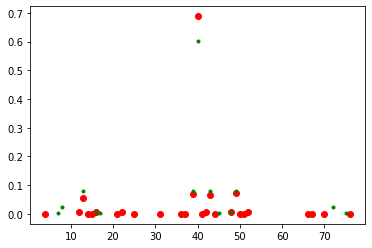

In [62]:
b = []
a = []
for i in range(basis.Ns):
    if (np.abs(psi_var[i])**2>=1e-4):
        b.append(np.abs(psi_var[i])**2)
        a.append(i)
y = []
x = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])**2>=1e-3:
        y.append(np.abs(eigenvectors[:,0][i])**2) 
        x.append(i)
n = []
m = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,1][i])**2>=1e-3:
        n.append(np.abs(eigenvectors[:,1][i])**2) 
        m.append(i)
     


        

plt.plot(a,b, "o",color = "r")
plt.plot(x,y, ".",color = "g")
#plt.plot(m,n, "o",color = "b")


In [345]:
string = ""
for i in range(basis.Ns):
    if np.abs(psi_var[i])**2>=1e-5:
        string+=str(psi_var[i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)

(-0.007861109134822858-0.00018692289118143595j)|2 2 1 2>
(-0.003289015314491963-0.00480920929553839j)|2 2 1 1>
(0.0032767062159061145-0.0009752362708689816j)|2 2 0 2>
(-0.007861109134822257-0.00018692289118133214j)|2 1 2 2>
(-0.013995153137754913-0.006446315110290416j)|2 1 2 1>
(0.009935943477619245+0.022897913327235443j)|2 1 1 2>
(0.24444980410660797-0.16332610698769215j)|2 1 1 1>
(-0.0003025609140163914-0.004517852665739003j)|2 1 1 0>
(0.007808284762763718+0.008035278953977178j)|2 1 0 2>
(-0.08680767161406427+0.070958251219741j)|2 1 0 1>
(0.0032767062159056682-0.0009752362708686331j)|2 0 2 2>
(-0.0031772747326094+0.0013726661615340021j)|2 0 2 1>
(0.007808284762761847+0.008035278953976824j)|2 0 1 2>
(0.0015156010532581532+0.005646667104391101j)|2 0 1 1>
(-0.001590567002229187-0.00490262124490372j)|2 0 1 0>
(-0.002555674781147332+0.013886480262147607j)|2 0 0 2>
(0.0029446805923216755+0.005763301385361861j)|2 0 0 1>
(-0.01399515313775287-0.00644631511028987j)|1 2 1 2>
(-0.00204068935645

In [101]:
#initial state
string_0 = "1111"

#for i in range(L):
#    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string_0)


psi_0[i_0] = 1.

In [103]:
psi = ms_gate_global(2*np.pi)@psi_0
string = ""
for i in range(basis.Ns):
    if np.abs(psi[i])**2>=1e-3:
        string+=str(psi[i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)
a = ms_gate_global(3*np.pi)

(-1.1729987415527113e-15+0.1464466094067268j)|2 2 2 2>
(-0.35355339059327506-4.608540849148181e-15j)|2 1 2 1>
(-0.3535533905932751-4.7056700676433e-15j)|1 2 1 2>
(1.1941022677129676e-14-0.8535533905932727j)|1 1 1 1>



In [242]:
phi = 0
sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
i = 1
j = 2
sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
print(sigma@sigma)

[[0.25+0.j 0.  +0.j 0.  +0.j]
 [0.  +0.j 0.25+0.j 0.  +0.j]
 [0.  +0.j 0.  +0.j 0.  +0.j]]
